In [ ]:
# read 20x images
# project to average intensity
# save as 8-bit tiff

import os
import sys
import numpy as np
import tifffile as tf
from skimage import io
from skimage.measure import label
import matplotlib.pyplot as plt


def read_20x_images(image_path):
    image_stack = io.imread(image_path)
    
    image = np.mean(image_stack, axis=0)
    imagemax = np.max(image_stack, axis=0)

    #plot image

    print(f'Processing {image_path}')
    #display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(imagemax, cmap='gray')
    plt.title('Max Projected Image')
    plt.axis('off')
    plt.show()

    print(f'Processing {image_path}')
    #display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title('Average Intensity Image')
    plt.axis('off')
    plt.show()

    
    return image, imagemax

def main():
    images = '/Users/katherineridley/Projects/PlaqueDist/Masks'
    image_files = os.listdir(images)
    for image_file in image_files:
        if not (image_file.endswith('OC.tiff') or image_file.endswith('M04.tiff')):
            continue
        image_path = os.path.join(images, image_file)
        filename = image_file[:-5]
        if image_file.endswith('OC.tiff'):
            image, ocmax = read_20x_images(image_path)
            tf.imsave(os.path.join(images, f'{filename}_max.tiff'), ocmax)

            
        if image_file.endswith('M04.tiff'):
            image, m04max = read_20x_images(image_path)
            tf.imsave(os.path.join(images, f'{filename}_max.tiff'), m04max)

        #stack ocmax and m04max in plot

        

        

    


if __name__ == '__main__':
    main()





    

In [ ]:
from skimage import io, color, filters, feature, measure, draw
from skimage import io, filters, exposure
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
import tifffile as tf

# Load the image
image_path = '/Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__OC_max.tiff'
image = io.imread(image_path)


# Convert to grayscale
image_gray = color.rgb2gray(image) if image.ndim == 3 else image

# Apply Gaussian blur
image_blurred = filters.gaussian(image_gray, sigma=2)

# Enhance contrast by rescaling the intensity of the image to span the entire range of possible values
image_contrast_enhanced = exposure.rescale_intensity(image_blurred, out_range=(0, 256))

# Apply a very strict lower cutoff for thresholding and no upper cutoff
lower_cutoff = 100  # You may adjust this value as needed
image_thresholded = np.clip(image_contrast_enhanced, lower_cutoff, None)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(image_thresholded, cmap='gray')
plt.title('Processed Image')
plt.axis('off')
plt.show()

'''
# Convert to grayscale if not already
if image.ndim == 3:
    image_gray = color.rgb2gray(image)
else:
    image_gray = image

from skimage import io, feature, color
import matplotlib.pyplot as plt

# Load the image

# Detect blobs using the Laplacian of Gaussian method
blobs_log = feature.blob_log(image_gray, max_sigma=30, num_sigma=3, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

# Display original image with detected blobs
plt.figure(figsize=(10, 10))
plt.imshow(image_gray, cmap='gray')
plt.title('Blobs Detected')

# Plot detected blobs as red circles
for blob in blobs_log:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    plt.gca().add_patch(c)

plt.show()


# Apply a Gaussian filter for smoothing (optional, but can help with noise)
image_smoothed = filters.gaussian(image_gray, sigma=2)

# Use a threshold to isolate brighter areas, assuming brighter areas are our objects of interest
threshold_value = filters.threshold_otsu(image_smoothed)
image_thresholded = image_smoothed > threshold_value



# Detect circles
# Define the range of radii to look for. Adjust these values based on the size of the objects.
radii_range = np.arange(20, 100, 2)
hough_res = hough_circle(image_thresholded, radii_range)

# Select the most prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, radii_range, total_num_peaks=5)

# Create a new image to draw circles on
output_image = np.zeros_like(image_gray)

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    output_image[circy, circx] = 1

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(image_thresholded, cmap='gray')
plt.title('Detected Circles')
plt.axis('off')
plt.show()'''


In [ ]:
from skimage import io, filters, exposure, measure, color
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__OC_avg.tiff'
image = io.imread(image_path)

# Convert to grayscale
image_gray = color.rgb2gray(image) if image.ndim == 3 else image

# Apply Gaussian blur
image_blurred = filters.gaussian(image_gray, sigma=2)

# Enhance contrast by rescaling the intensity of the image to span the entire range of possible values
image_contrast_enhanced = exposure.rescale_intensity(image_blurred, out_range=(0, 256))

# Apply a very strict lower cutoff for thresholding and no upper cutoff
lower_cutoff = 120  # You may adjust this value as needed
image_thresholded = np.clip(image_contrast_enhanced, lower_cutoff, None)

# Label the objects
labels = measure.label(image_thresholded > lower_cutoff, background=0)

# Measure properties of labeled regions
props = measure.regionprops(labels)

# Define size range: for example, pick objects between 500 and 2000 pixels in area
min_size = 1000
max_size = 20000

# Filter objects by size
filtered_labels = np.zeros_like(labels)
for prop in props:
    if min_size <= prop.area <= max_size:
        filtered_labels[labels == prop.label] = prop.label

# Display the result with the labels
plt.figure(figsize=(10, 10))
plt.imshow(filtered_labels, cmap='nipy_spectral')
plt.title('Labeled Objects within Size Range')
plt.axis('off')
plt.show()


In [ ]:
from skimage import io, filters, exposure, measure, color, morphology
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the image
images = '/Users/katherineridley/Projects/PlaqueDist/Masks'
image_files = os.listdir(images)
for image_file in image_files:
    if not image_file.endswith('OC_max.tiff'):
        continue
    image_path = os.path.join(images, image_file)
    image = io.imread(image_path)
#image_path = '/Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__OC_avg.tiff'
#image = io.imread(image_path)

    print(f'Processing {image_file}')
    #display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    

    # Convert to grayscale
    image_gray = color.rgb2gray(image) if image.ndim == 3 else image

    # Apply Gaussian blur
    image_blurred = filters.gaussian(image_gray, sigma=2)

    # Enhance contrast by rescaling the intensity of the image
    image_contrast_enhanced = exposure.rescale_intensity(image_blurred, out_range=(0, 256))

    # Apply a strict lower cutoff for thresholding to only keep higher intensity objects
    strict_lower_cutoff = 25
    image_thresholded = np.clip(image_contrast_enhanced, strict_lower_cutoff, None)

    # Perform morphological closing to enhance circular objects (if needed)
    structuring_element = morphology.disk(1)  # Adjust the size as needed
    image_closed = morphology.closing(image_thresholded, structuring_element)

    


    plt.figure(figsize=(10, 10))
    plt.imshow(image_closed, cmap='gray')
    plt.title('Closed Image')
    plt.axis('off')

    #smooth the image

    image_smoothed = filters.gaussian(image_closed, sigma=2)

    

    plt.figure(figsize=(10, 10))

    plt.imshow(image_smoothed, cmap='gray')
    plt.title('Smoothed Image')
    plt.axis('off')
    plt.show()



    # Label the objects
    labels = measure.label(image_closed, background=0)

  
    #display the labels

    plt.figure(figsize=(10, 10))
    plt.imshow(labels, cmap='nipy_spectral')
    plt.title('Labeled Objects')
    plt.axis('off')
    plt.show()



    # Measure properties of labeled regions
    props = measure.regionprops(labels, intensity_image=image_gray)  # Use the original grayscale image

    # Define intensity and size filters
    min_intensity = 0 # Minimum mean intensity to consider an object
    min_size = 100 # Minimum object size in pixels
    max_size = 10000   # Maximum object size in pixels

    # Filter objects by intensity and size
    filtered_labels = np.zeros_like(labels)
    for prop in props:


        if (min_size <= prop.area <= max_size) and (prop.mean_intensity >= min_intensity):
            filtered_labels[labels == prop.label] = prop.label


    # Display the result with the filtered labels


    plt.figure(figsize=(10, 10))
    plt.imshow(filtered_labels, cmap='nipy_spectral')
    plt.title('Filtered Objects by Intensity and Size')
    plt.axis('off')
    plt.show()

    tif


    #overlay the filtered labels on the original image to see the objects
    # filtered labels in colour



D_4_M04_OC_20x (2)_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif__OC_max.tiff


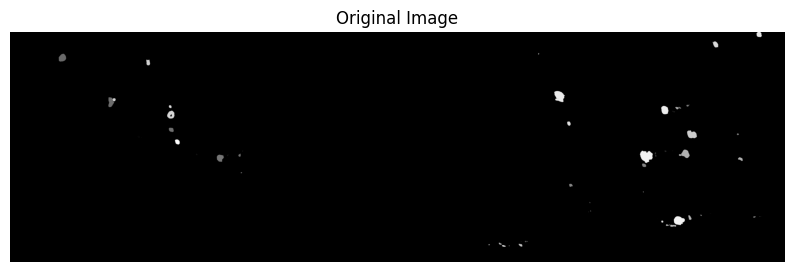

23 circular objects found


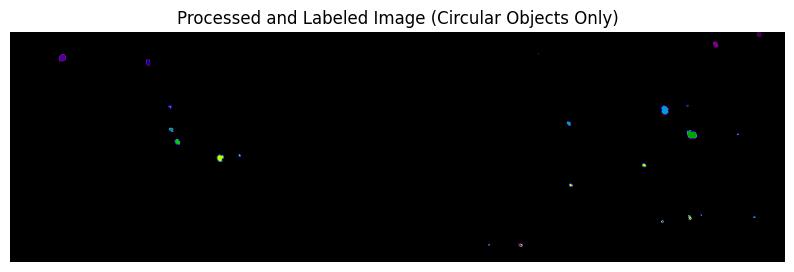

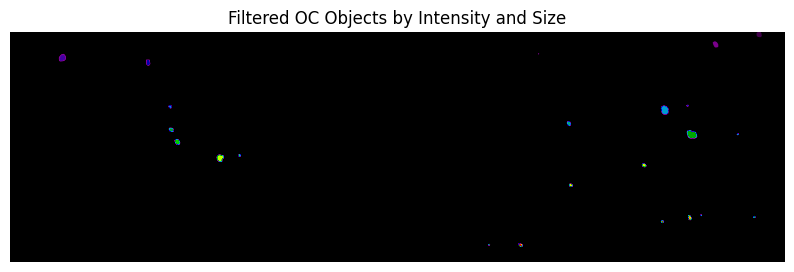

D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif__OC_max.tiff


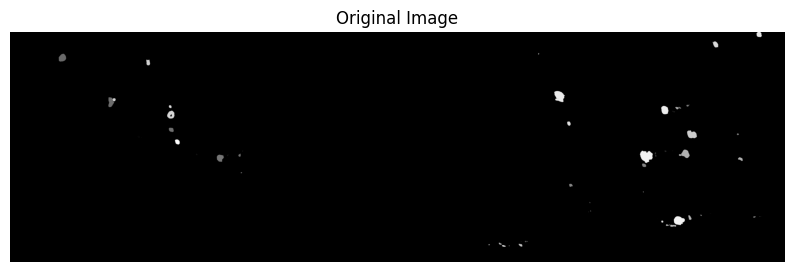

23 circular objects found


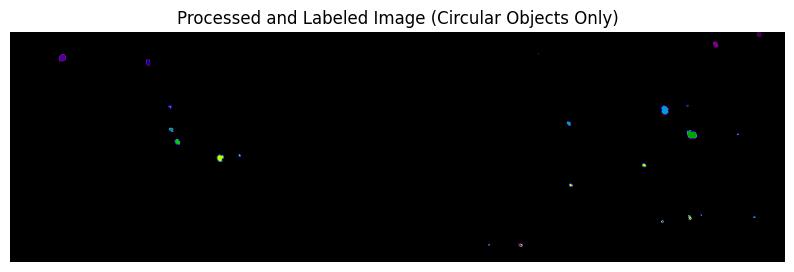

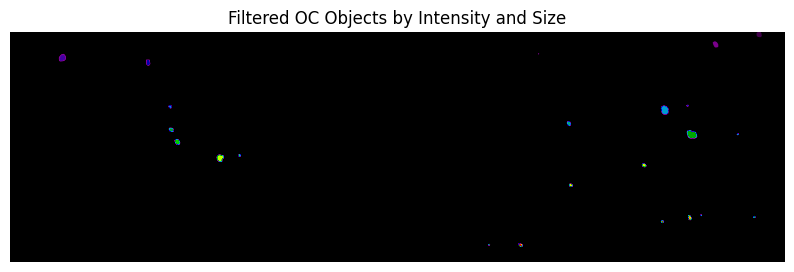

H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif__OC_max.tiff


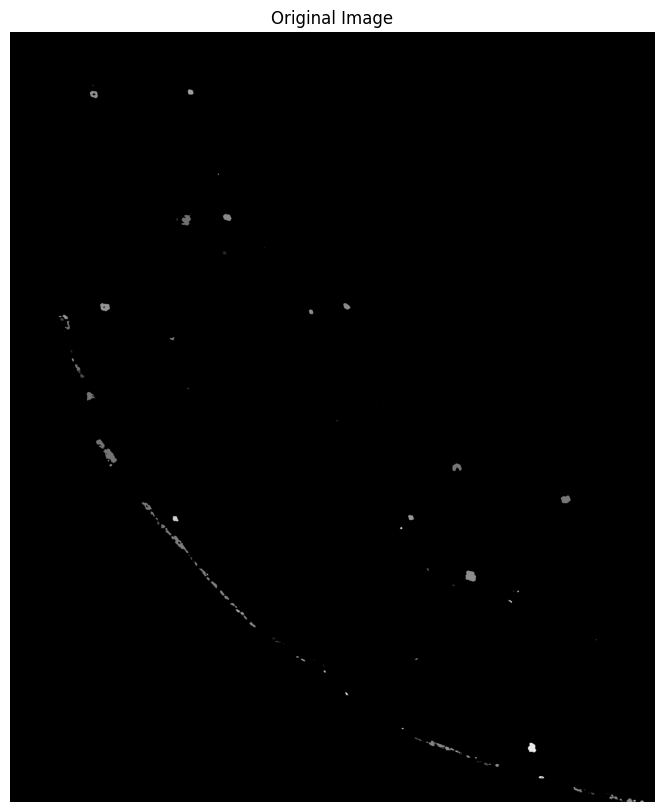

36 circular objects found


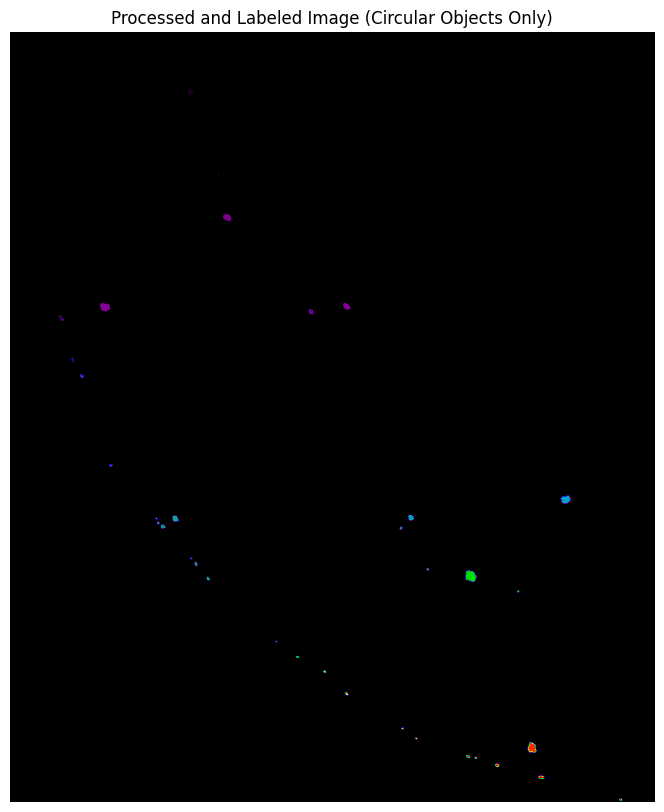

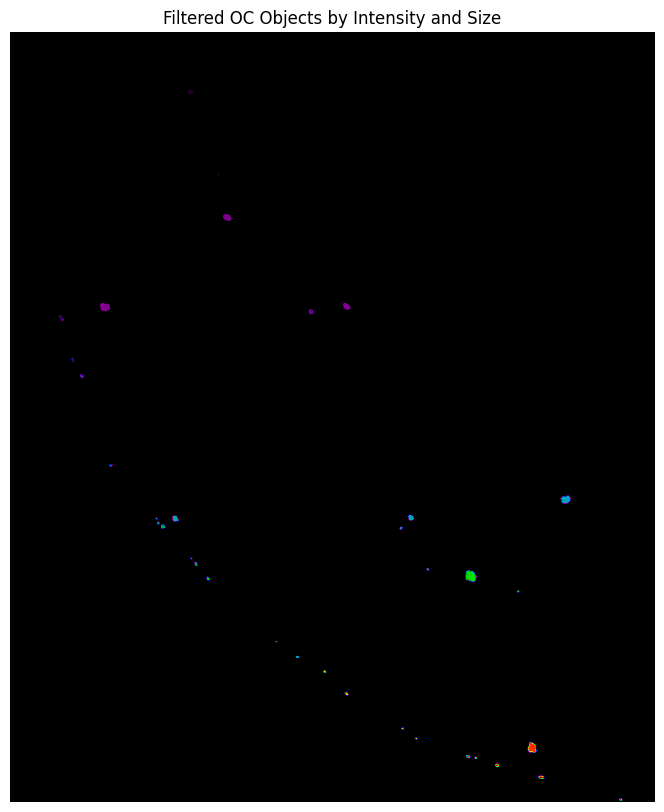

C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif__M04_max.tiff


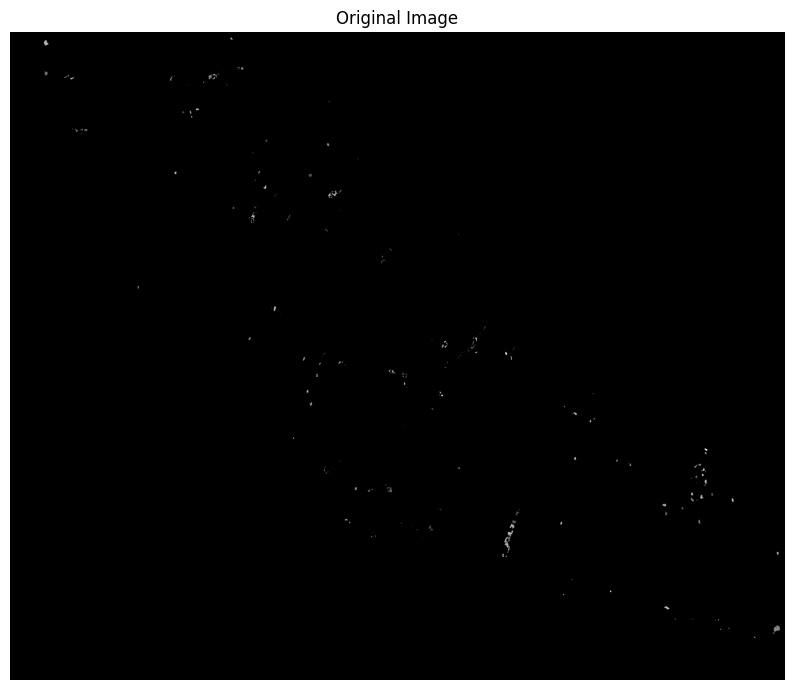

60 circular objects found


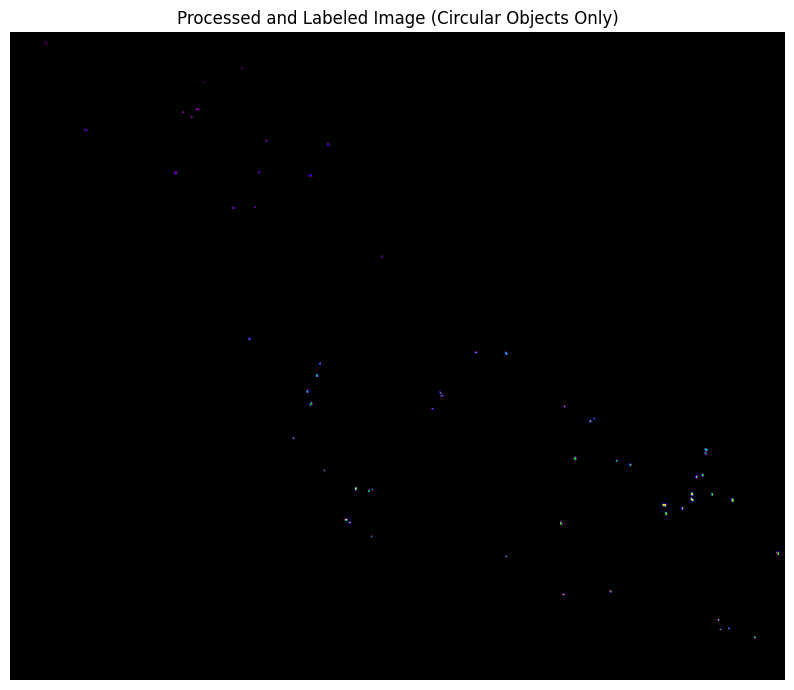

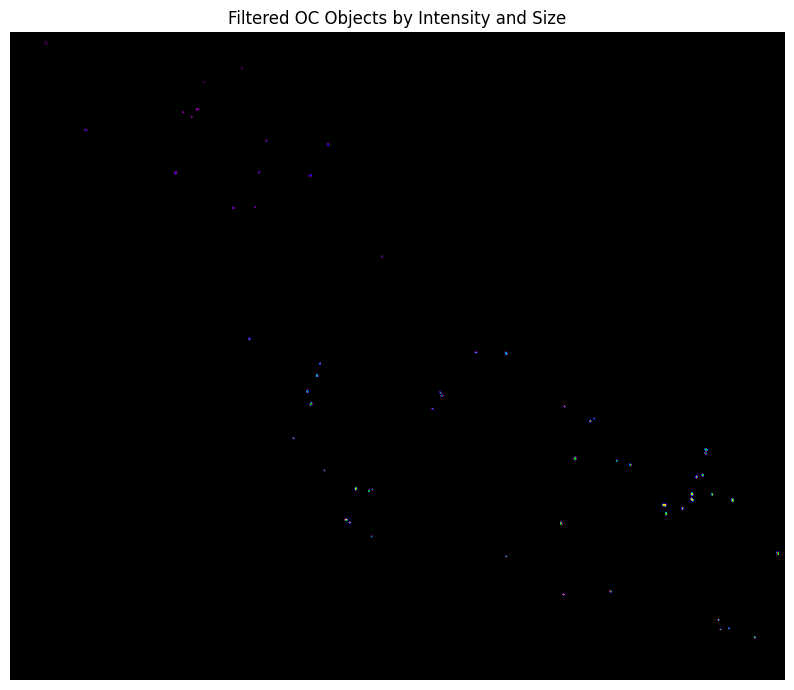

B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_M04_OC_20x.lif__OC_max.tiff


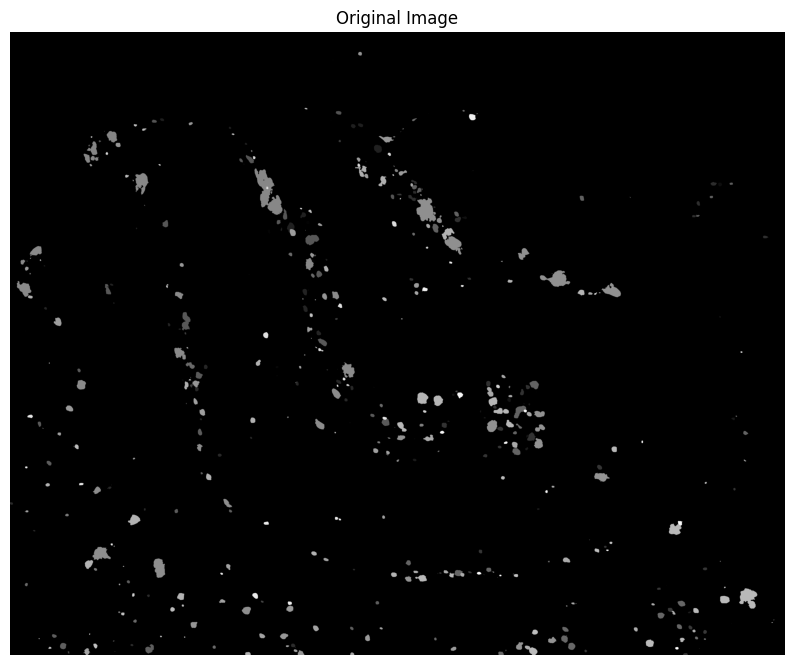

219 circular objects found


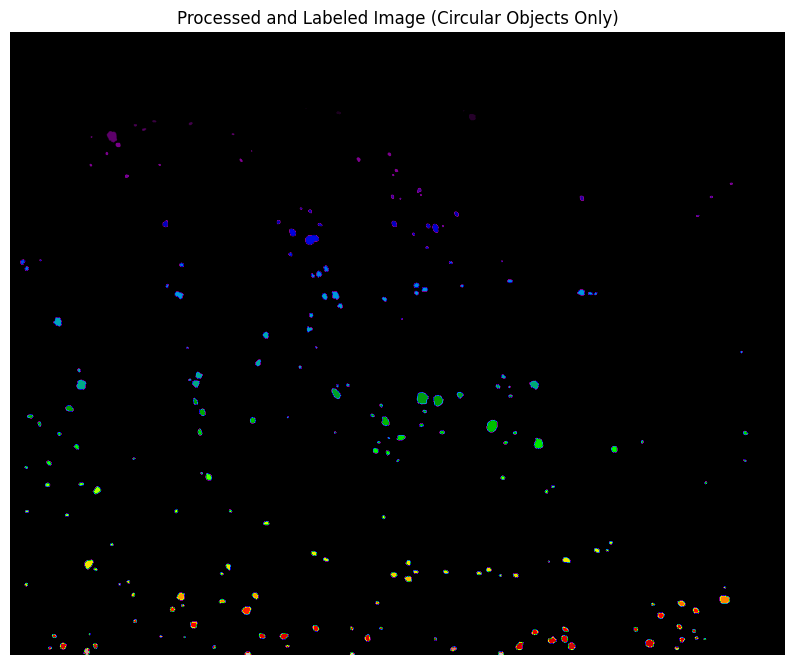

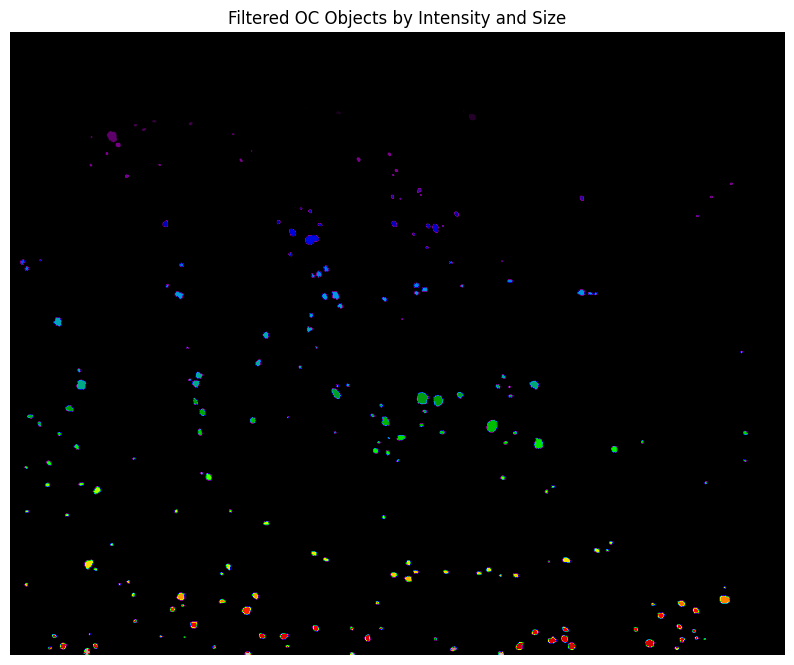

A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A_4_M04_OC_20x.lif (default)__M04_max.tiff


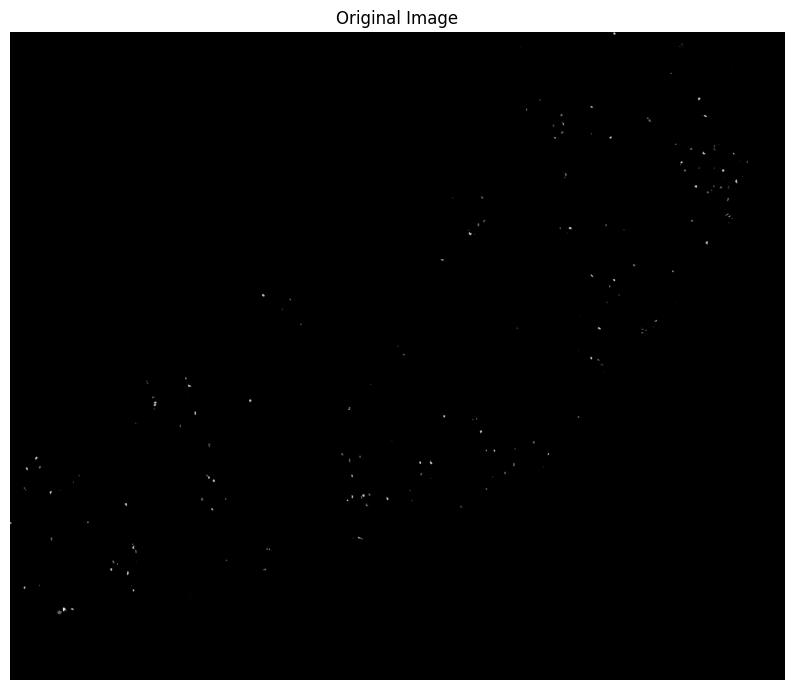

103 circular objects found


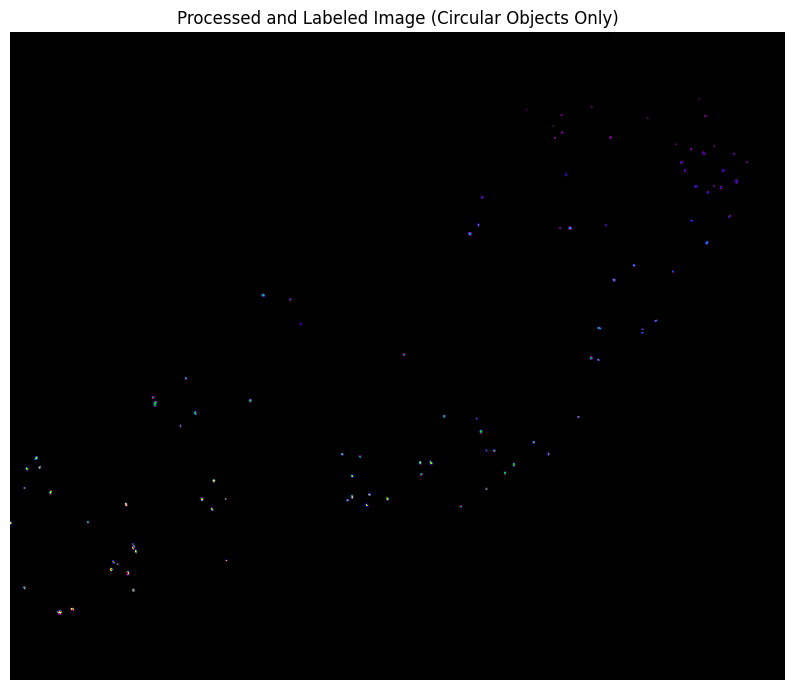

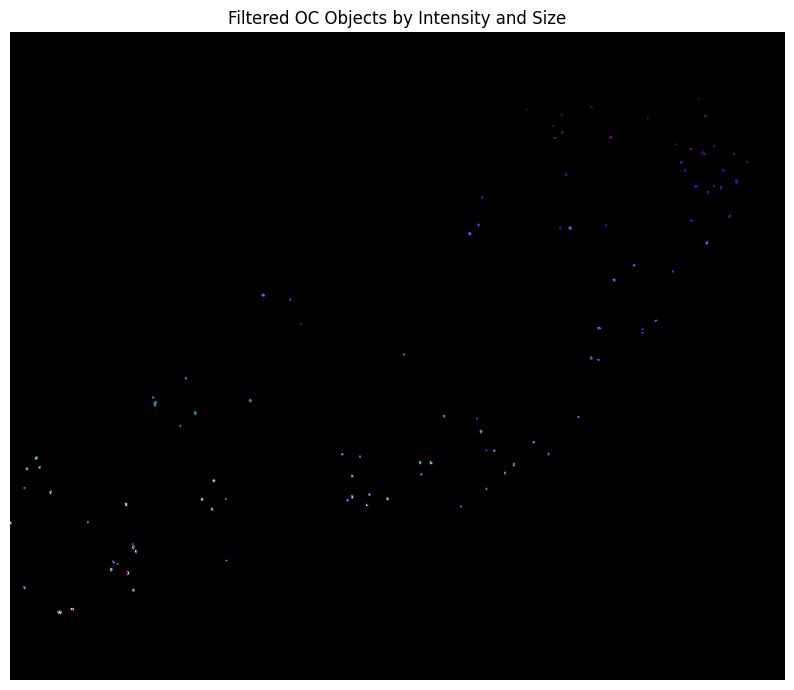

H_1_M04_OC_20x_H_1_M04_OC_HI_220224_20x - H_1_M04_OC_20x.lif__OC_max.tiff


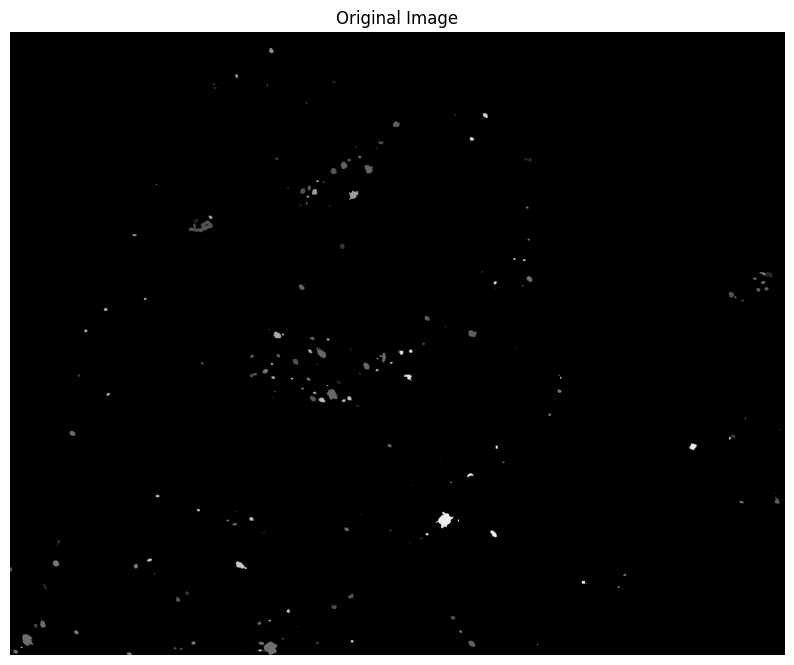

110 circular objects found


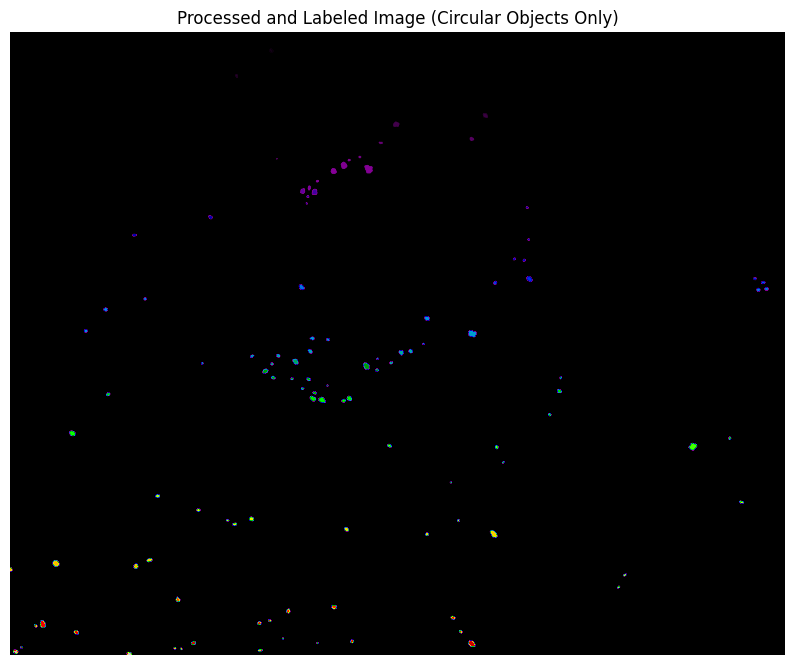

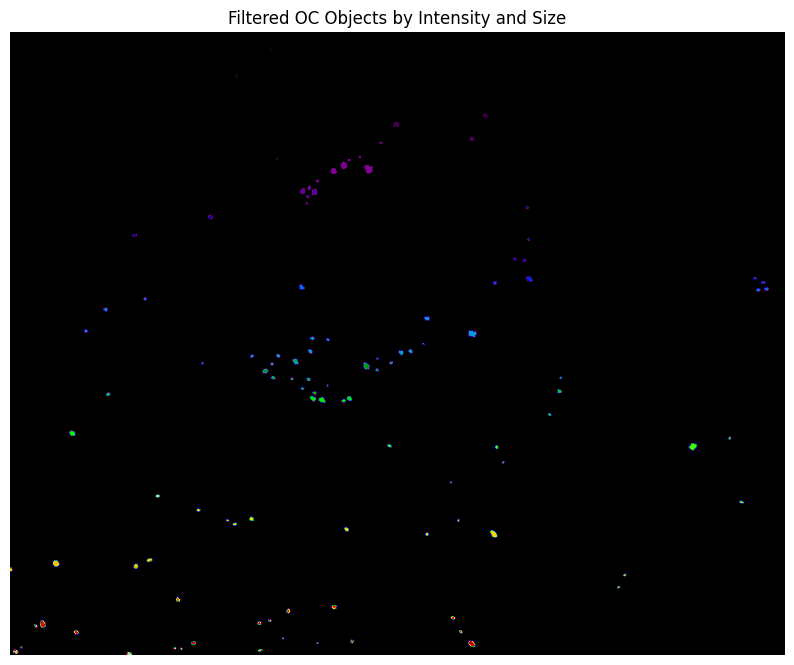

C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x - C_1_M04_OC_20x.lif (default)__OC_max.tiff


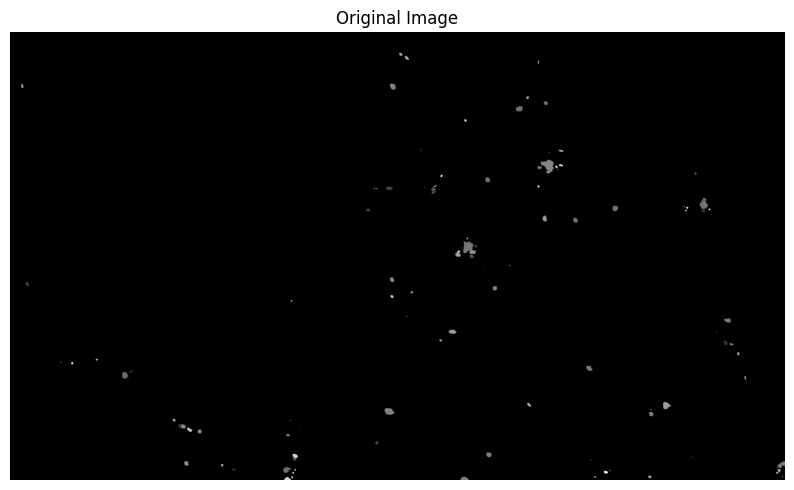

59 circular objects found


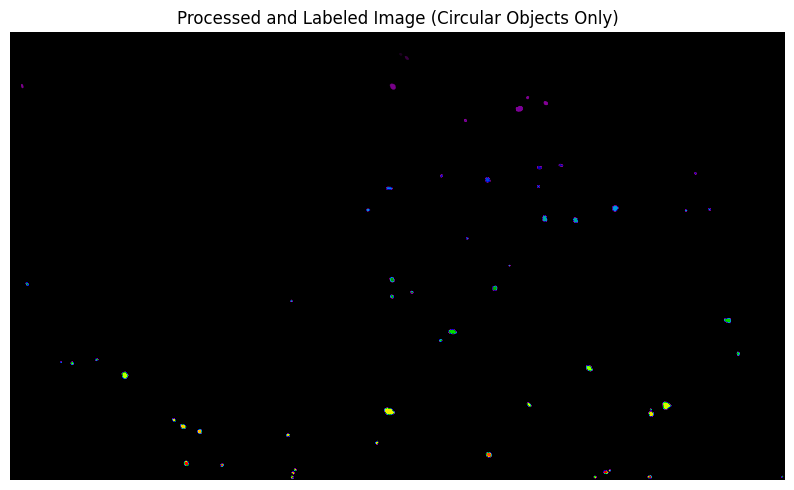

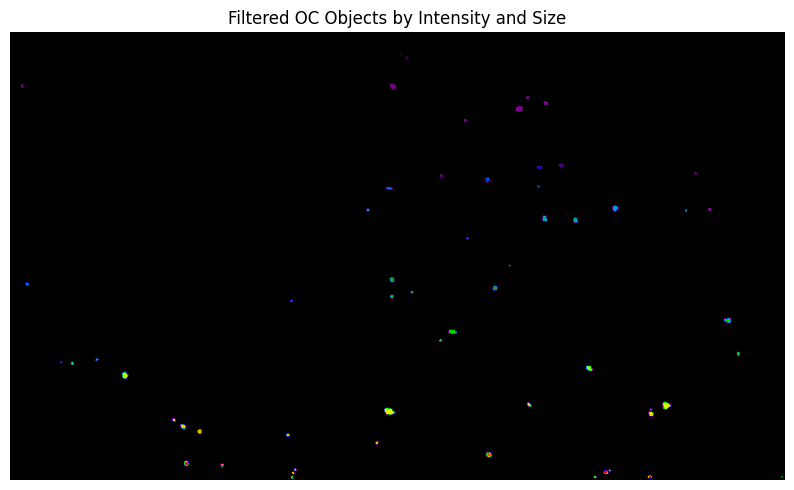

B_3_M04_OC_20x_B_3_M04_OC_HI_230224_20x - B_3_M04_OC_20x.lif (default)__M04_max.tiff


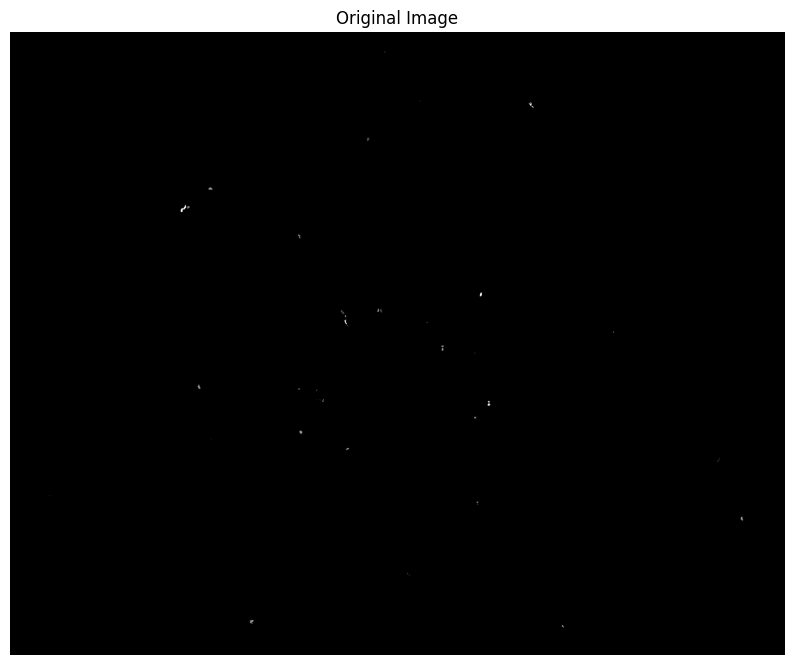

10 circular objects found


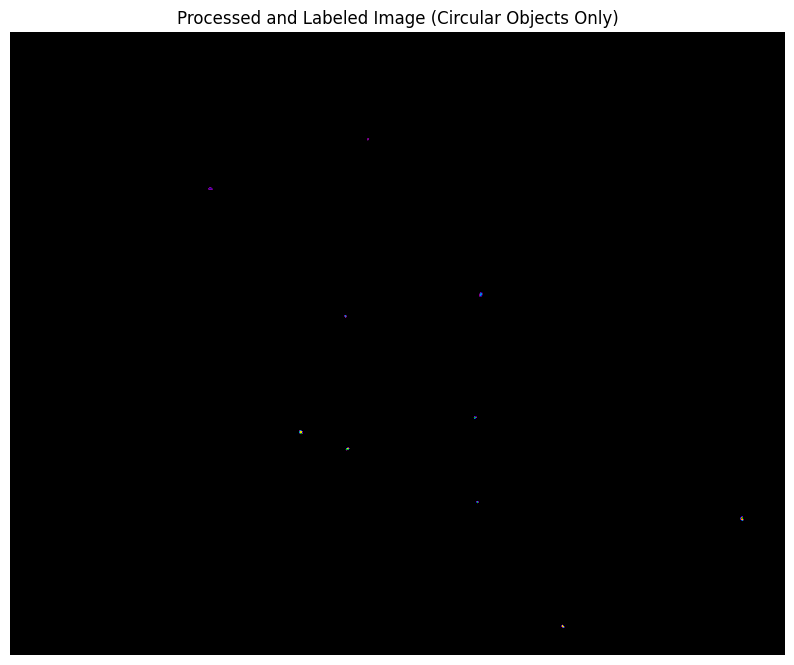

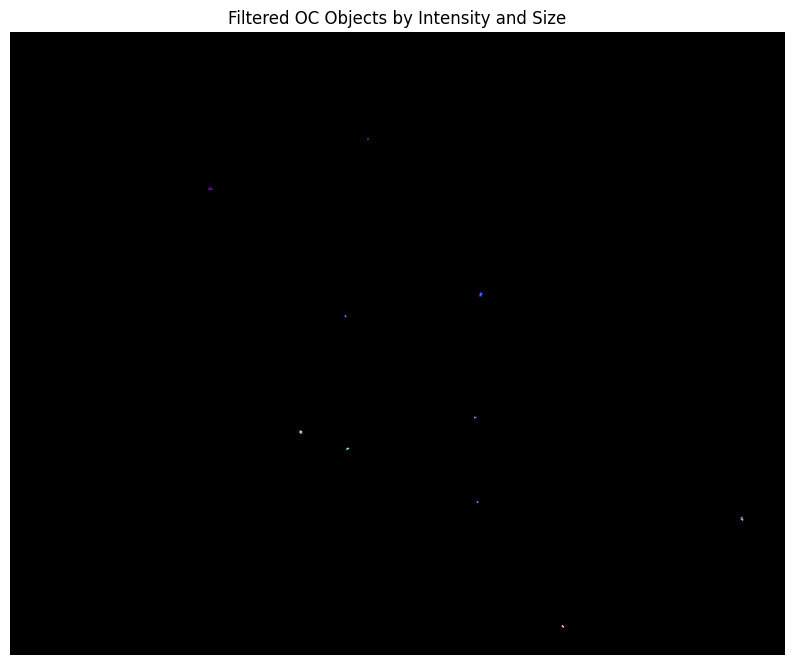

A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__M04_max.tiff


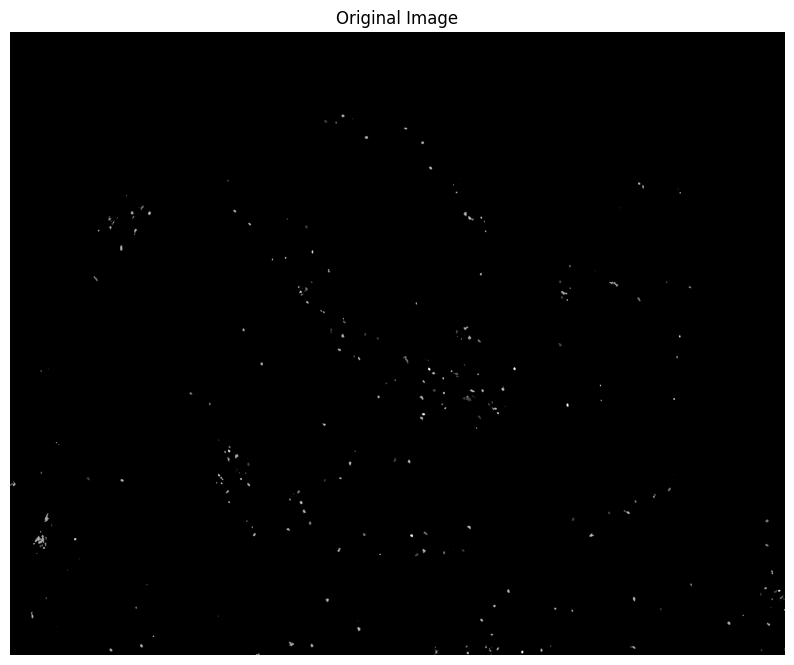

142 circular objects found


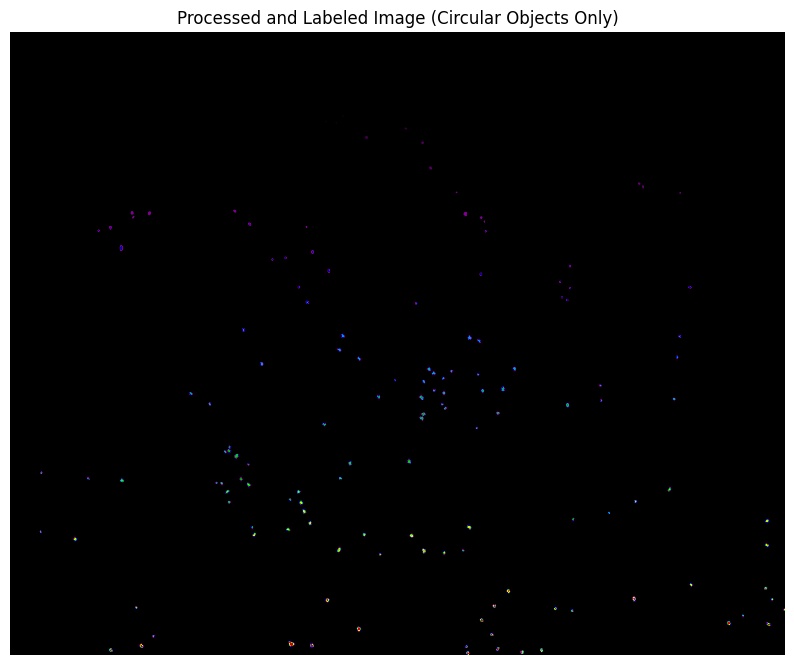

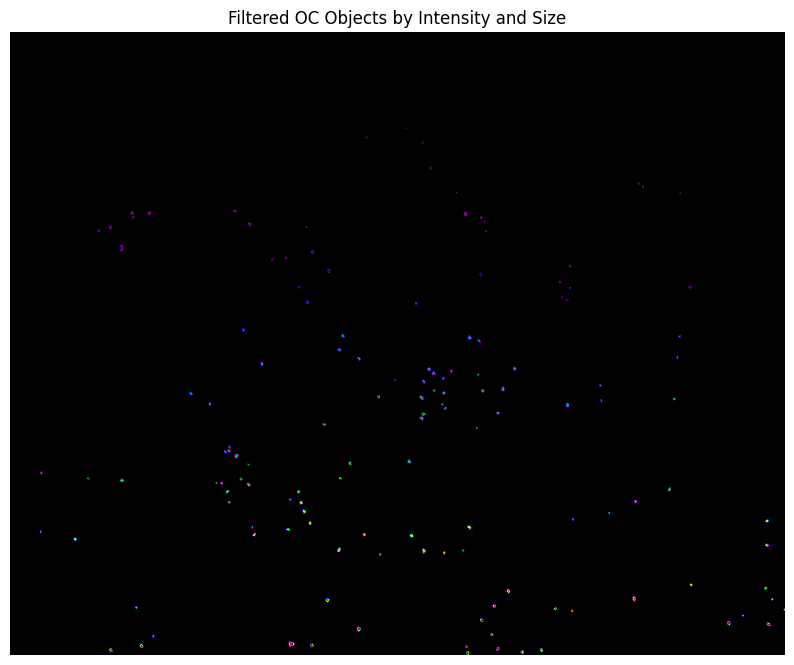

C_1_M04_OC_20x_C_1_M04_OC_SSCTX_080124_20x - C_1_M04_OC_20x.lif__OC_max.tiff


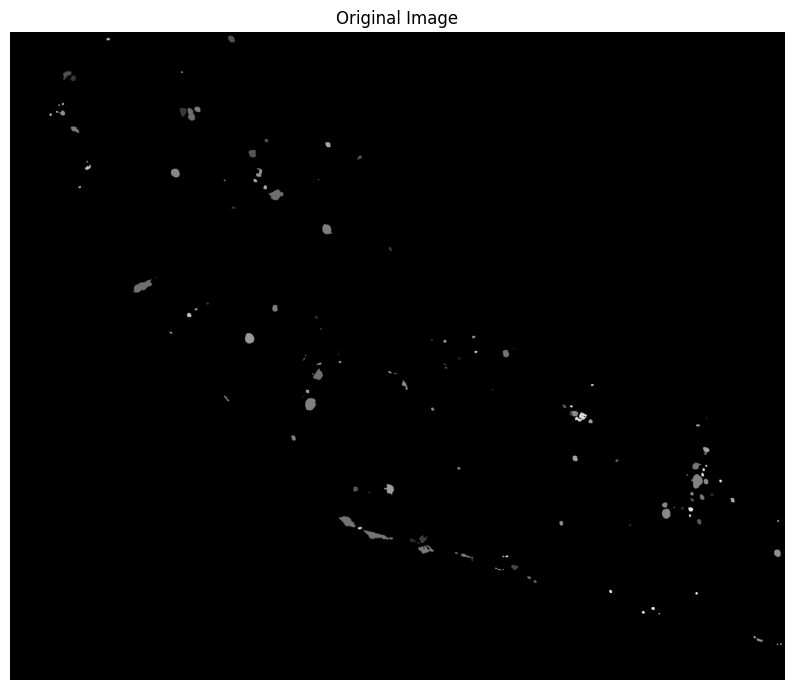

74 circular objects found


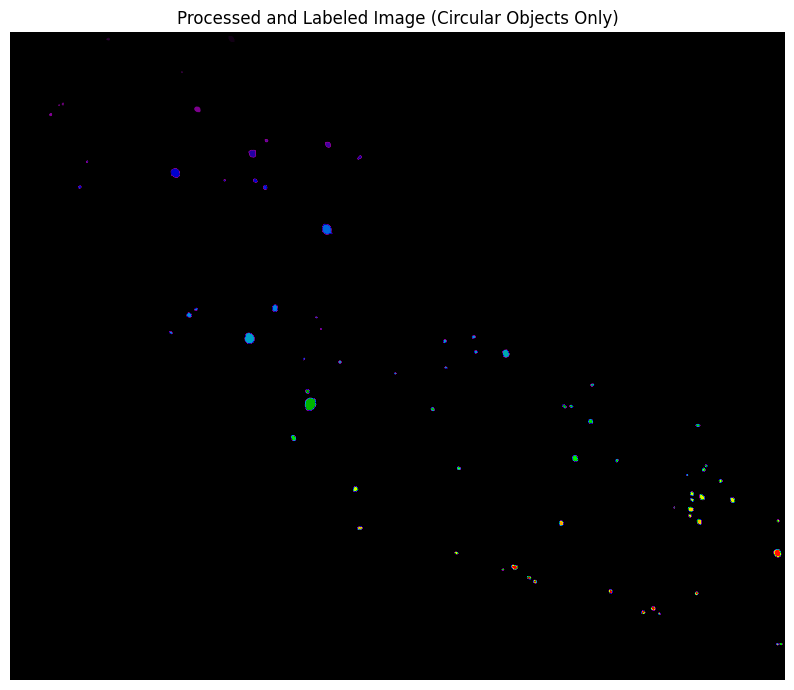

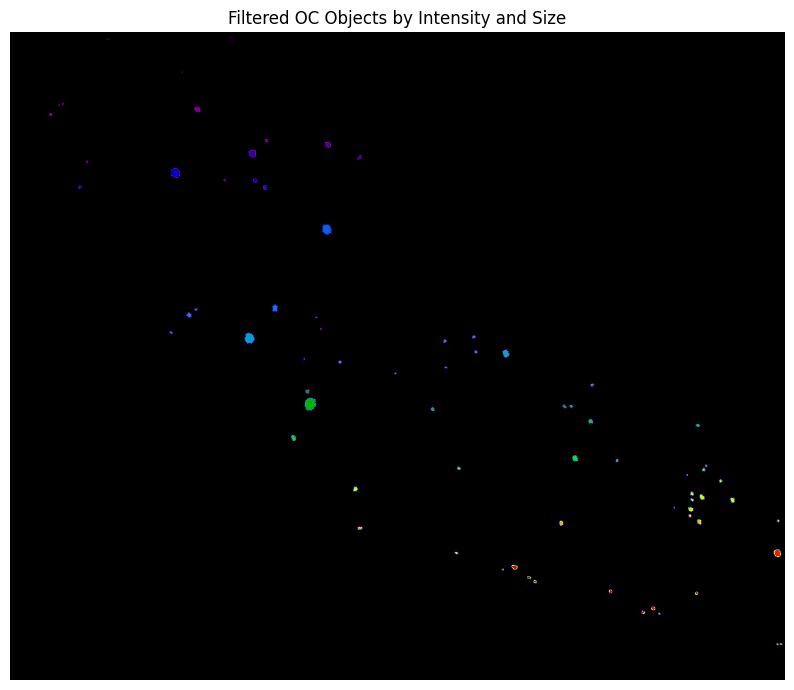

C_2_M04_OC_20x_C_2_M04_OC_SSCTX_080124_20x - C_2_M04_OC_20x.lif__OC_max.tiff


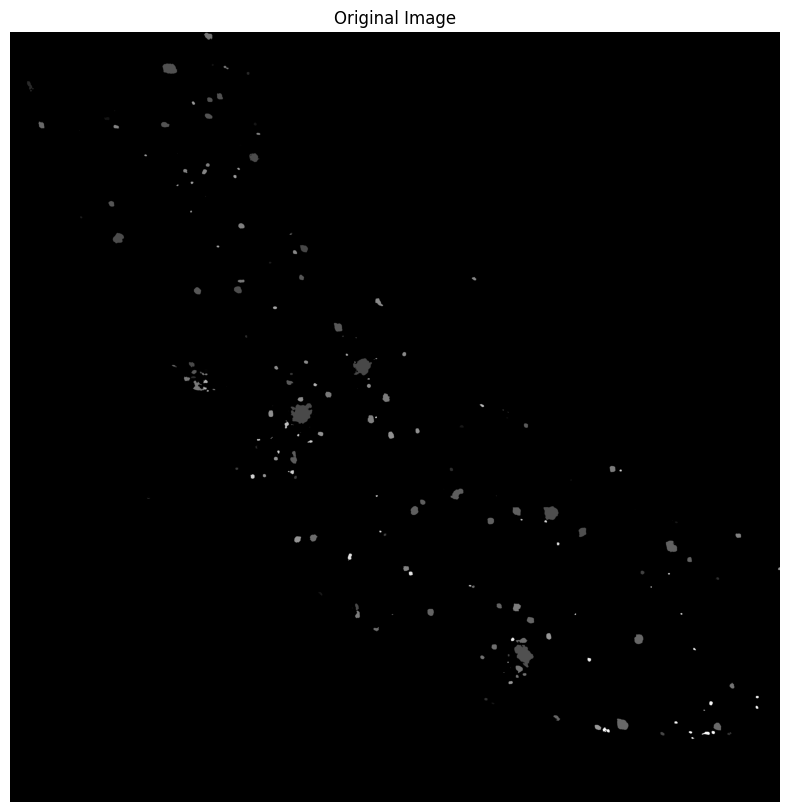

120 circular objects found


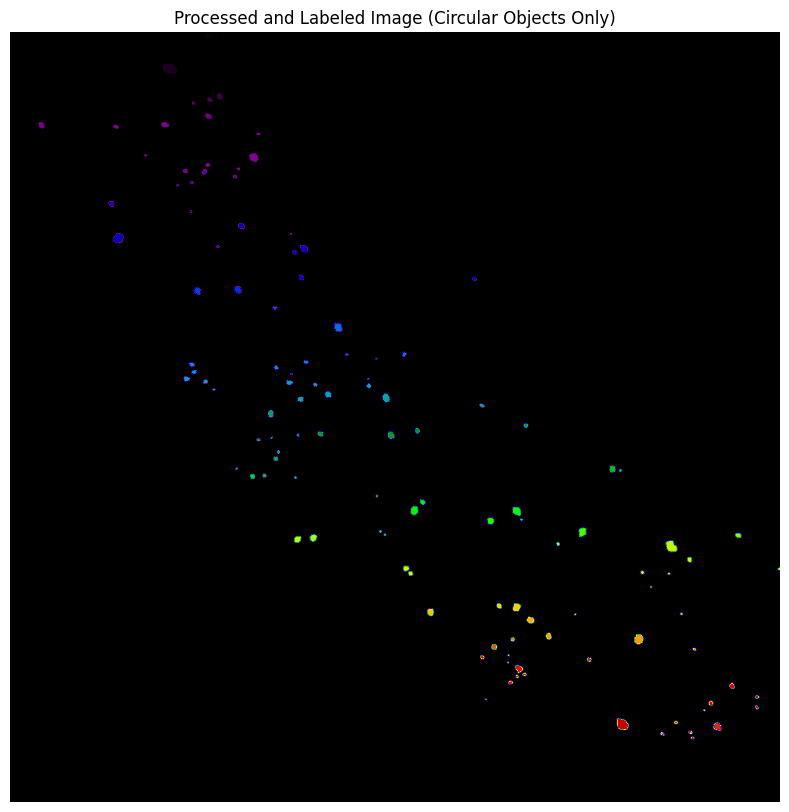

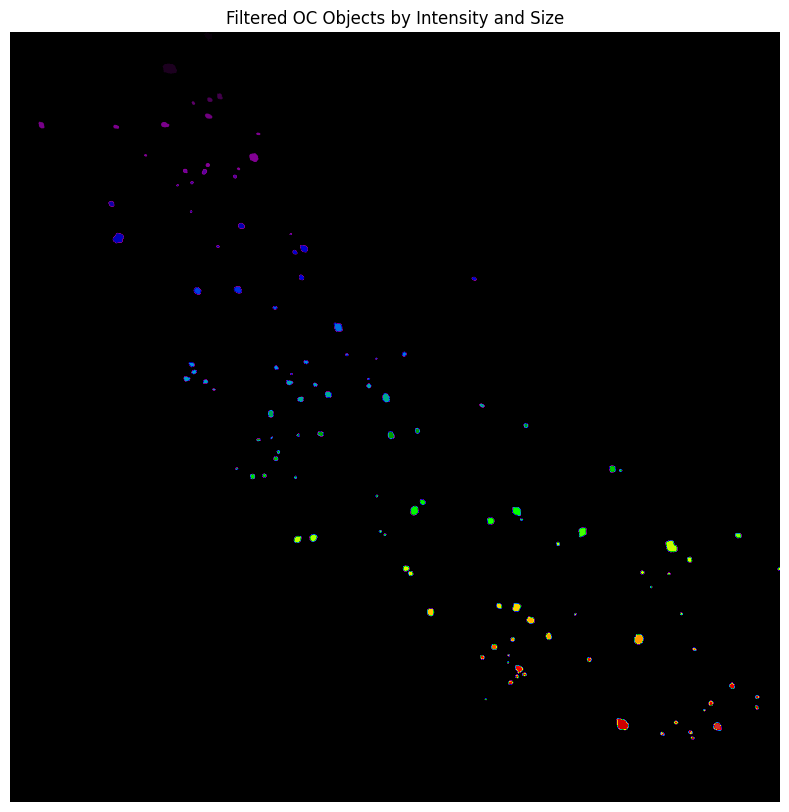

H_1_M04_OC_20x_H_1_M04_OC_SSCTX_220224_20x - H_1_M04_OC_20x.lif (default)__OC_max.tiff


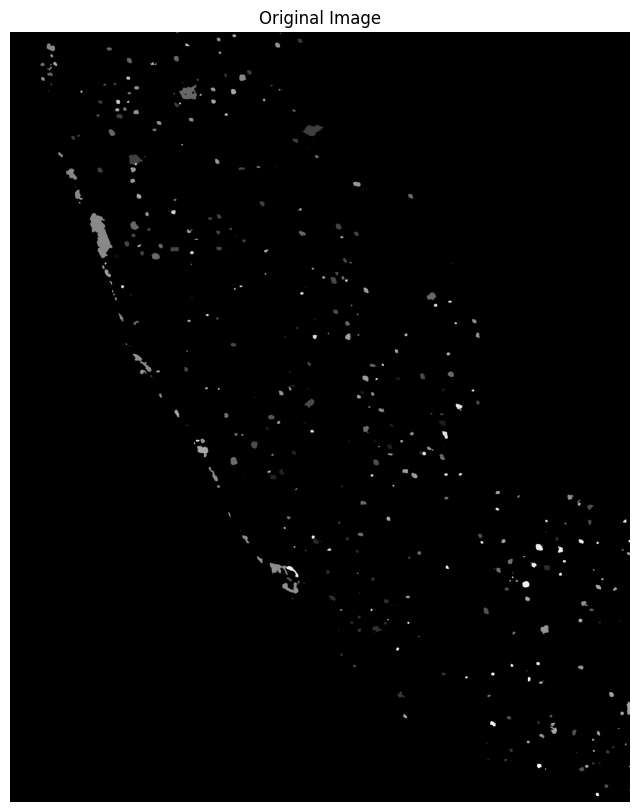

245 circular objects found


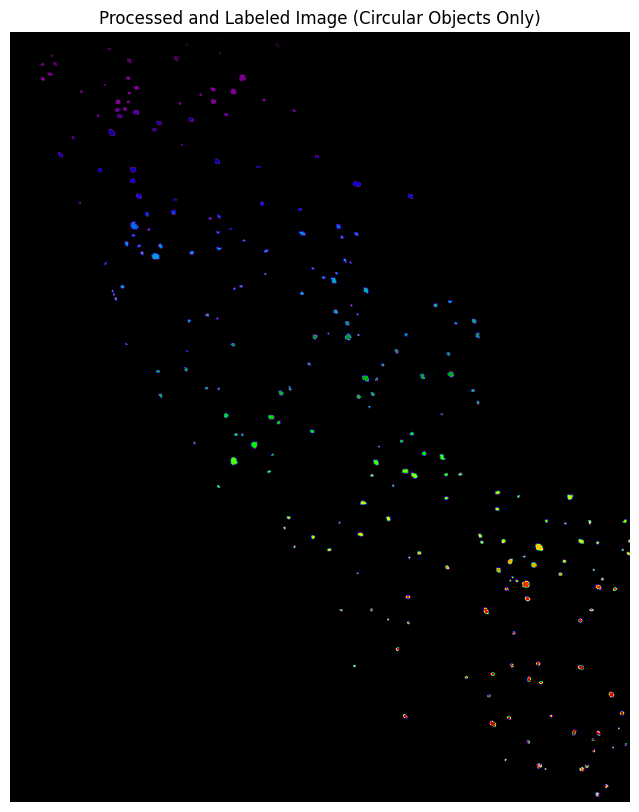

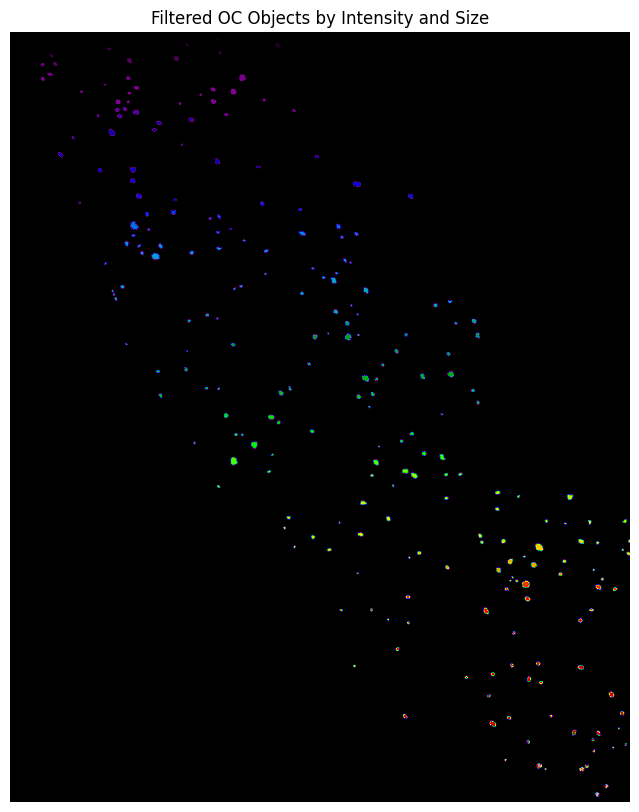

C_2_M04_OC_20x_C_2_M04_OC_HI_080124_20x - C_2_M04_OC_20x.lif (default)__M04_max.tiff


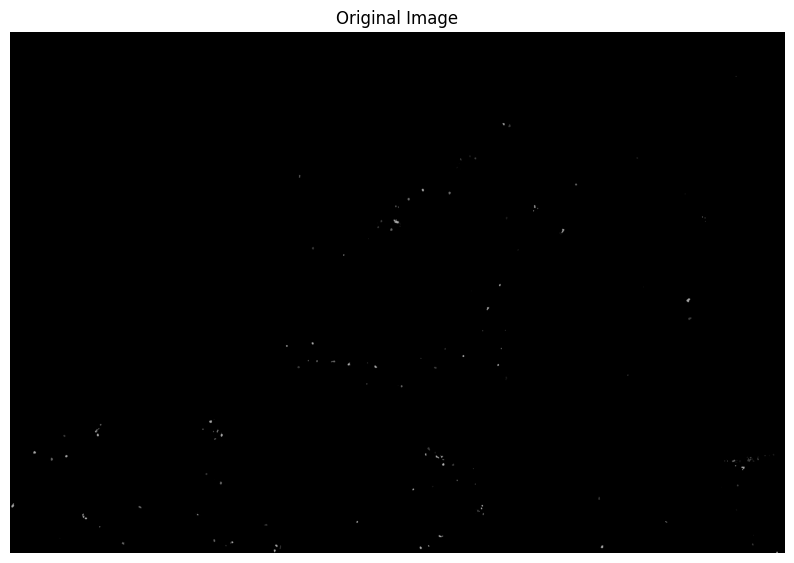

69 circular objects found


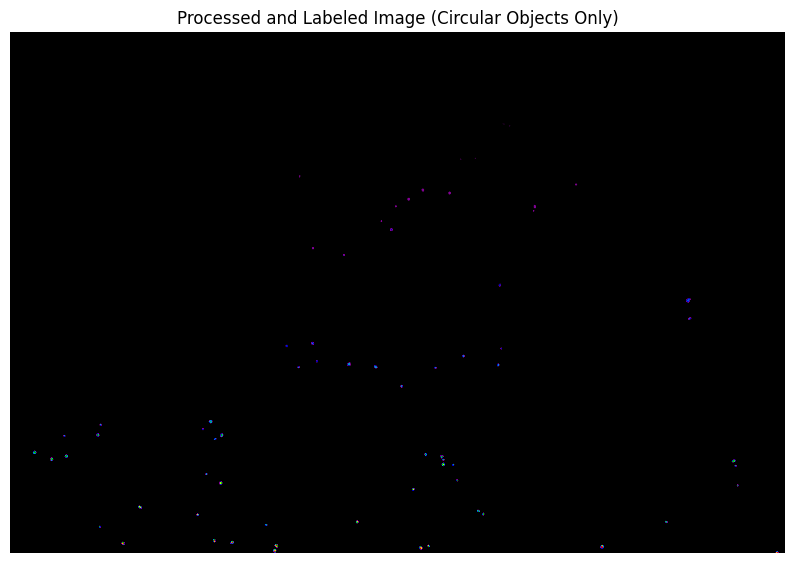

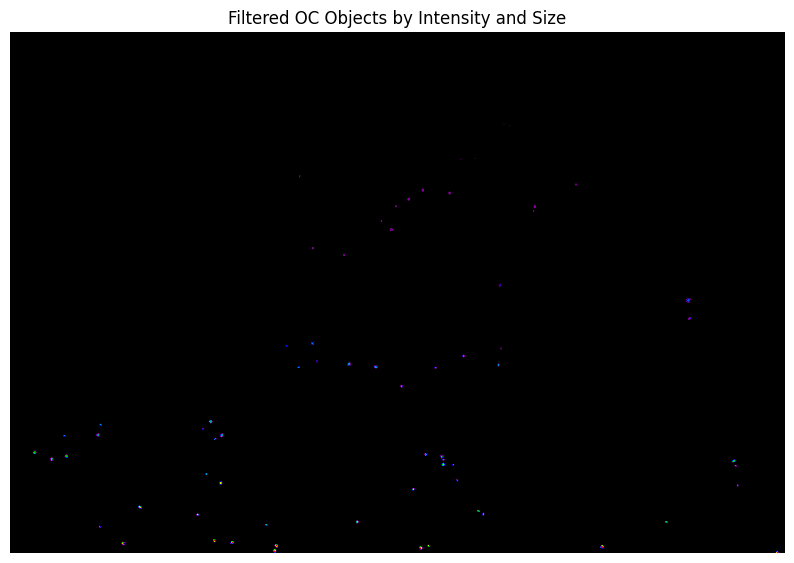

D_4_M04_OC_20x_D_4_M04_OC_HI_090124_20x - D_4_M04_OC_20x.lif (default)__OC_max.tiff


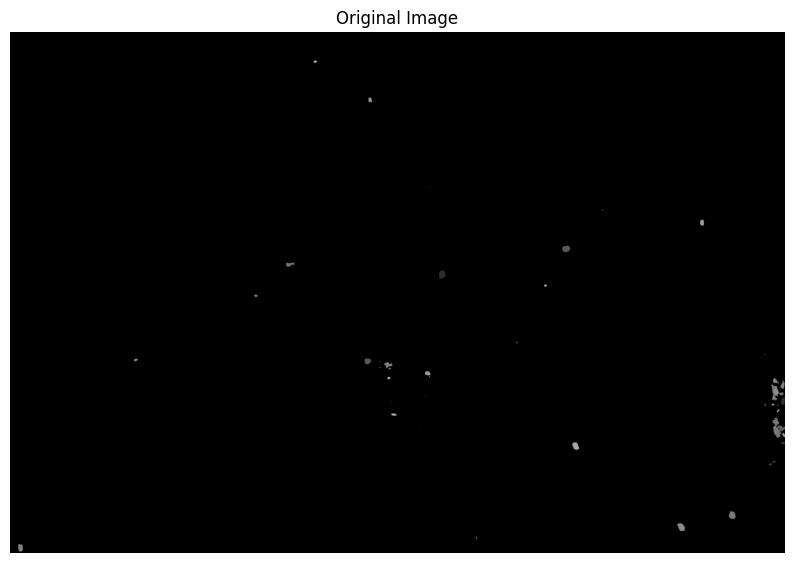

17 circular objects found


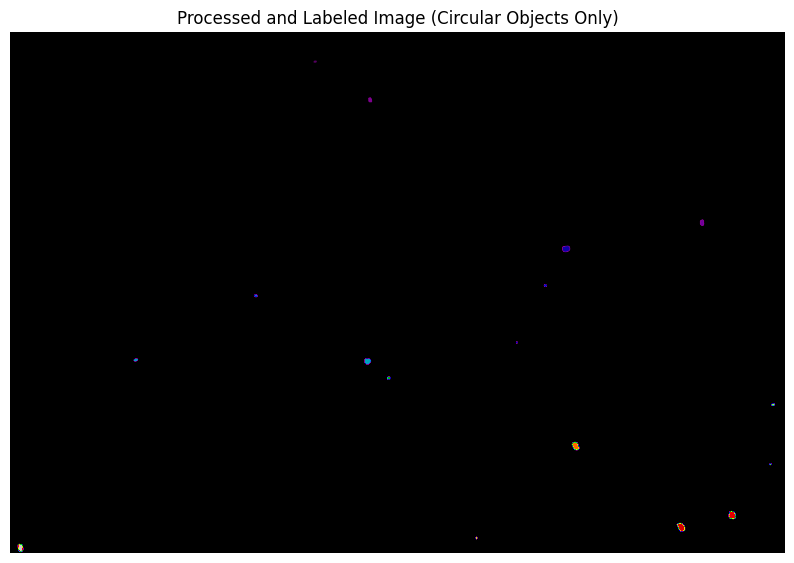

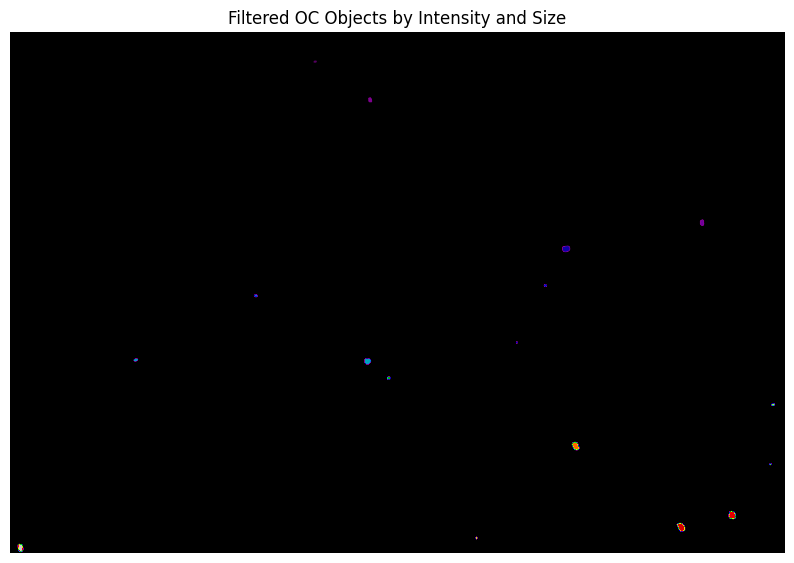

C_2_M04_OC_20x_C_2_M04_OC_HI_080124_20x - C_2_M04_OC_20x.lif (default)__OC_max.tiff


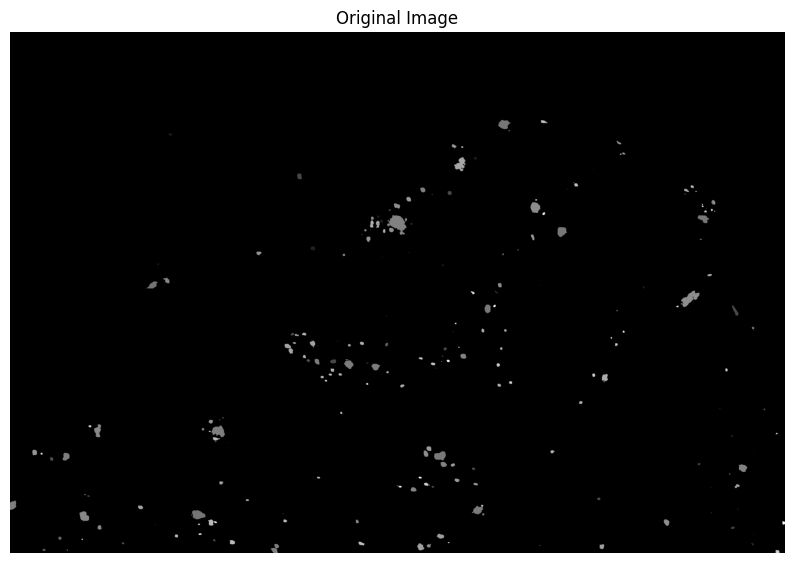

125 circular objects found


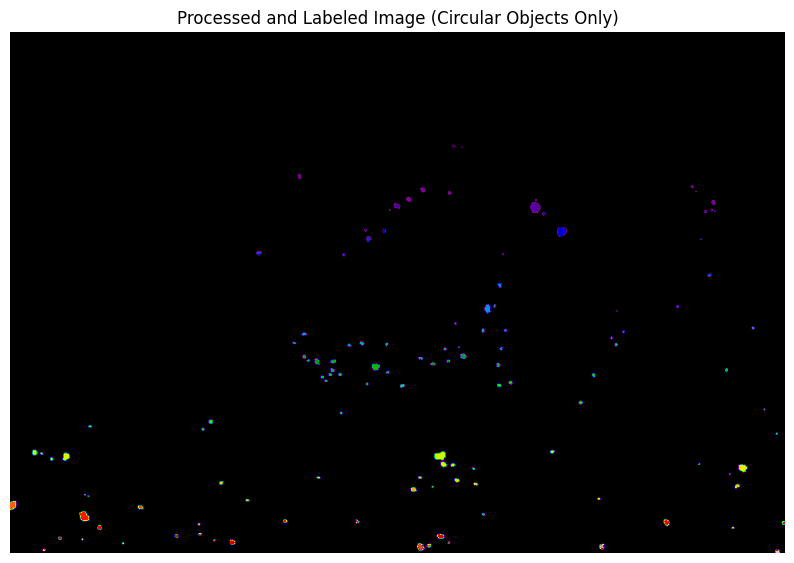

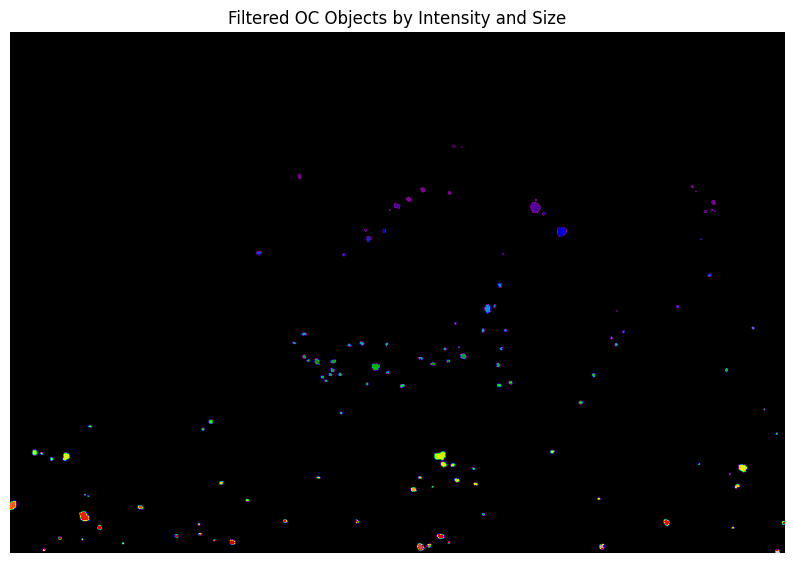

B_2_M04_OC_20x_B_2_M04_OC_HI_220224_20x - B_2_M04_OC_20x.lif__M04_max.tiff


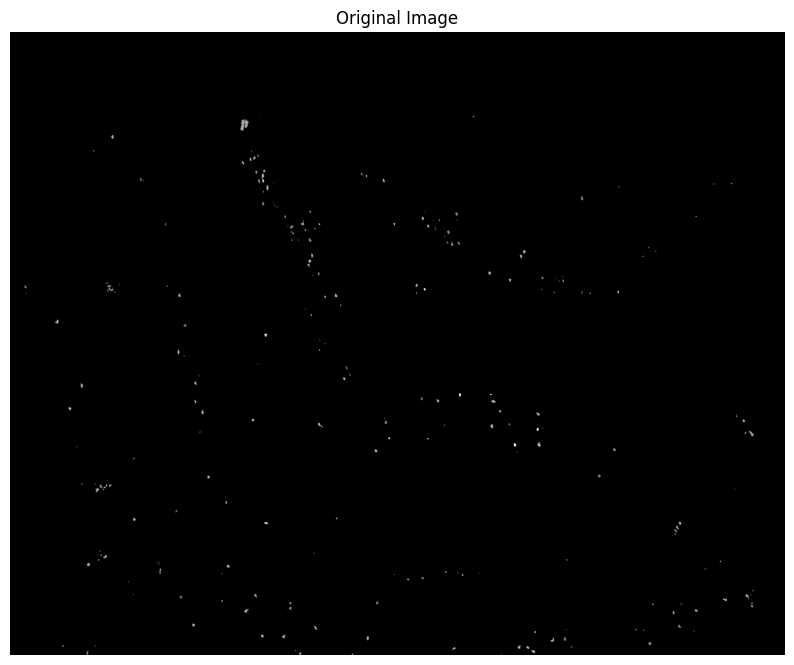

132 circular objects found


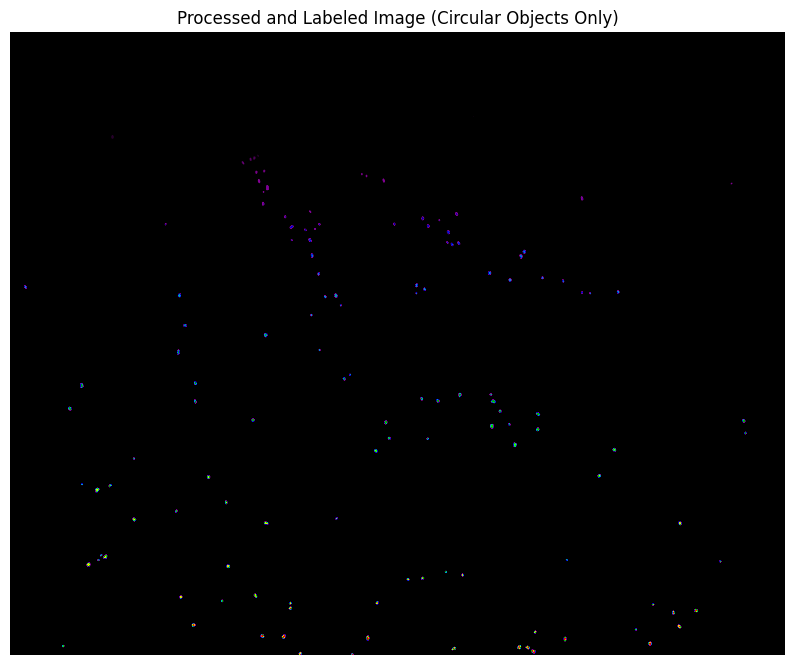

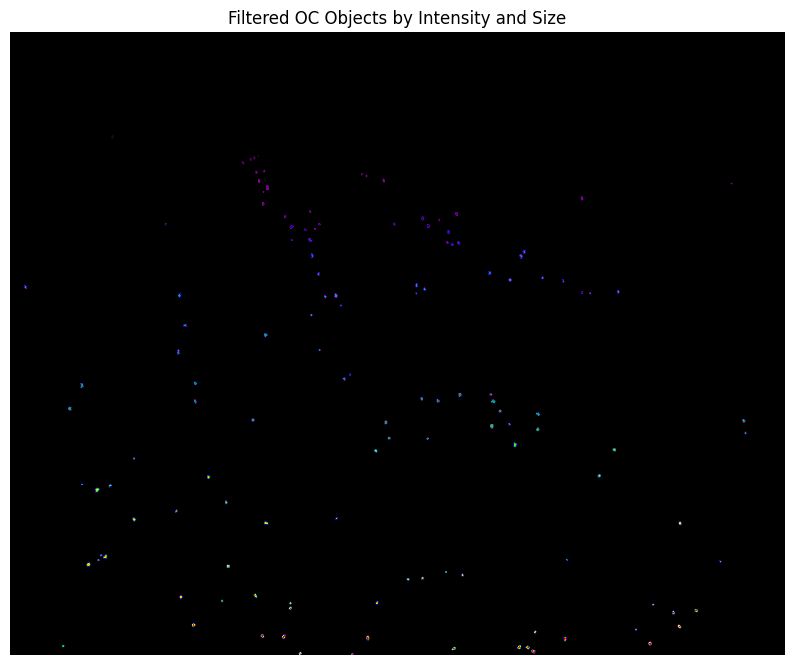

B_4_M04_OC_20x (2)_B_4_M04_OC_HI_230224_20x - B_4_M04_OC_20x.lif (default)__OC_max.tiff


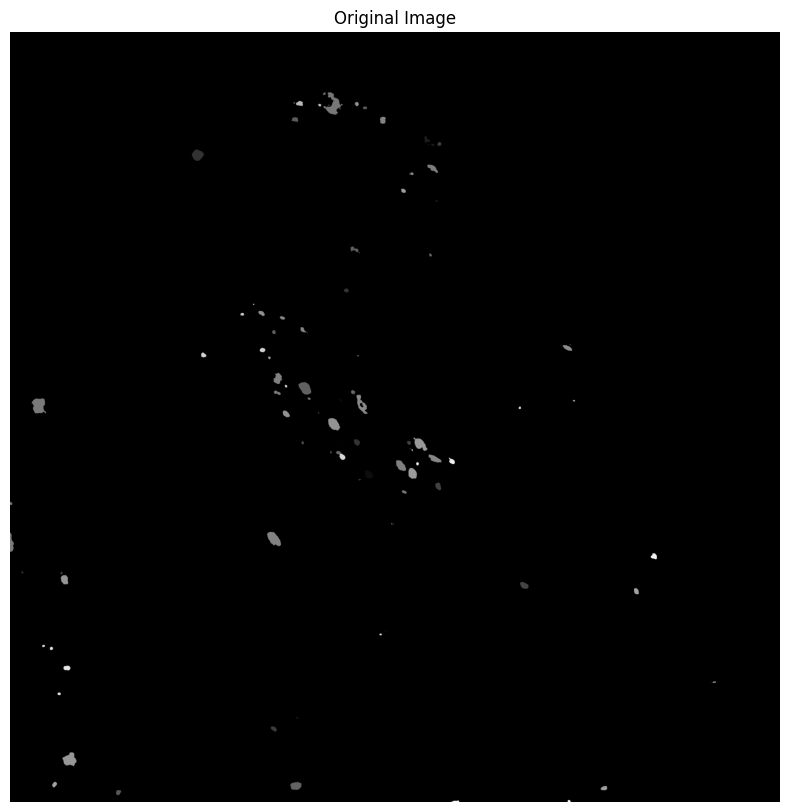

51 circular objects found


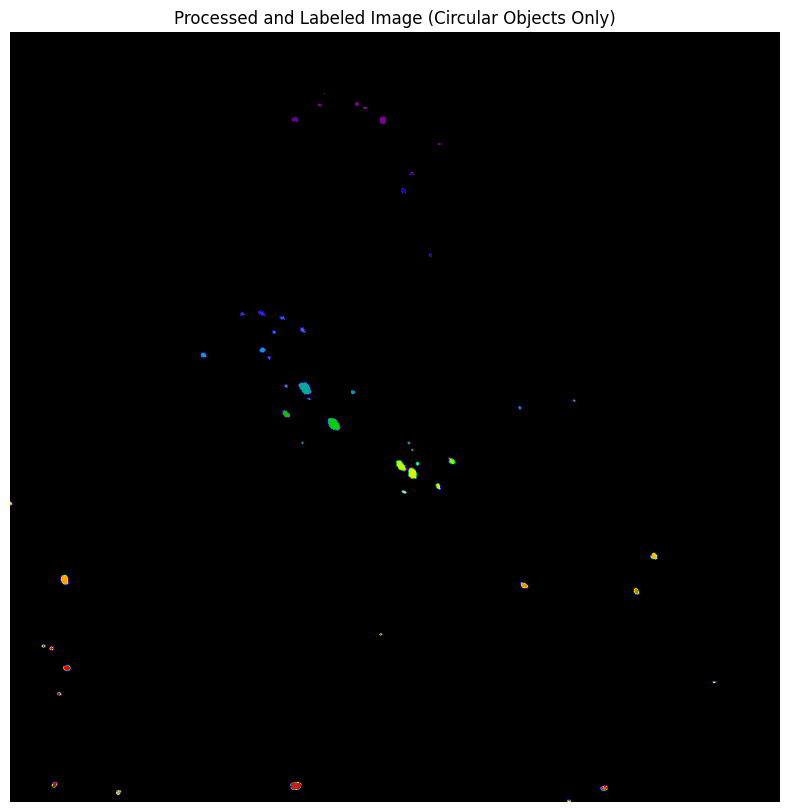

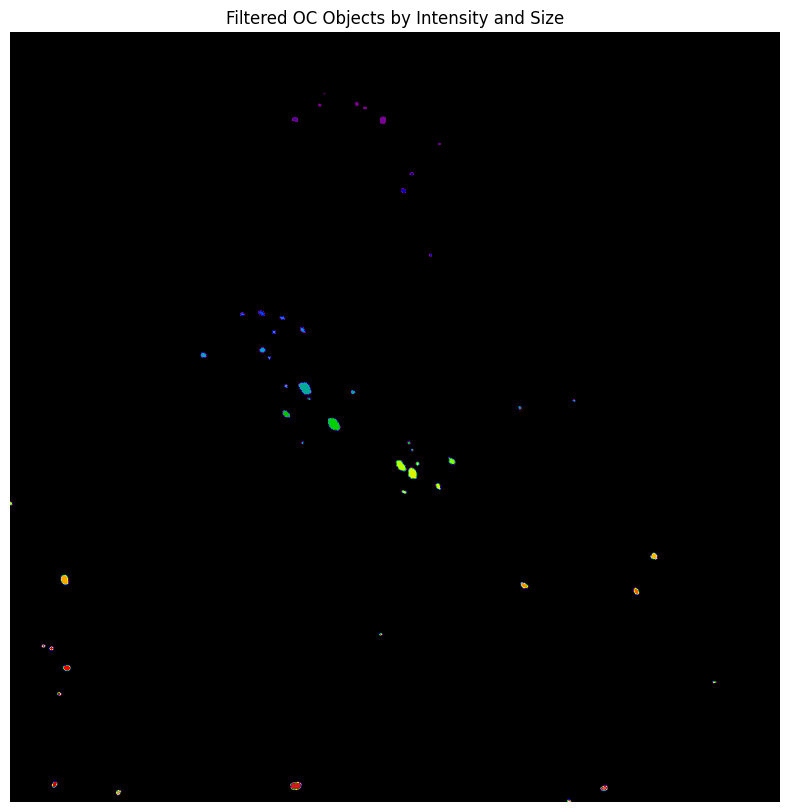

B_2_M04_OC_20x_B_2_M04_OC_SSCTX_220224_20x - B_2_M04_OC_20x.lif__OC_max.tiff


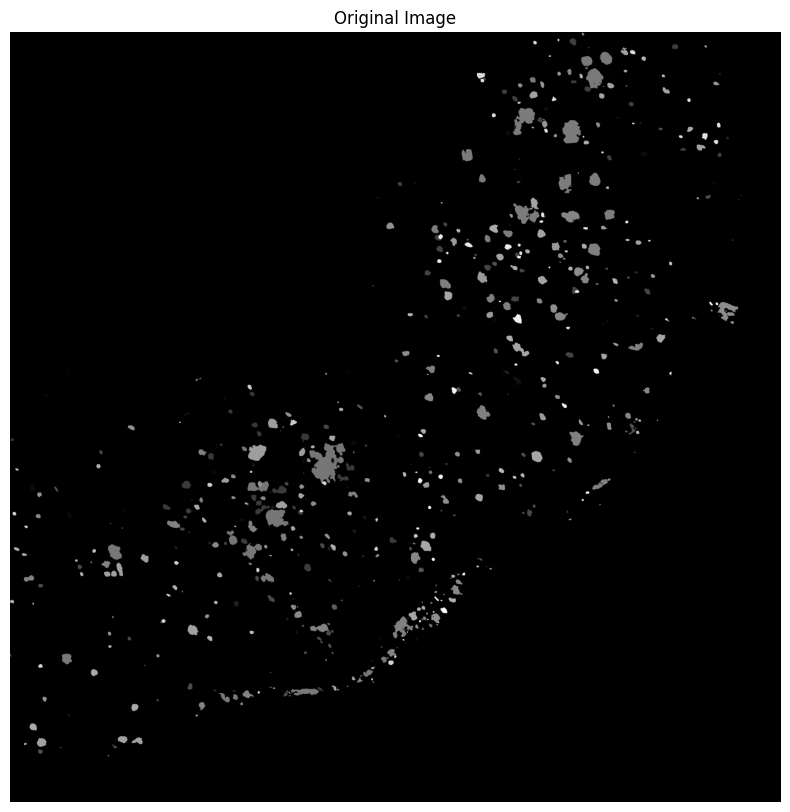

327 circular objects found


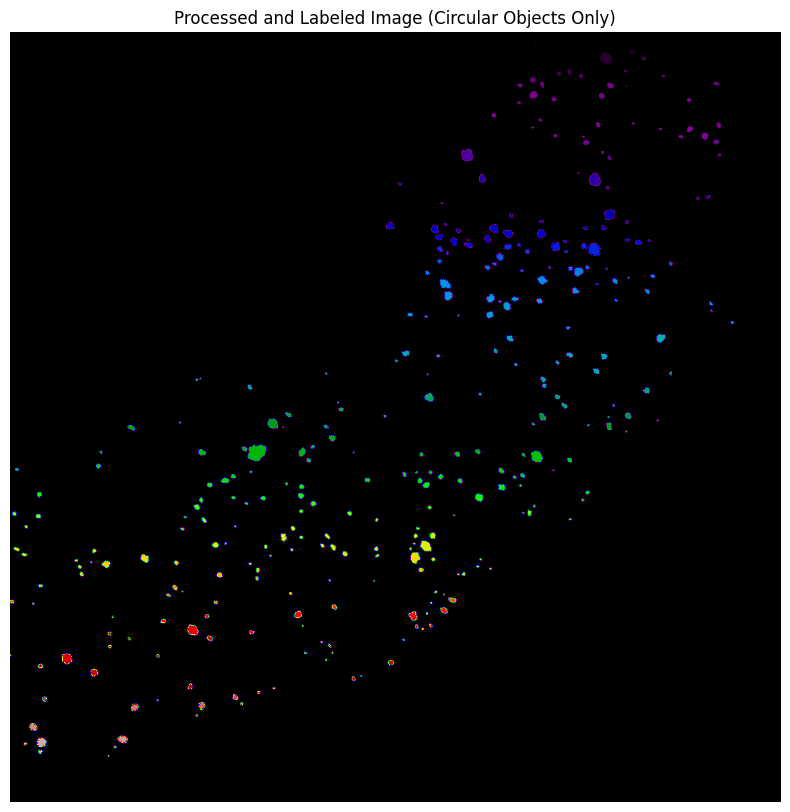

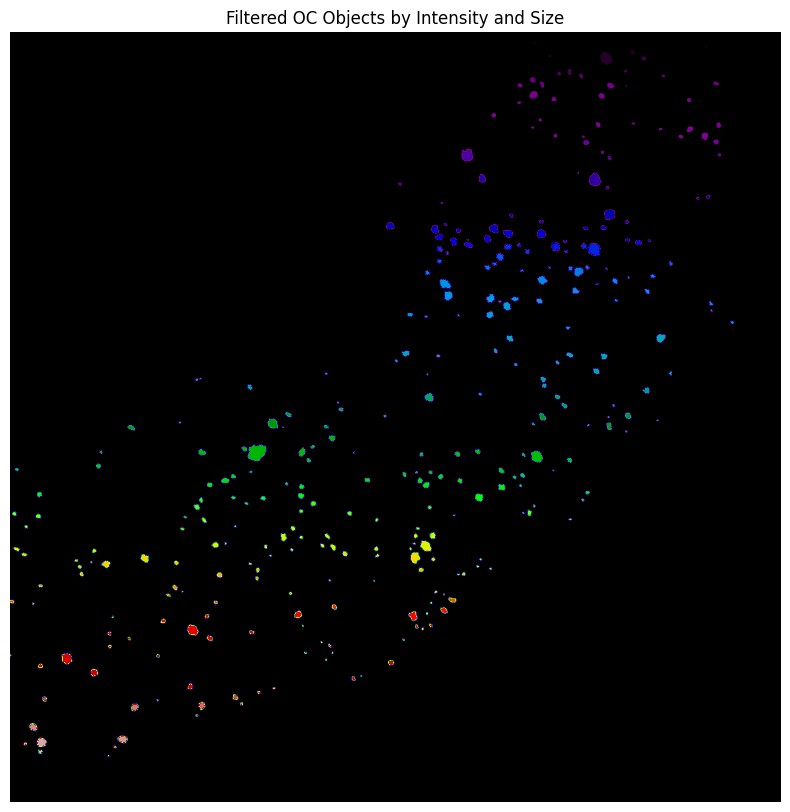

C_1_M04_OC_20x_C_1_M04_OC_HI_080124_20x - C_1_M04_OC_20x.lif (default)__M04_max.tiff


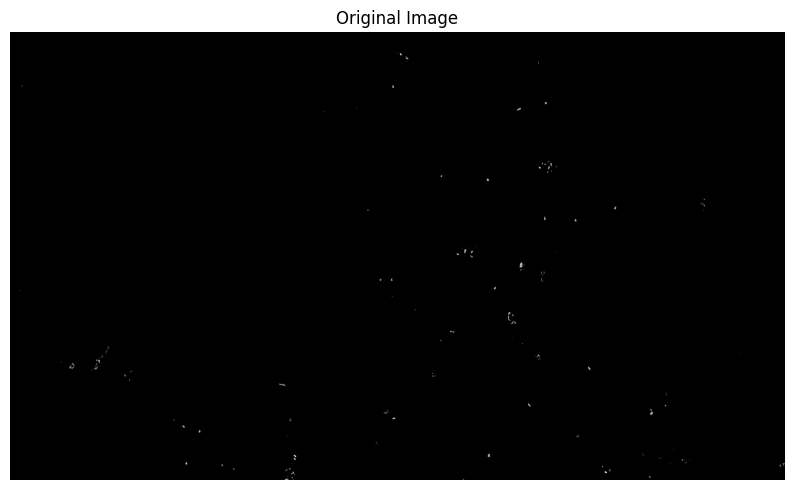

45 circular objects found


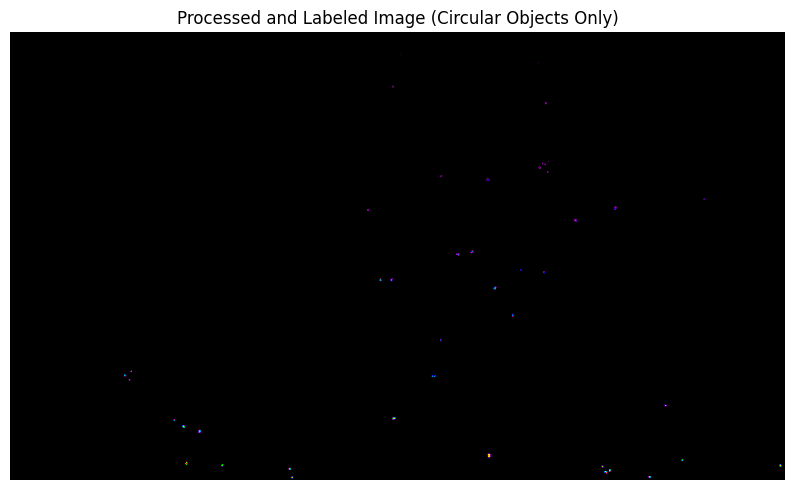

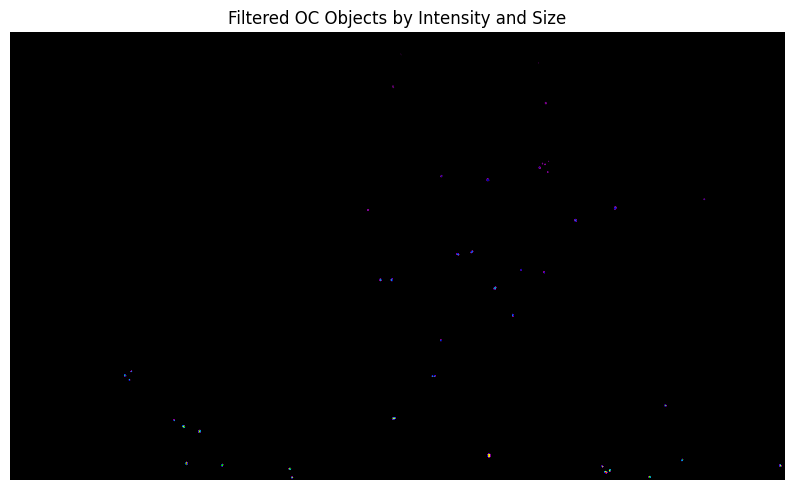

B_3_M04_OC_20x_B_3_M04_OC_HI_230224_20x - B_3_M04_OC_20x.lif (default)__OC_max.tiff


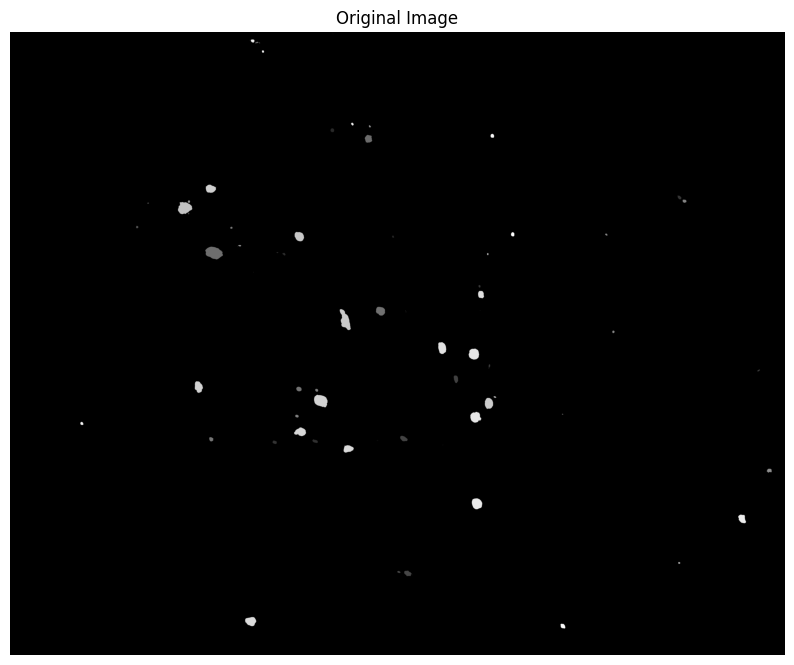

38 circular objects found


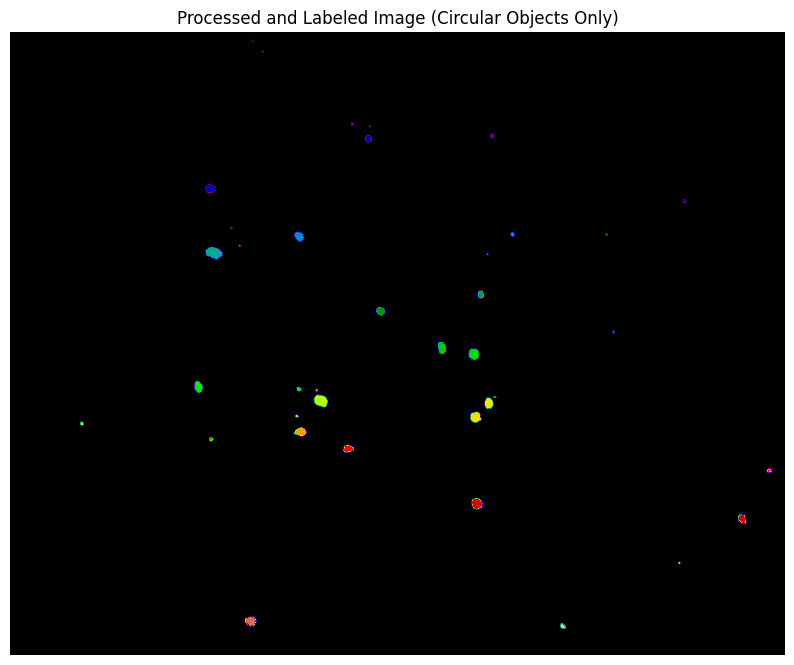

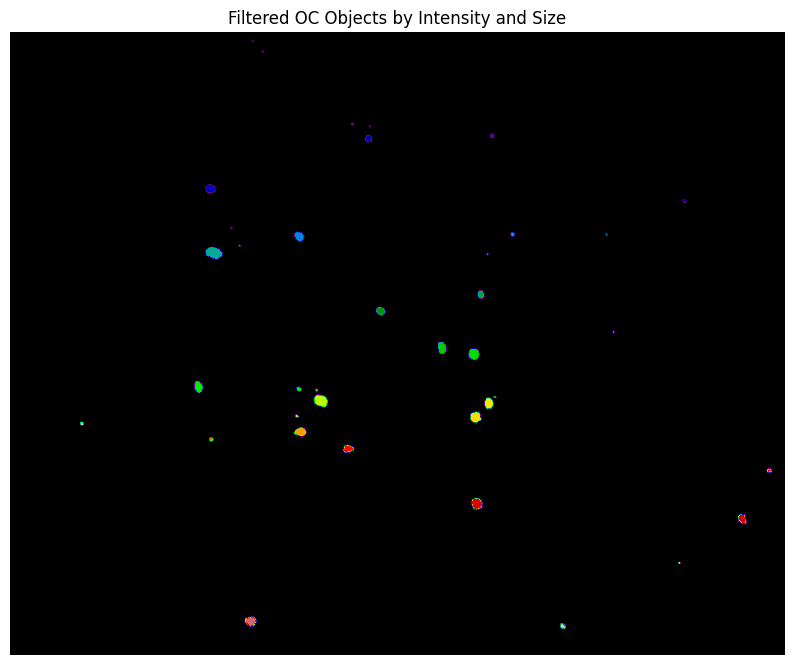

B_3_M04_OC_20x_B_3_M04_OC_SSCTX_230224_20x - B_3_M04_OC_20x.lif__OC_max.tiff


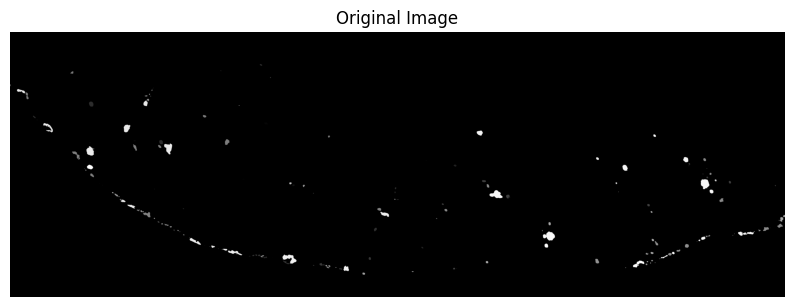

59 circular objects found


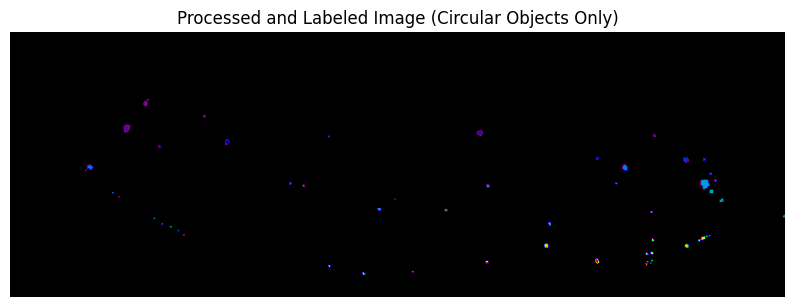

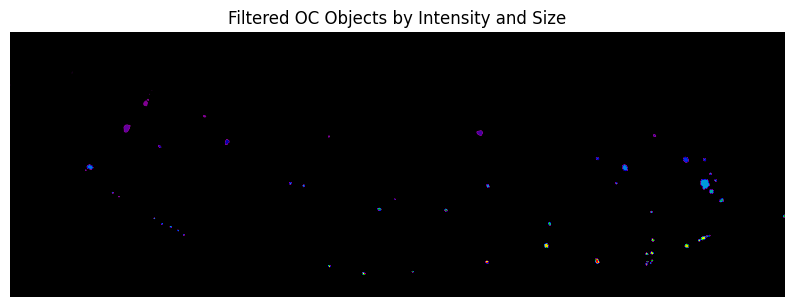

B_2_M04_OC_20x_B_2_M04_OC_SSCTX_220224_20x - B_2_M04_OC_20x.lif__M04_max.tiff


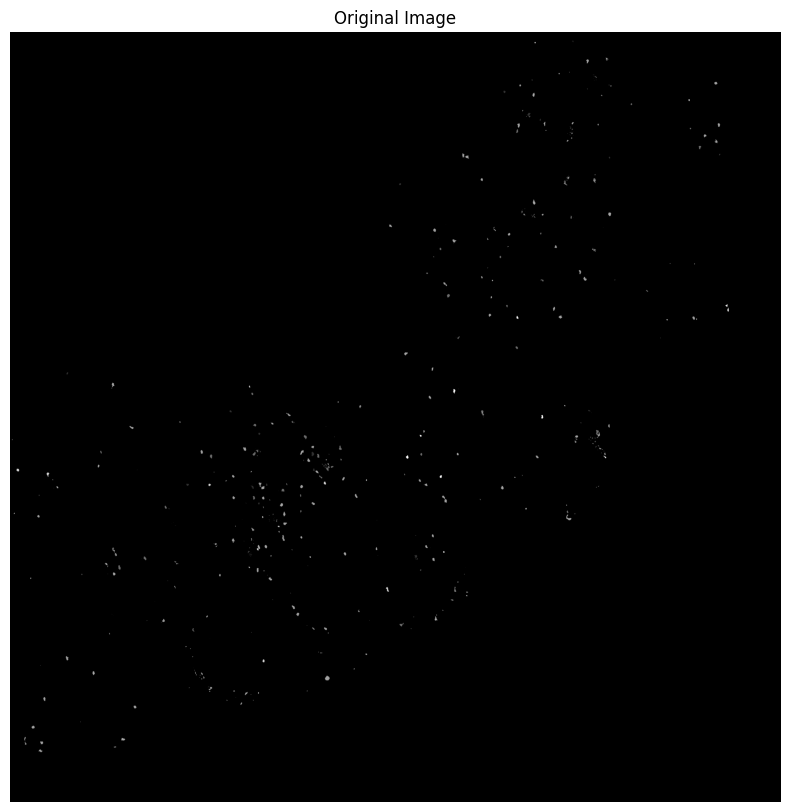

164 circular objects found


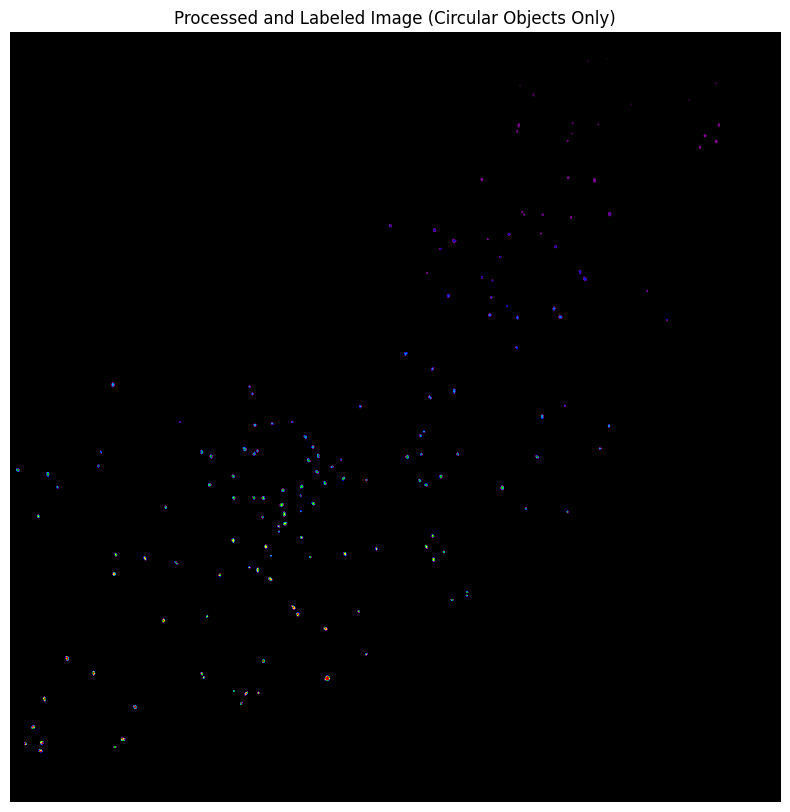

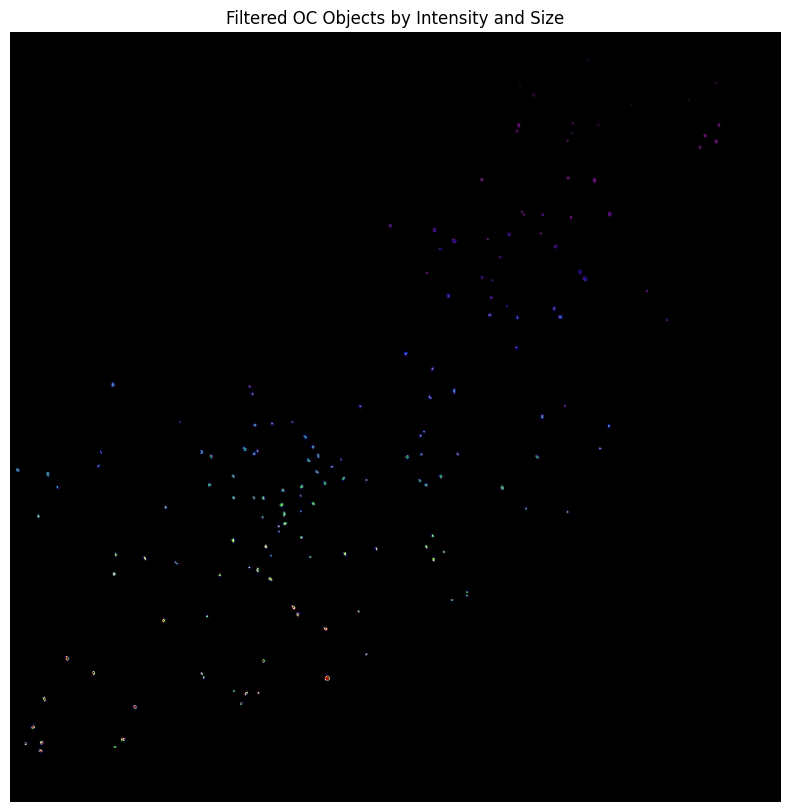

D_3_M04_OC_20x_D_3_M04_OC_HI_080124_20x - D_3_M04_OC_20x.lif (default)__OC_max.tiff


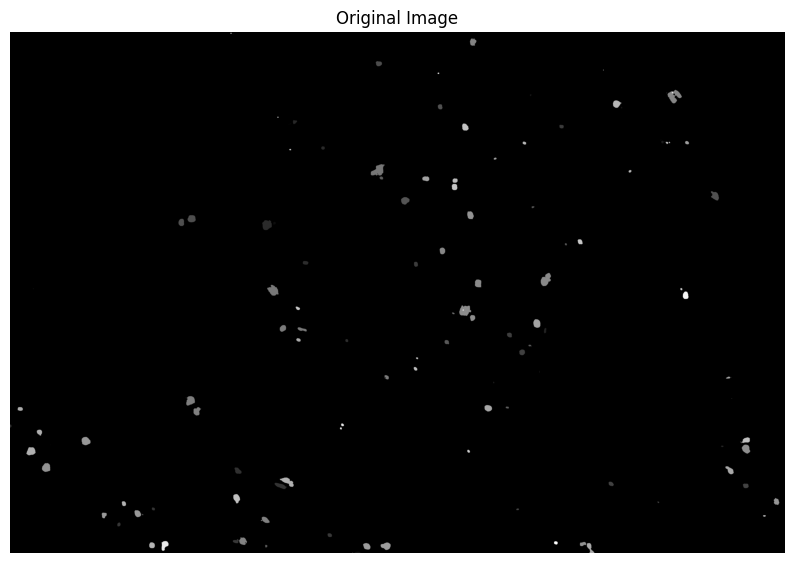

63 circular objects found


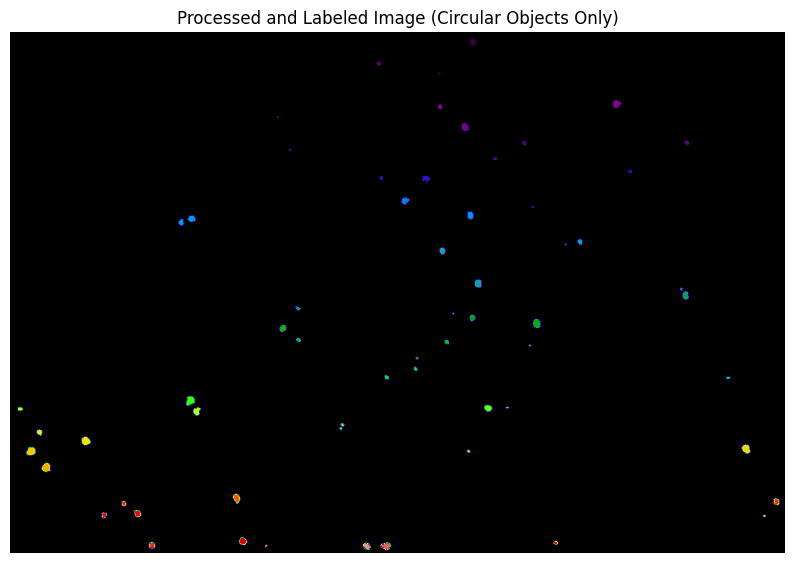

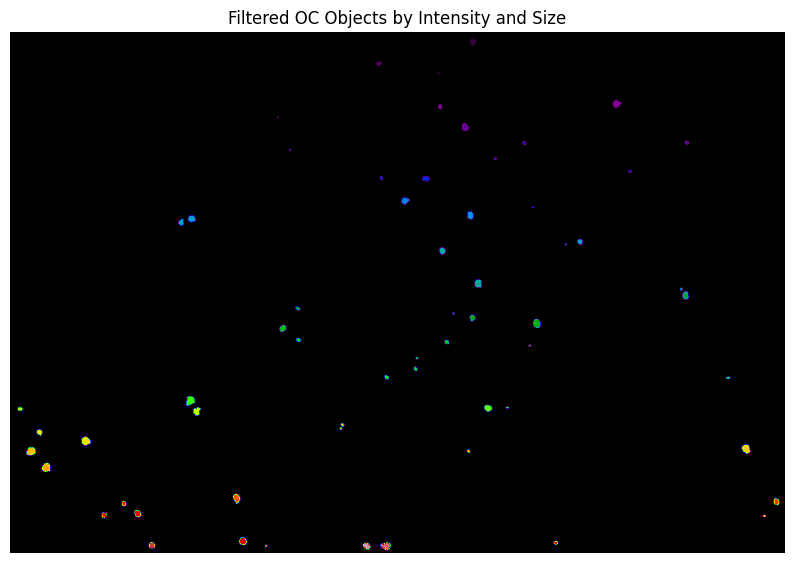

H_1_M04_OC_20x_H_1_M04_OC_SSCTX_220224_20x - H_1_M04_OC_20x.lif (default)__M04_max.tiff


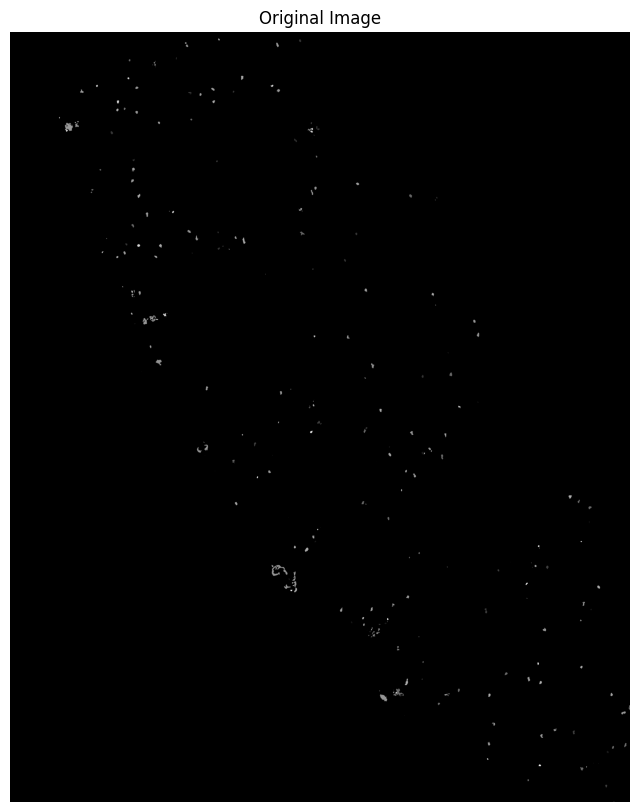

116 circular objects found


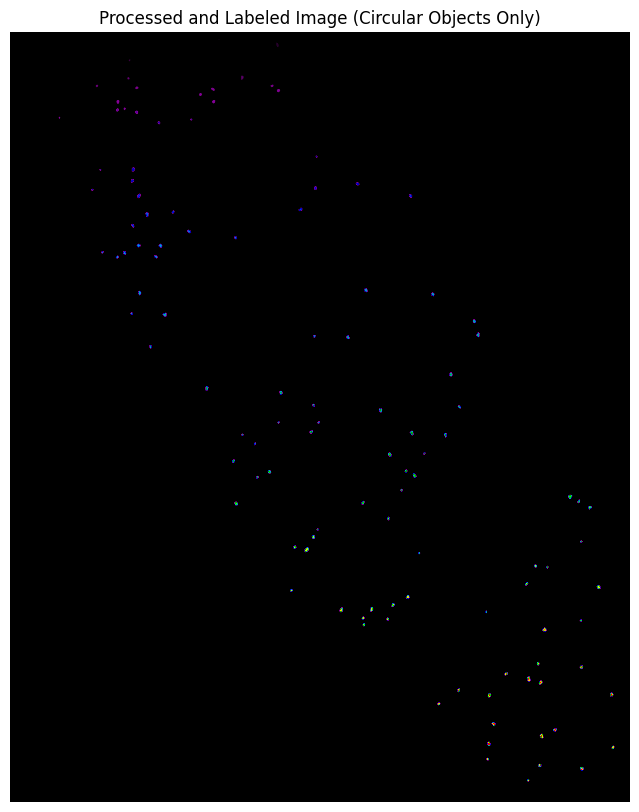

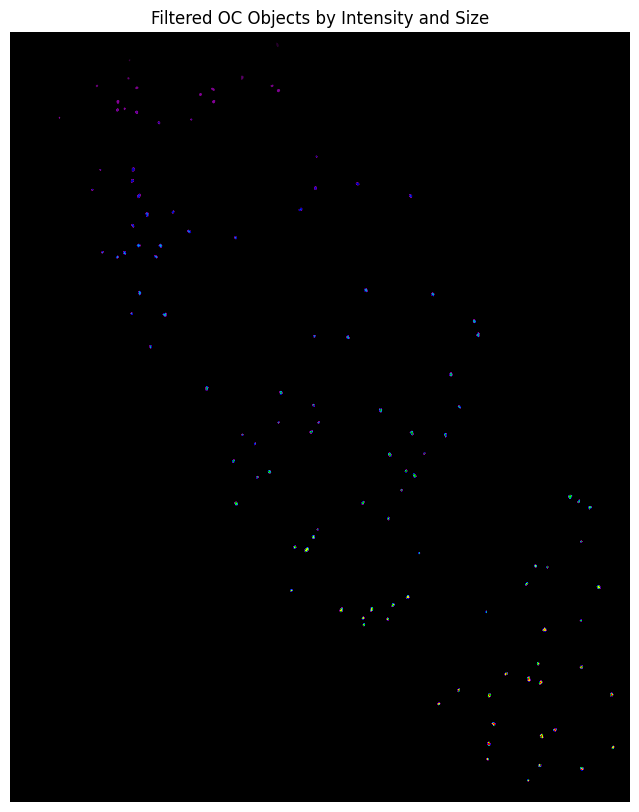

B_3_M04_OC_20x_B_3_M04_OC_SSCTX_230224_20x - B_3_M04_OC_20x.lif__M04_max.tiff


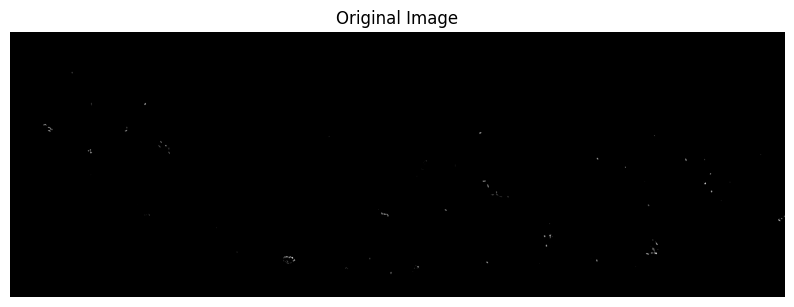

28 circular objects found


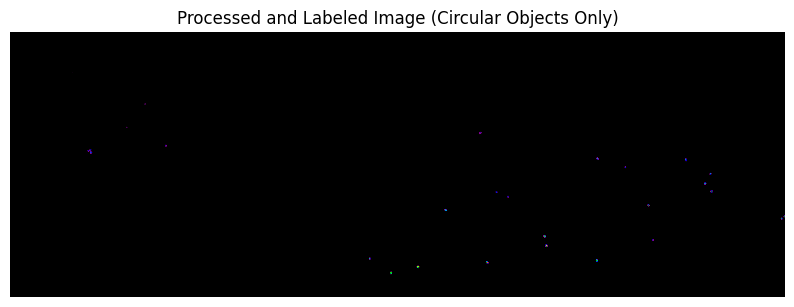

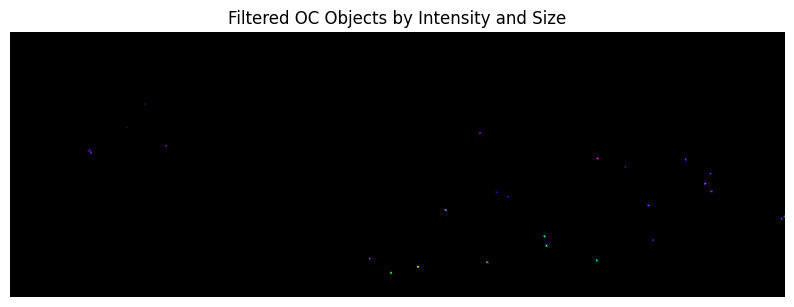

D_3_M04_OC_20x_D_3_M04_OC_SSCTX_080124_20x - D_3_M04_OC_20x.lif__M04_max.tiff


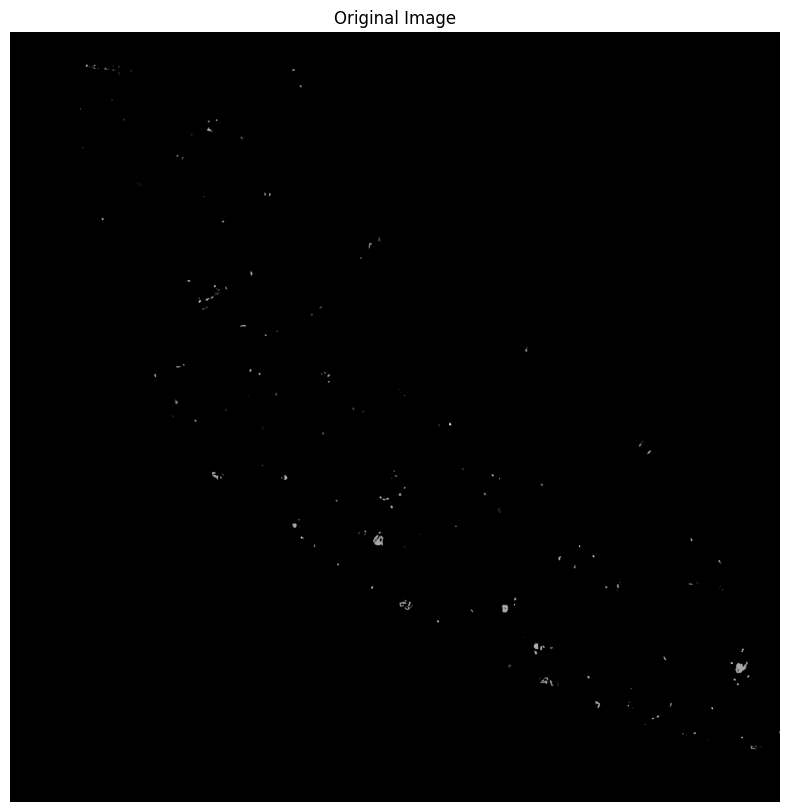

80 circular objects found


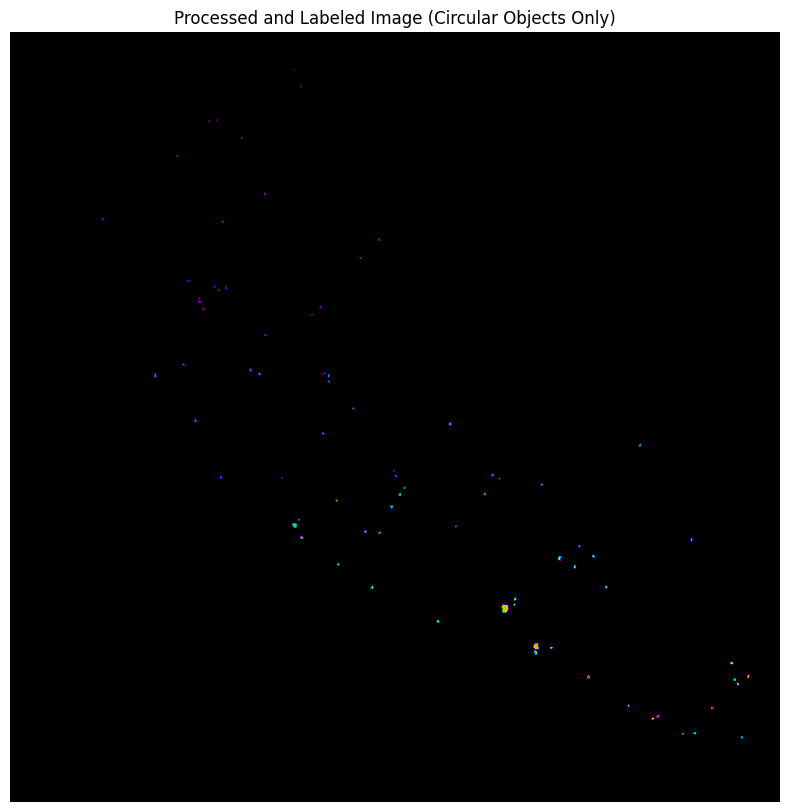

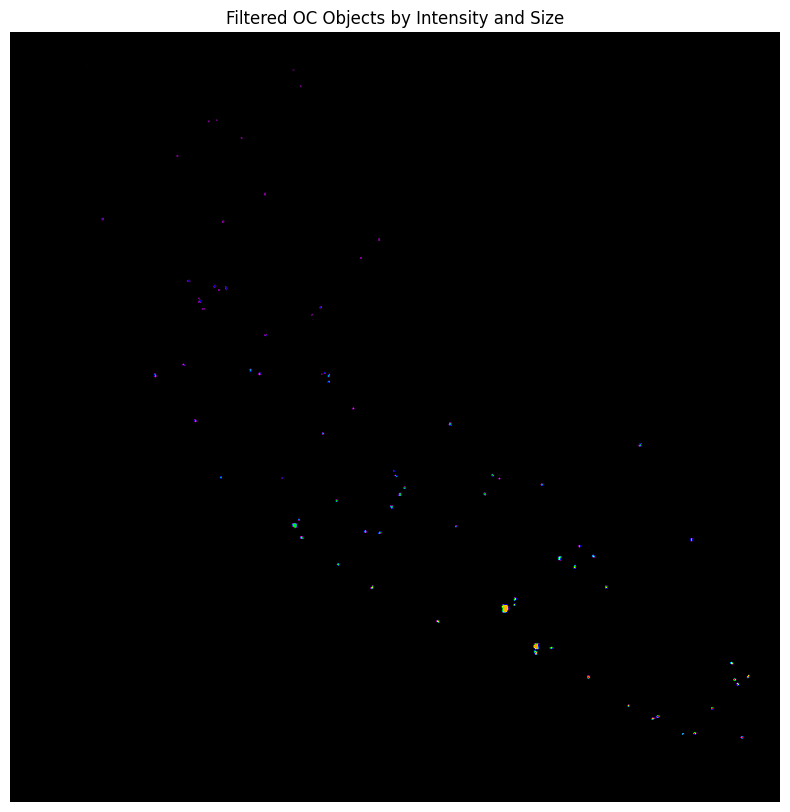

F_1_M04_OC_20x_F_1_M04_OC_HI_090124_20x - F_1_M04_OC_20x.lif__M04_max.tiff


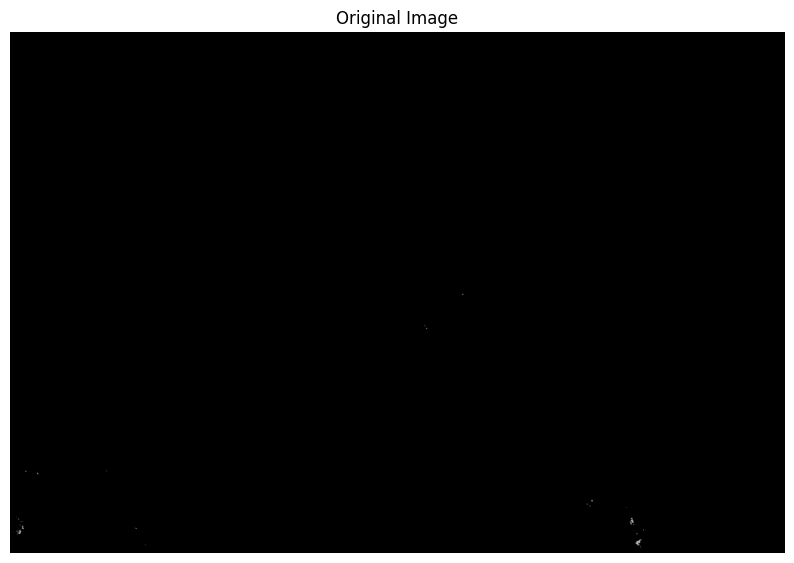

6 circular objects found


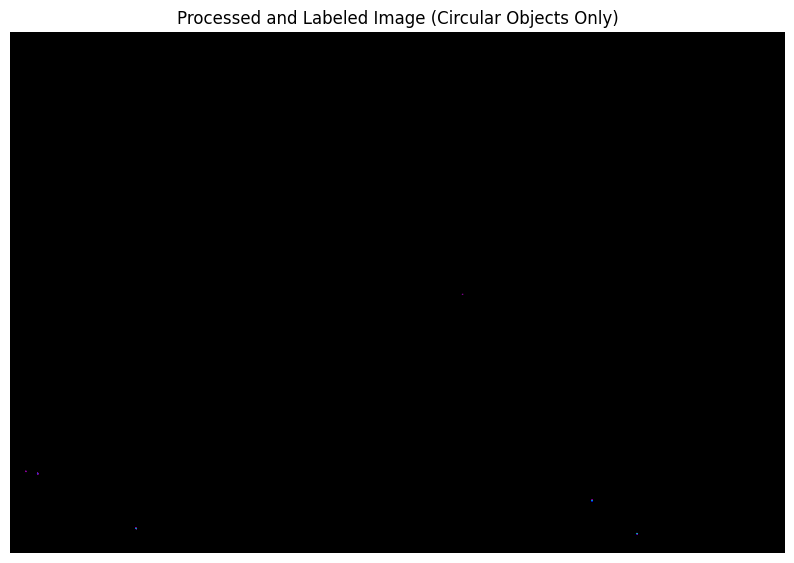

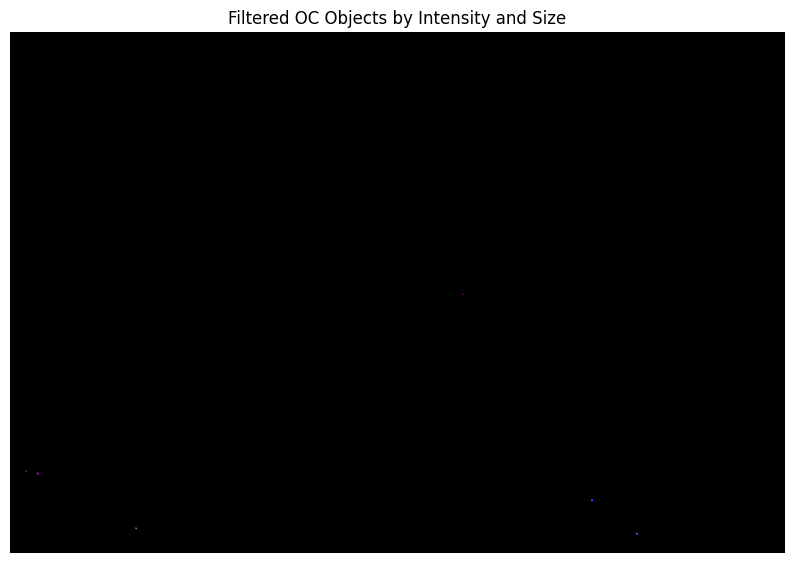

D_4_M04_OC_20x_D_4_M04_OC_SSCTX_090124_20x - D_4_M04_OC_20x.lif__M04_max.tiff


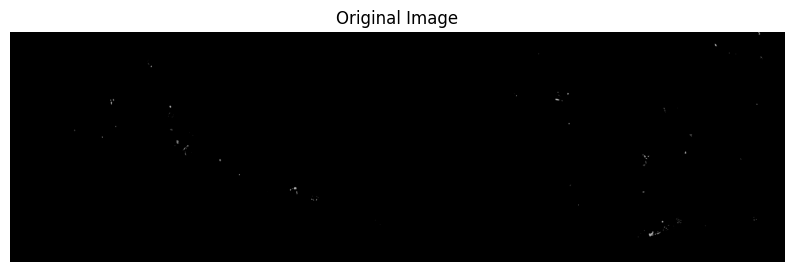

27 circular objects found


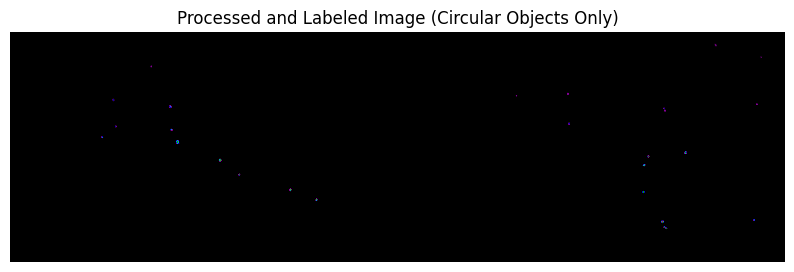

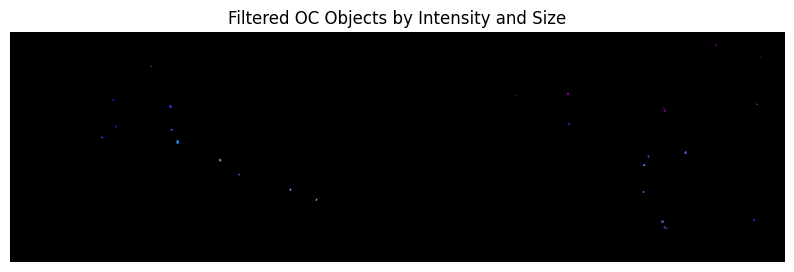

F_1_M04_OC_20x_F_1_M04_OC_SSCTX_090124_20x - F_1_M04_OC_20x.lif__OC_max.tiff


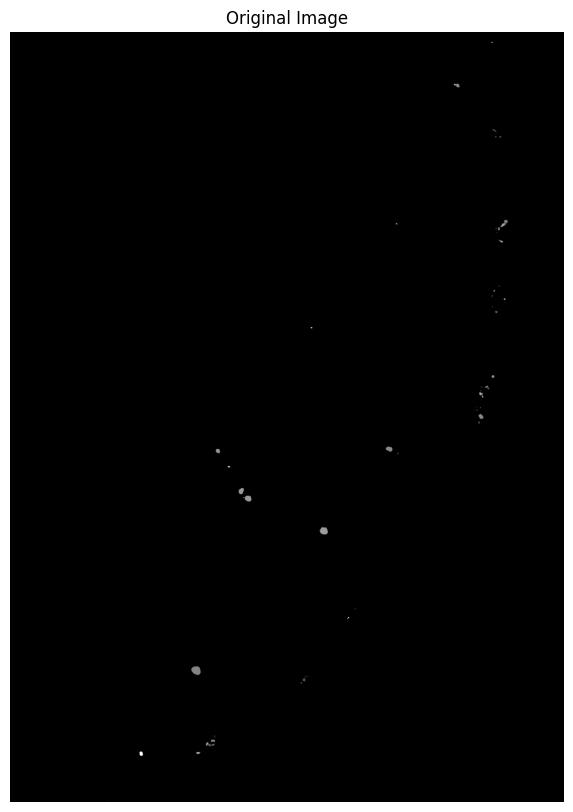

22 circular objects found


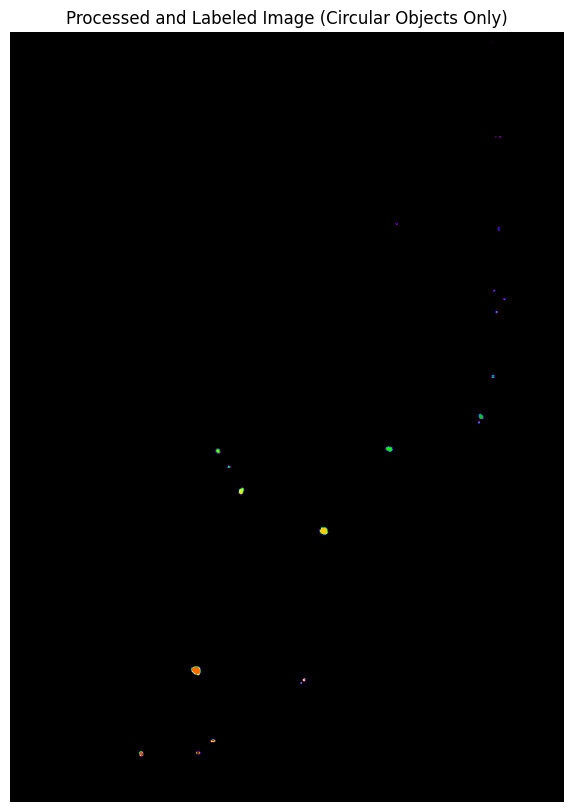

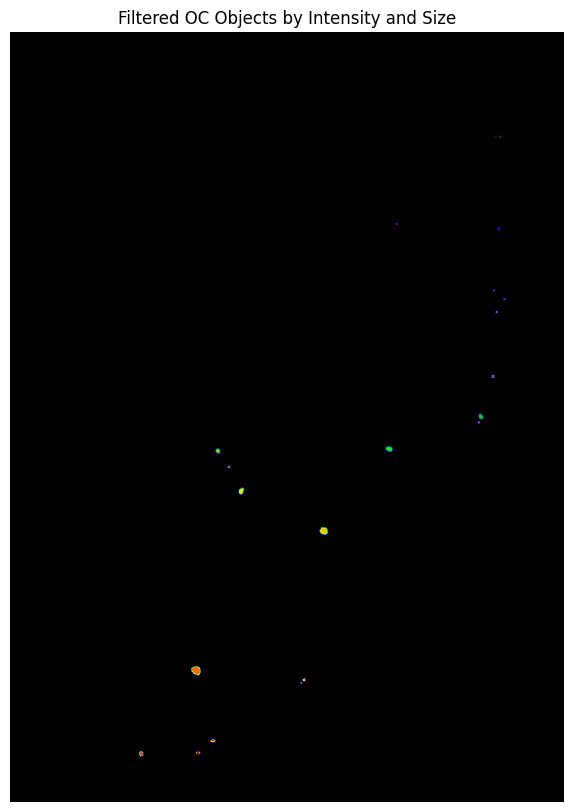

D_3_M04_OC_20x_D_3_M04_OC_SSCTX_080124_20x - D_3_M04_OC_20x.lif__OC_max.tiff


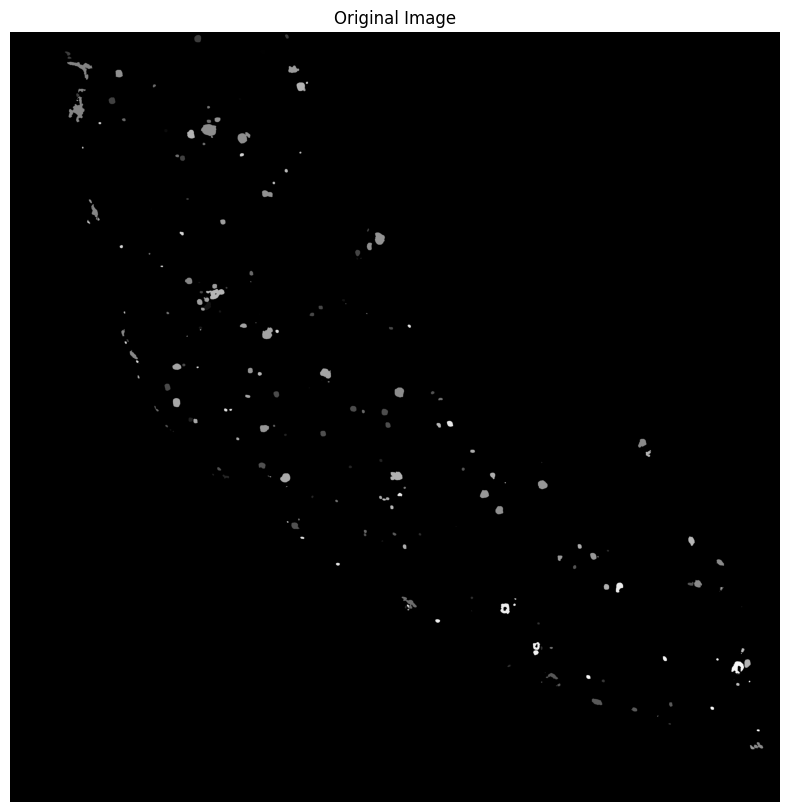

109 circular objects found


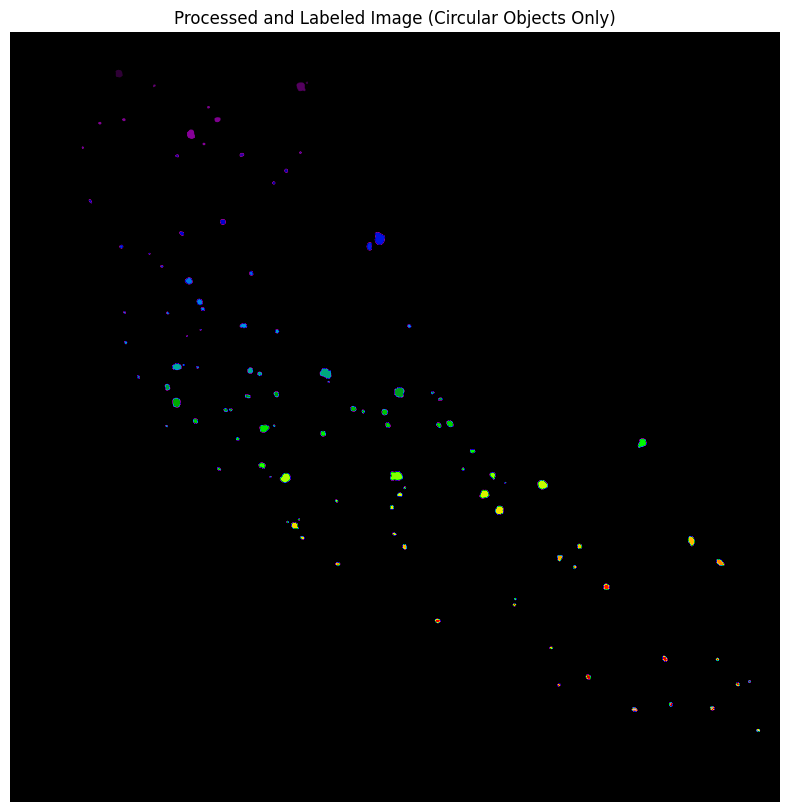

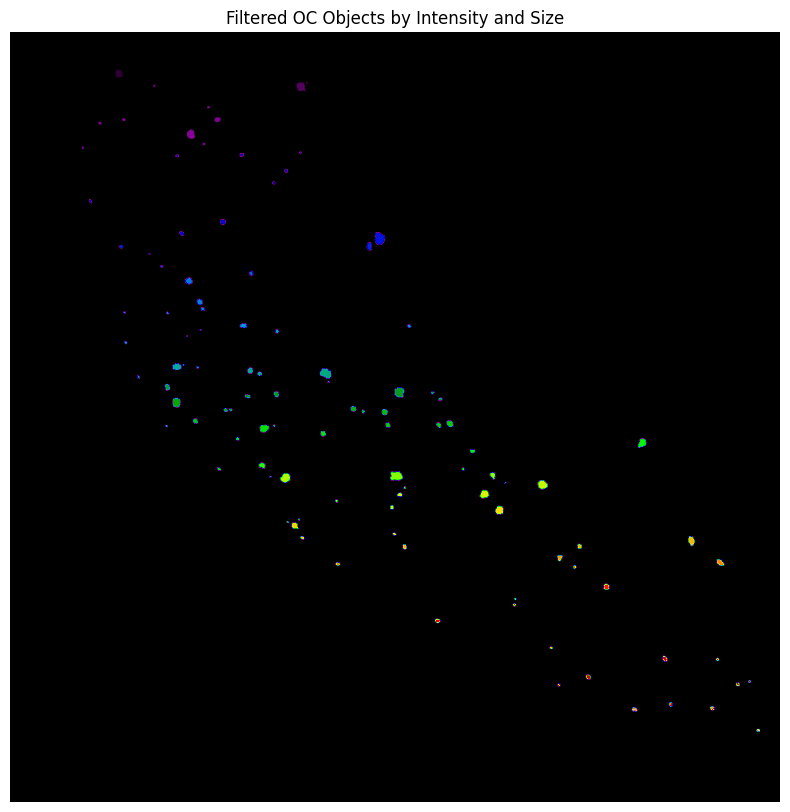

H_3_M04_OC_20x_H_3_M04_OC_HI_210224_20x - H_3_M04_OC_20x.lif__OC_max.tiff


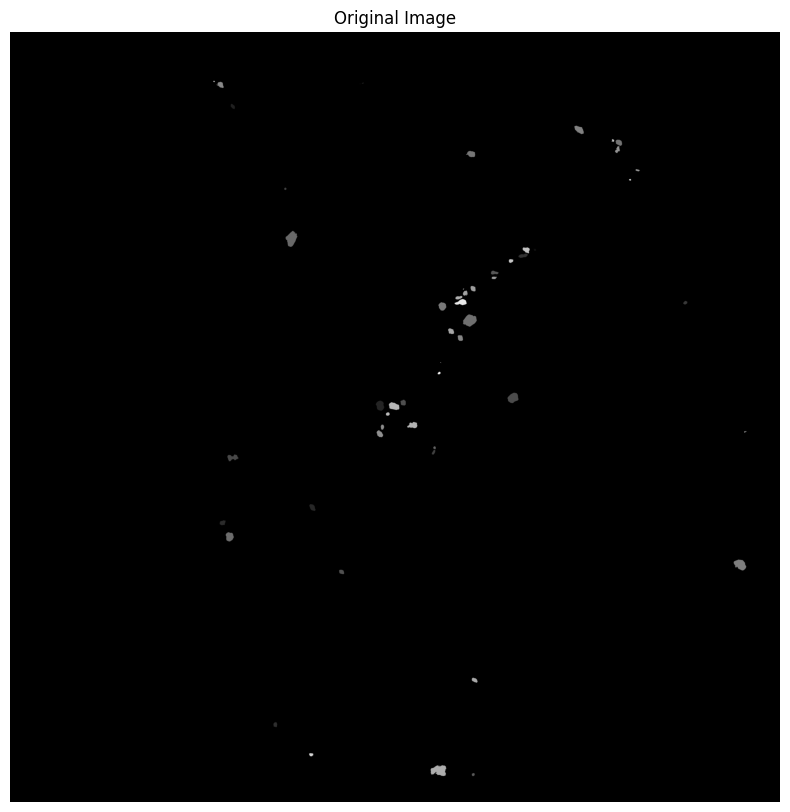

30 circular objects found


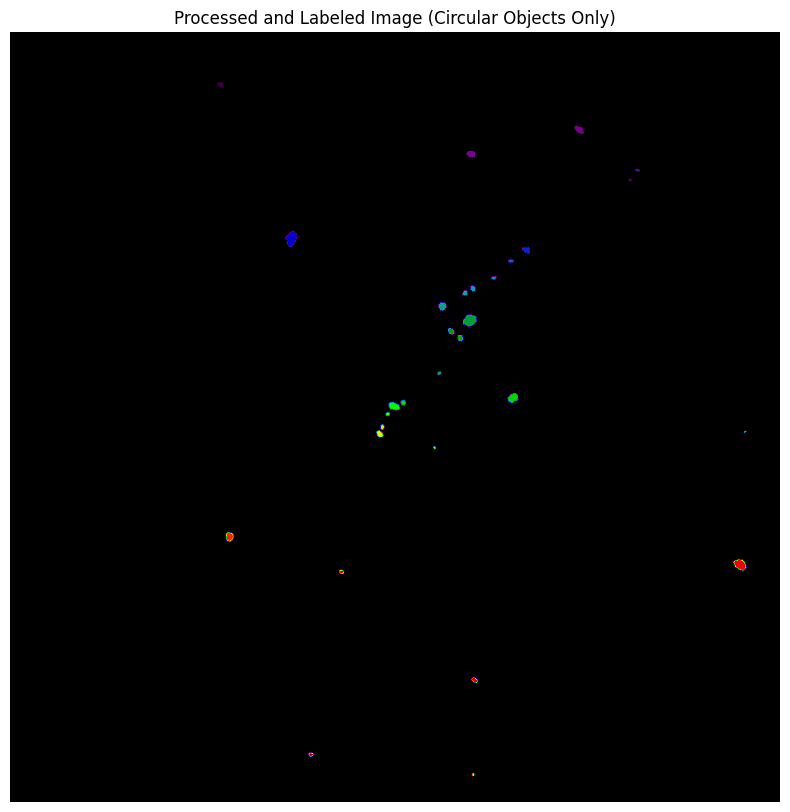

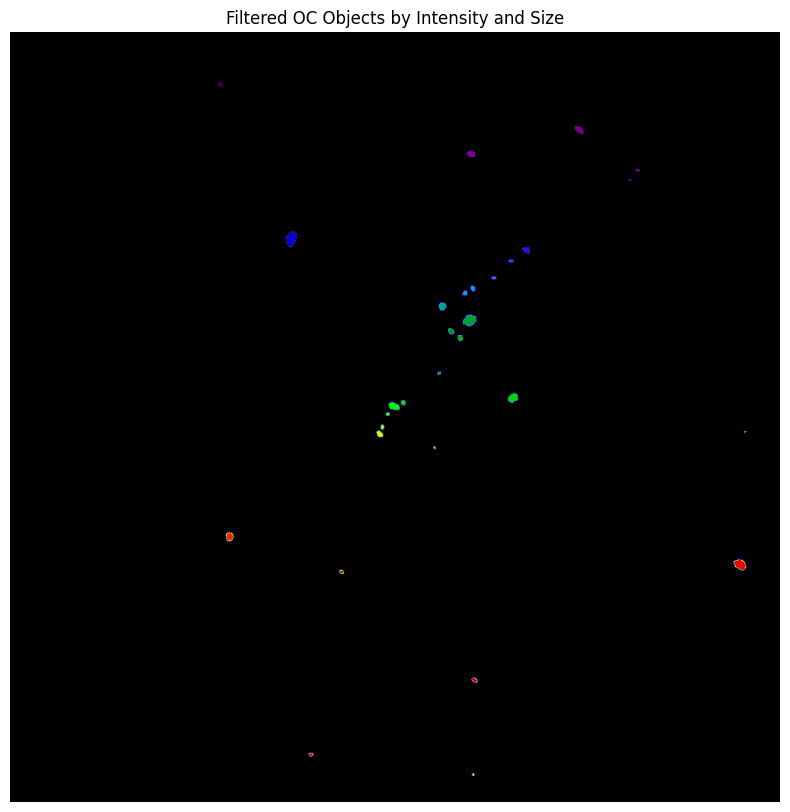

B_4_M04_OC_20x_B_4_M04_OC_HI_230224_20x - B_4_M04_OC_20x.lif (default)__OC_max.tiff


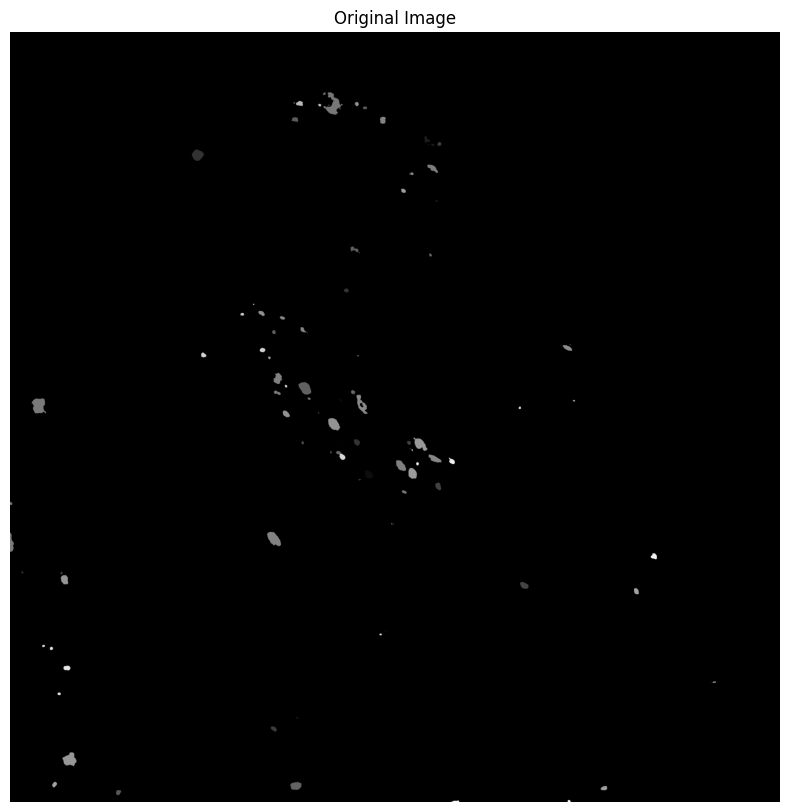

51 circular objects found


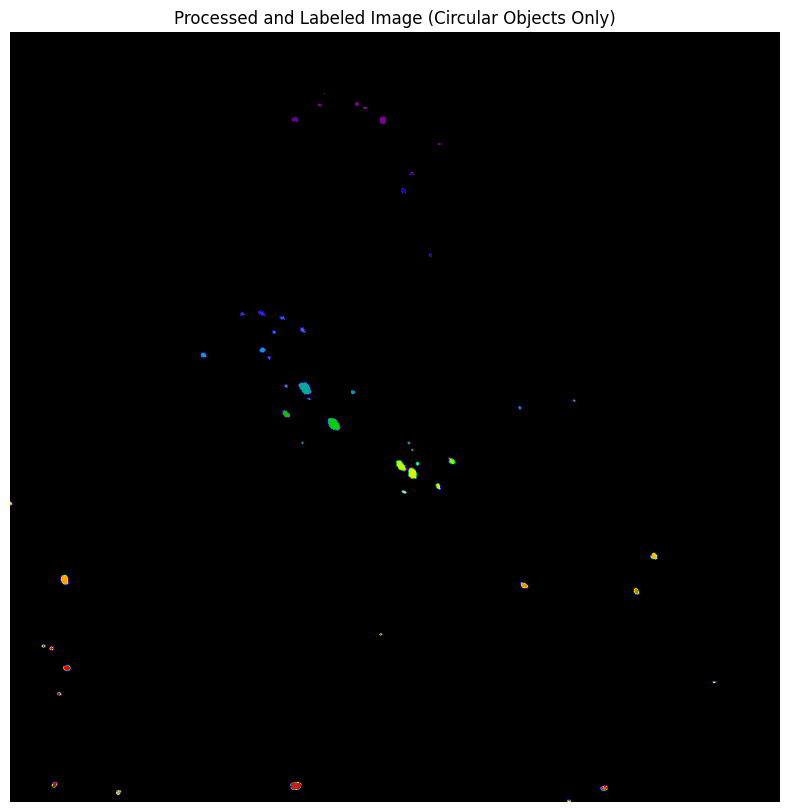

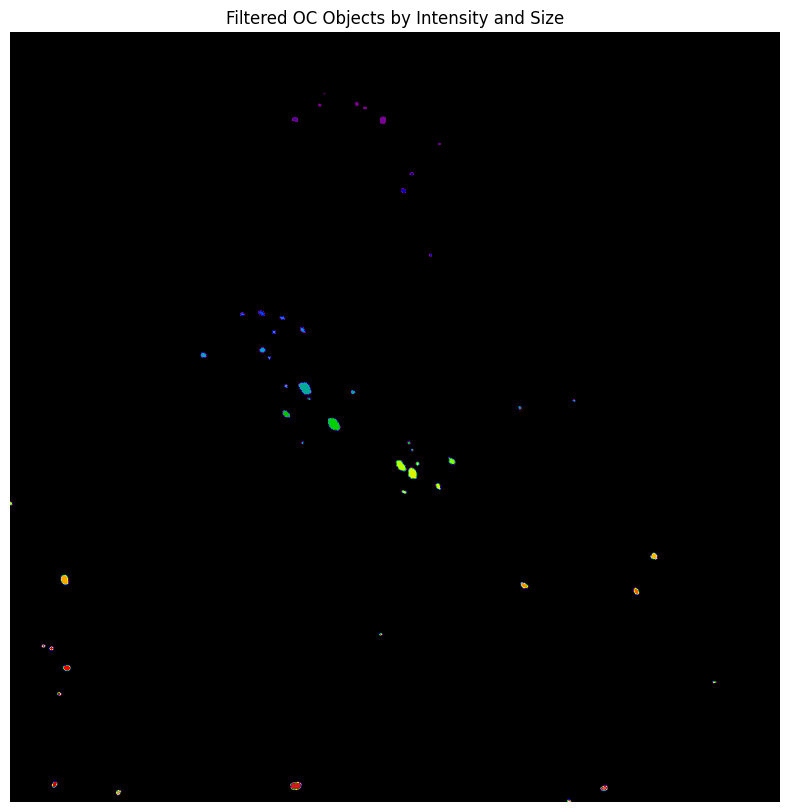

F_1_M04_OC_20x_F_1_M04_OC_SSCTX_090124_20x - F_1_M04_OC_20x.lif__M04_max.tiff


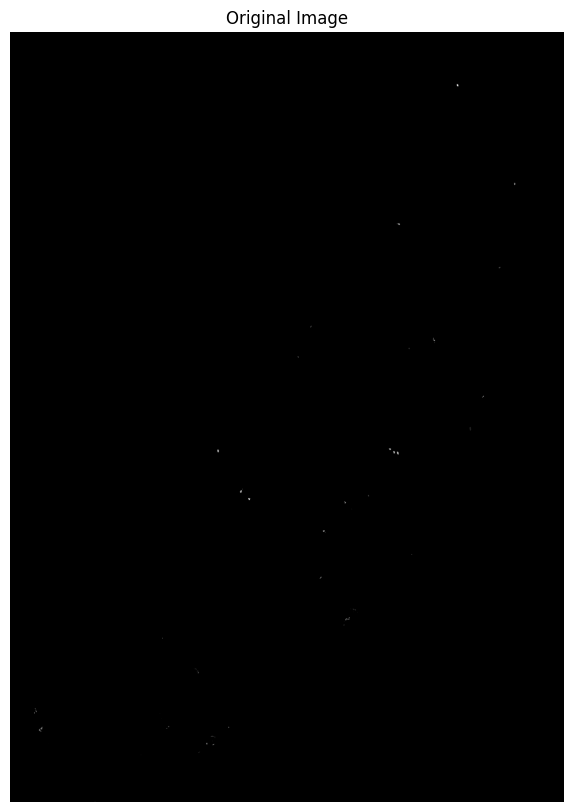

13 circular objects found


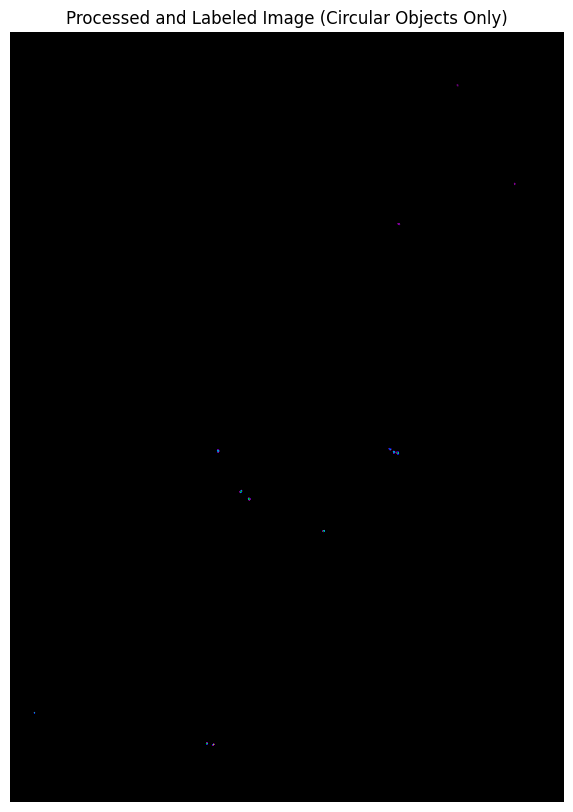

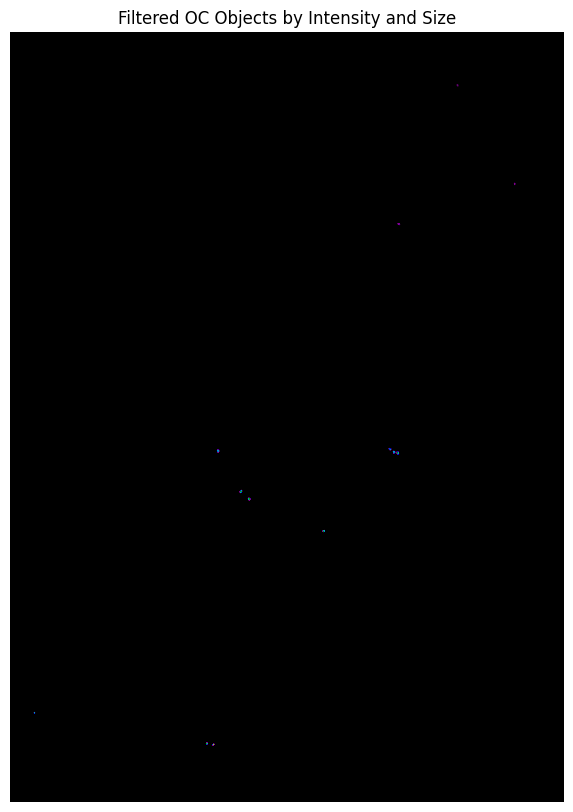

B_4_M04_OC_20x_B_4_M04_OC_SSCTX_230224_20x - B_4_M04_OC_20x.lif__OC_max.tiff


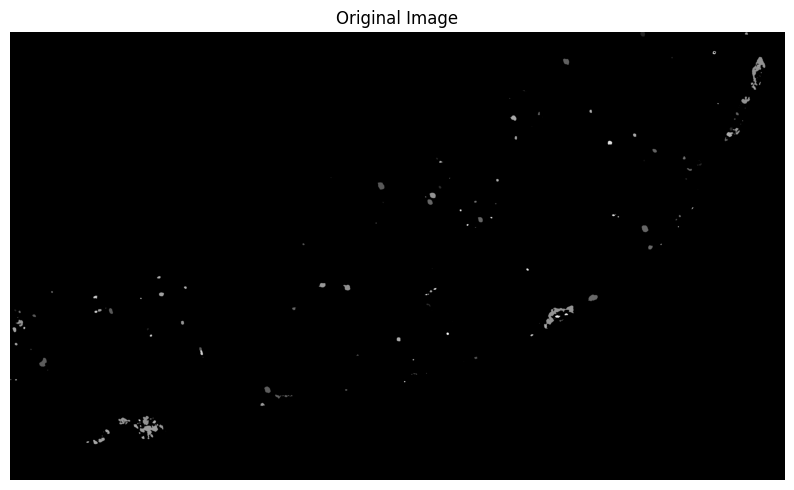

80 circular objects found


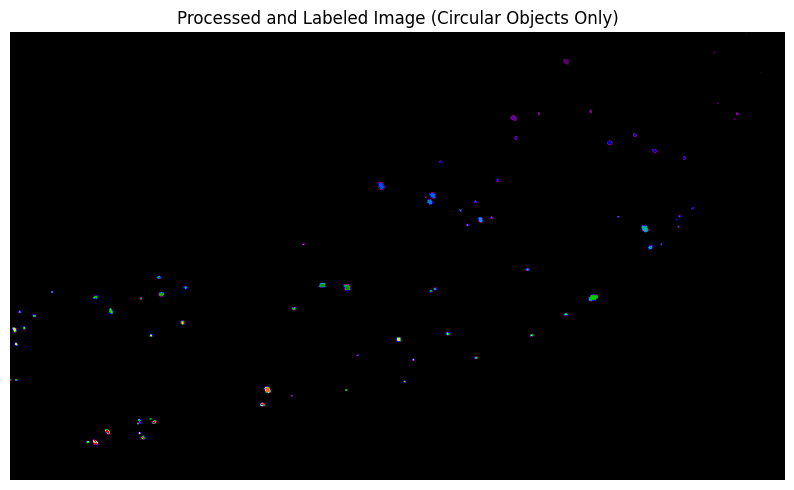

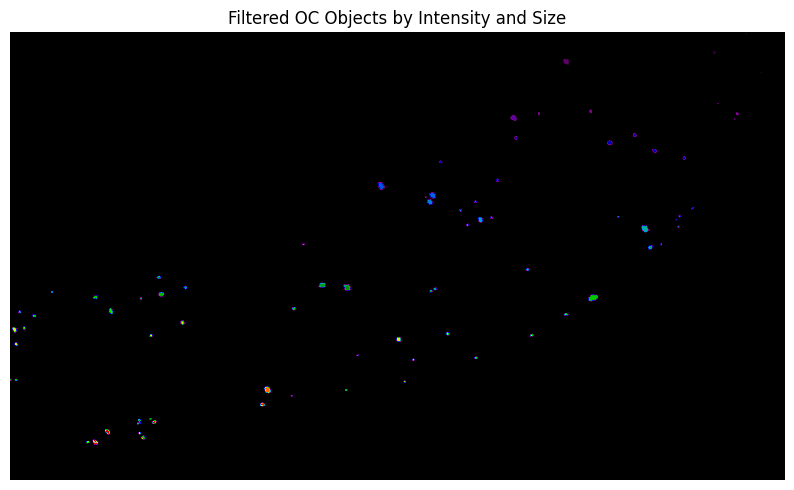

D_3_M04_OC_20x_D_3_M04_OC_HI_080124_20x - D_3_M04_OC_20x.lif (default)__M04_max.tiff


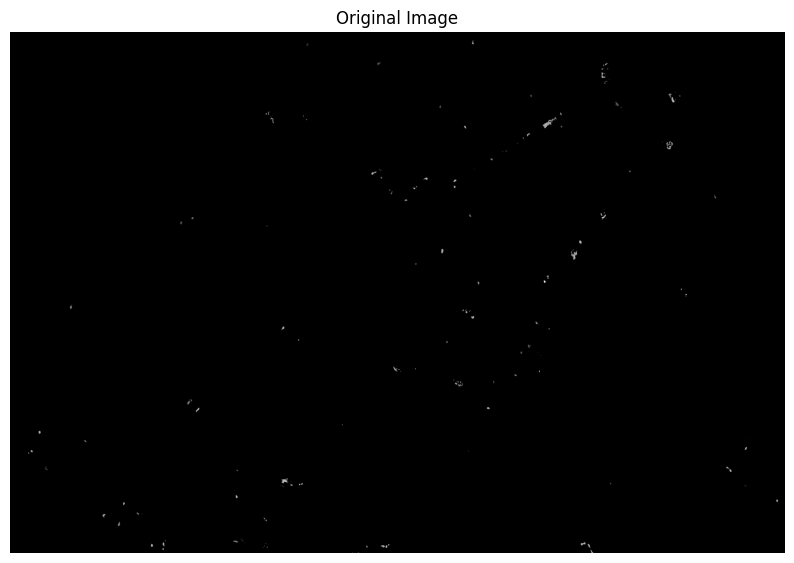

56 circular objects found


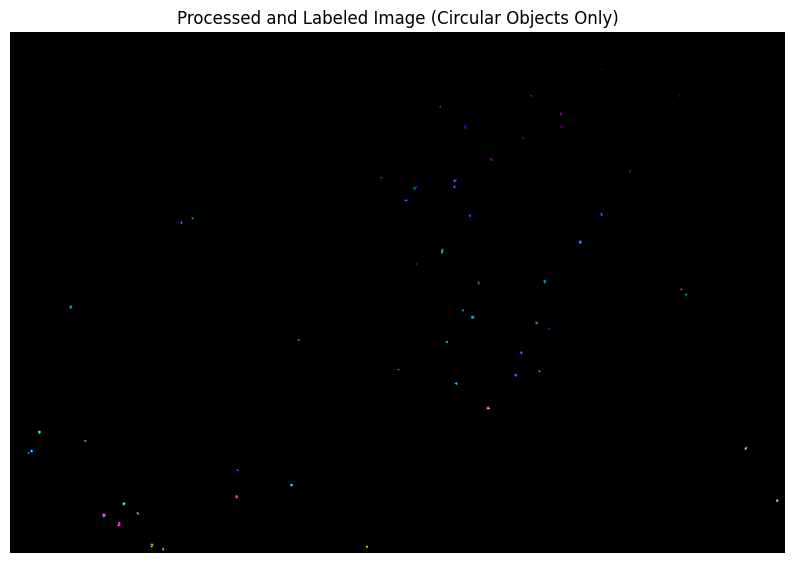

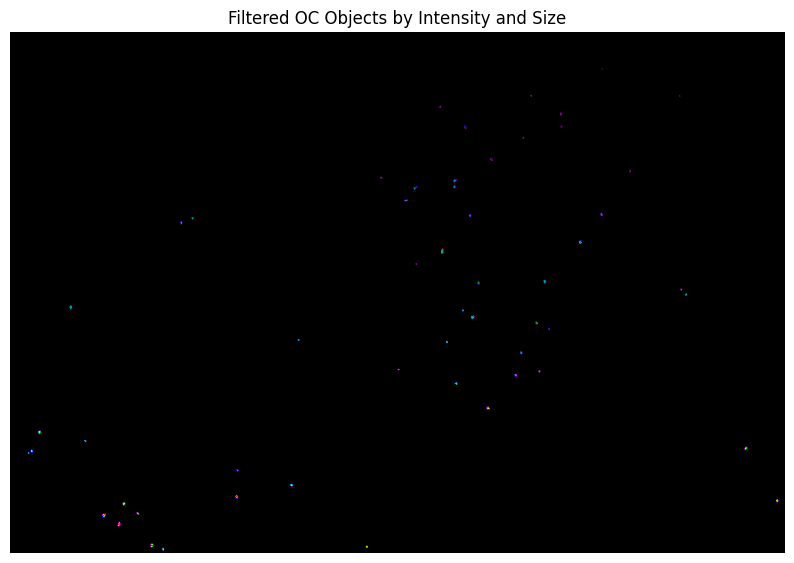

F_1_M04_OC_20x_F_1_M04_OC_HI_090124_20x - F_1_M04_OC_20x.lif__OC_max.tiff


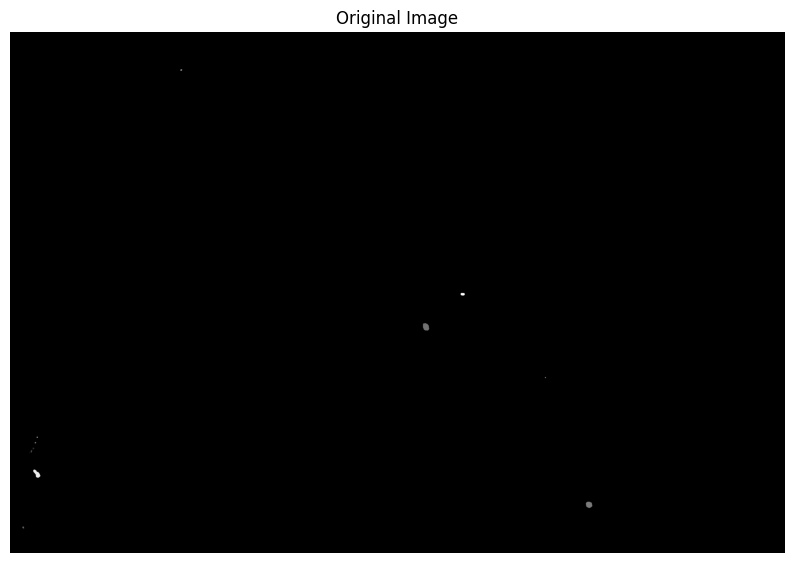

7 circular objects found


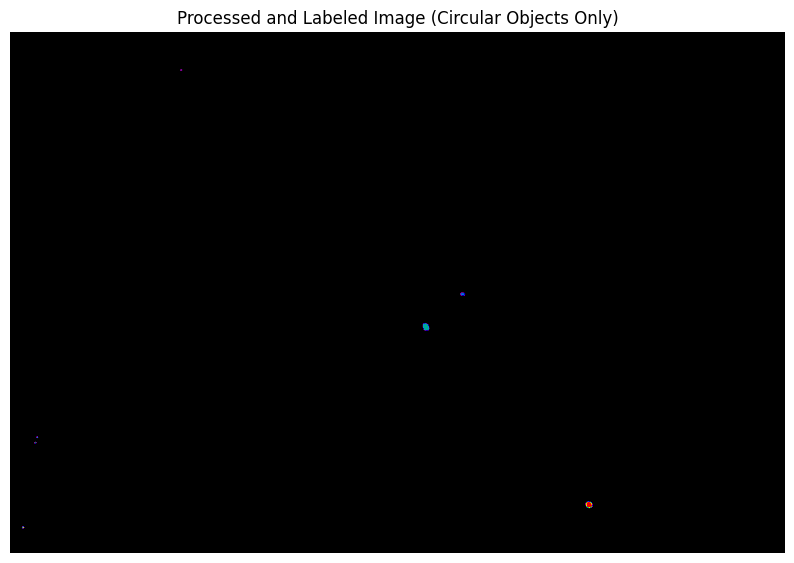

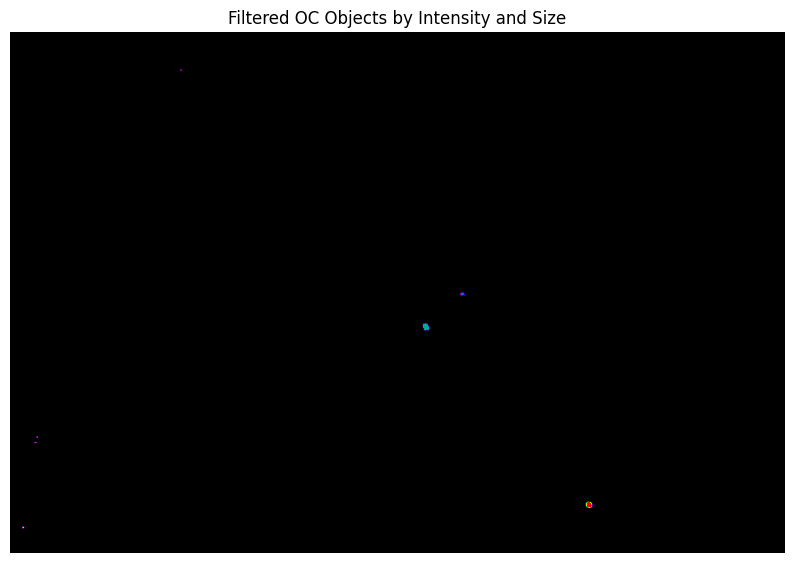

H_3_M04_OC_20x_H_3_M04_OC_HI_210224_20x - H_3_M04_OC_20x.lif__M04_max.tiff


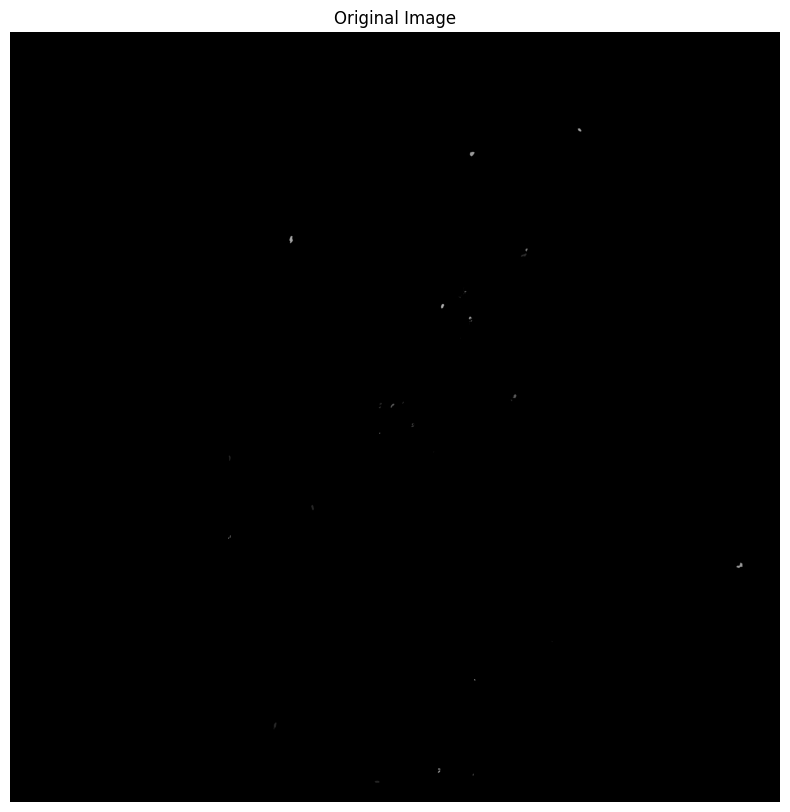

6 circular objects found


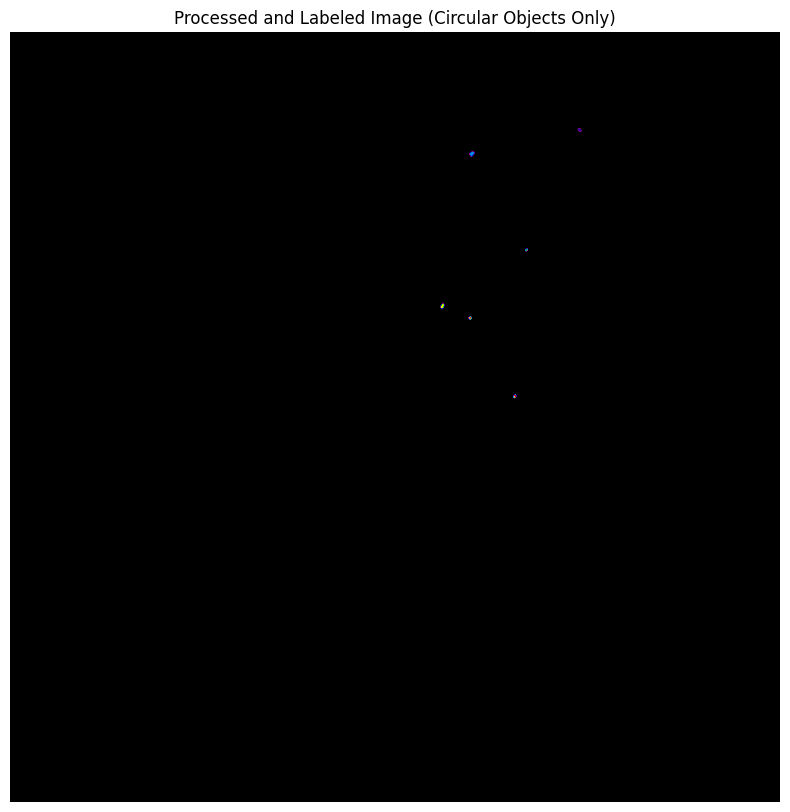

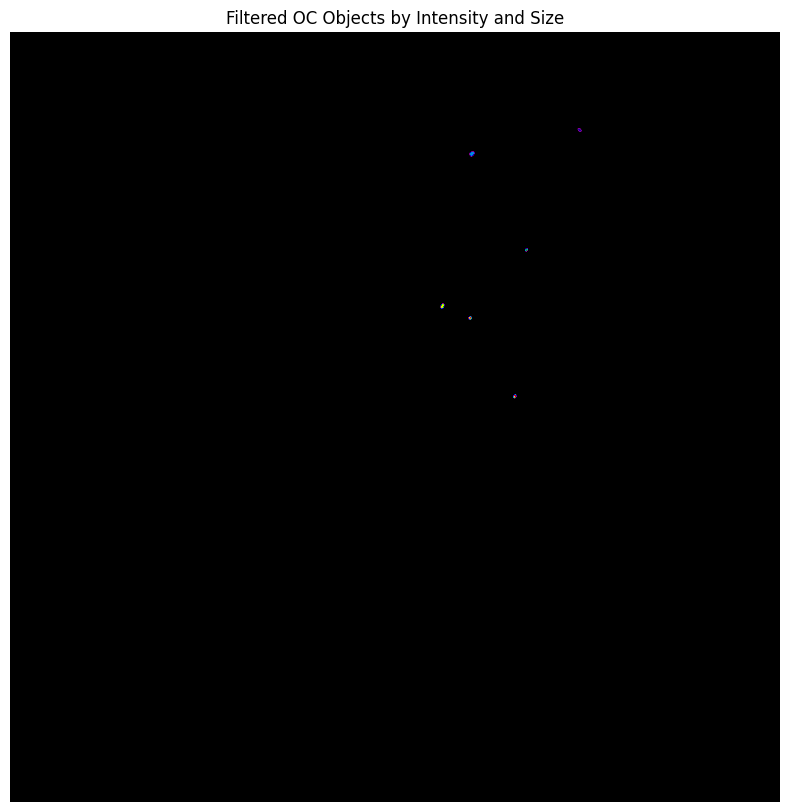

D_4_M04_OC_20x_D_4_M04_OC_HI_090124_20x - D_4_M04_OC_20x.lif (default)__M04_max.tiff


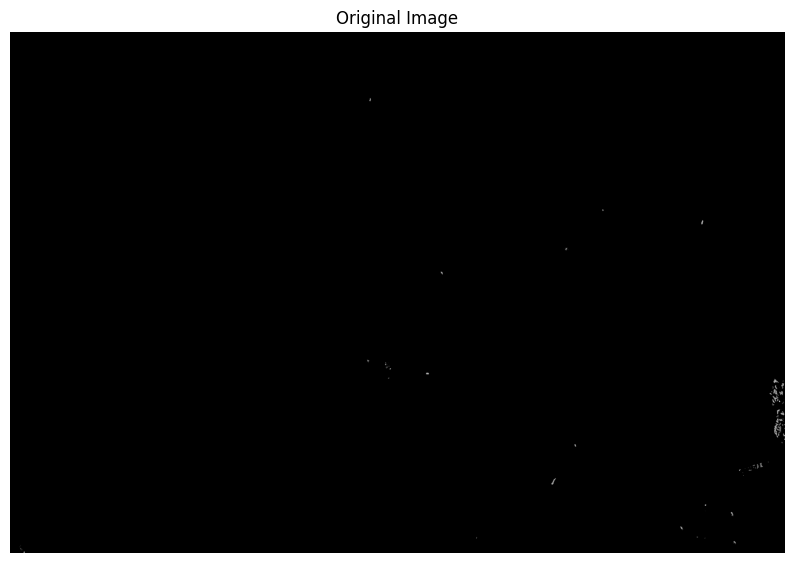

15 circular objects found


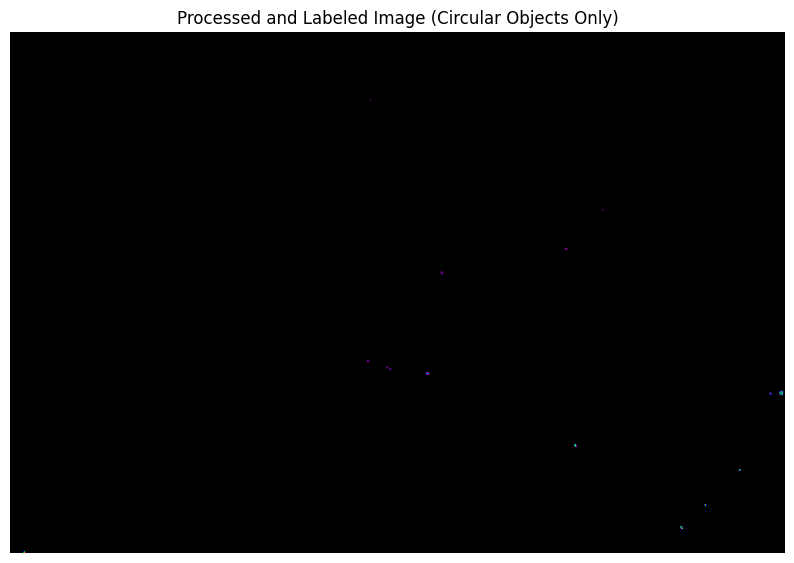

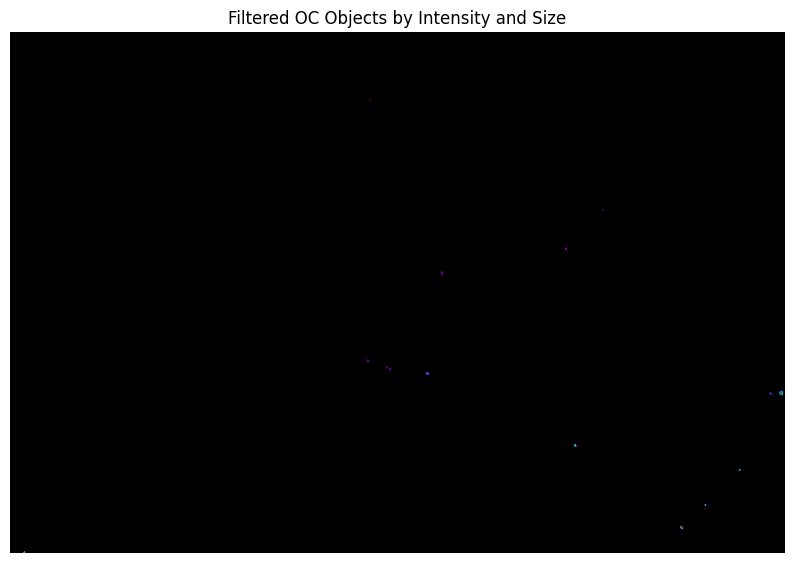

A_4_M04_OC_20x_A_4_M04_OC_HI_220224_20x - A_4_M04_OC_20x.lif__OC_max.tiff


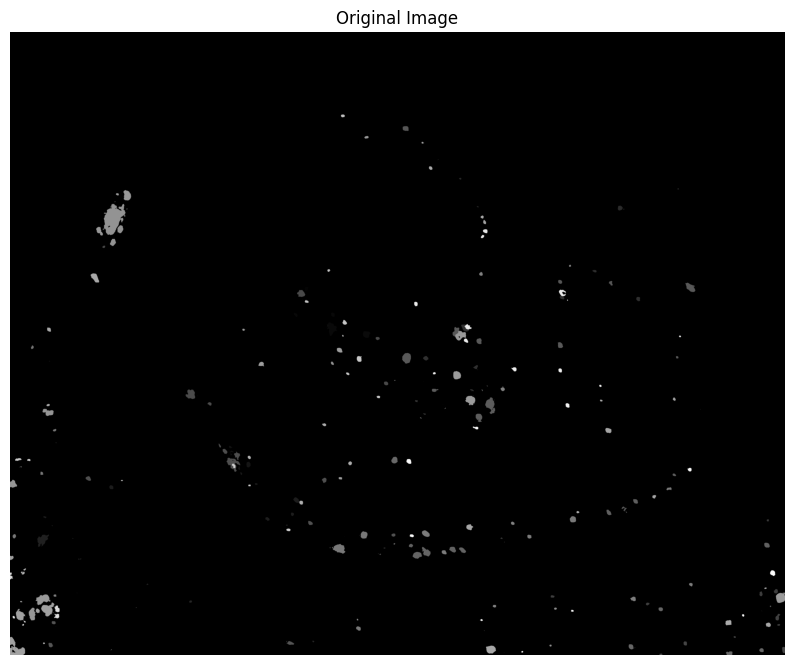

122 circular objects found


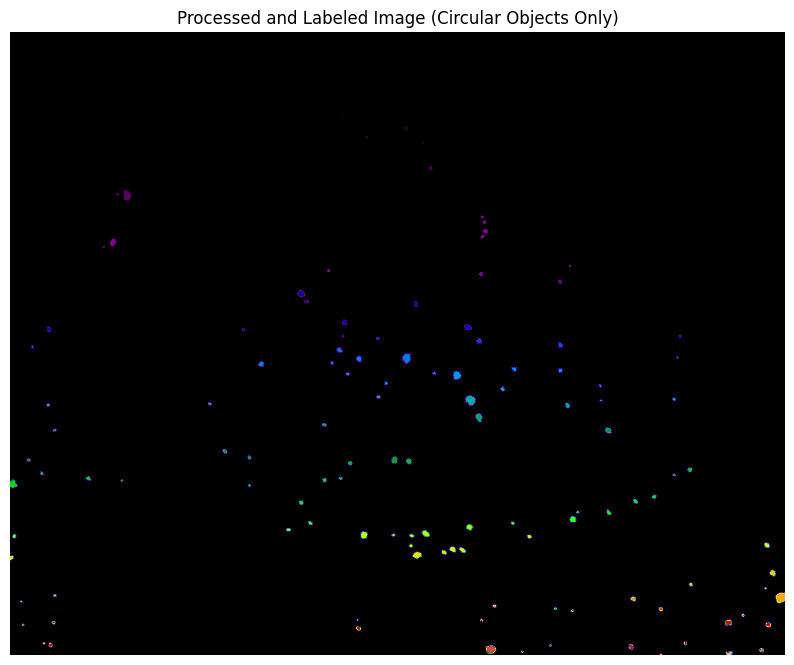

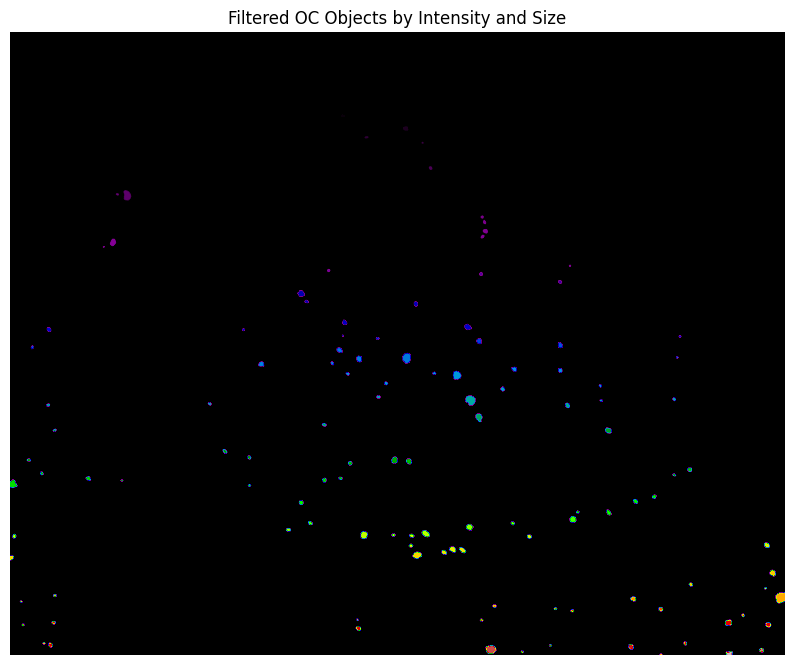

D_4_M04_OC_20x (2)_D_4_M04_OC_HI_090124_20x - D_4_M04_OC_20x.lif (default)__OC_max.tiff


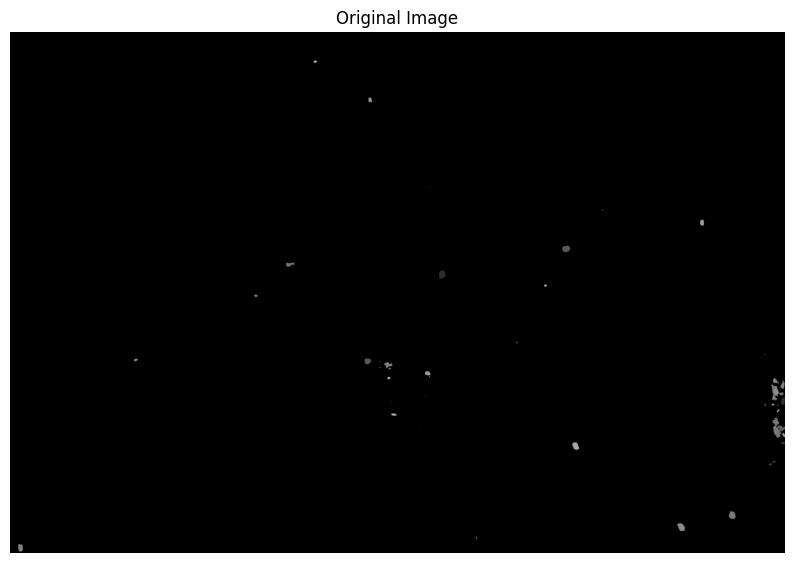

17 circular objects found


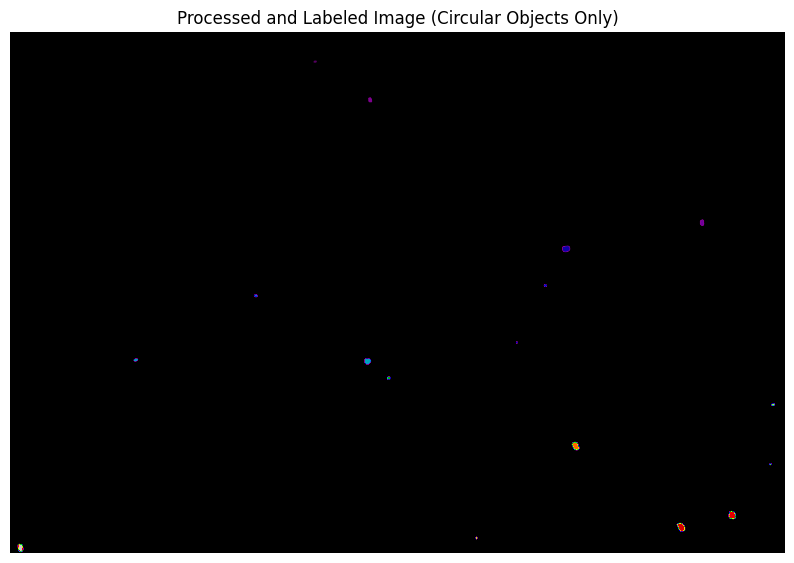

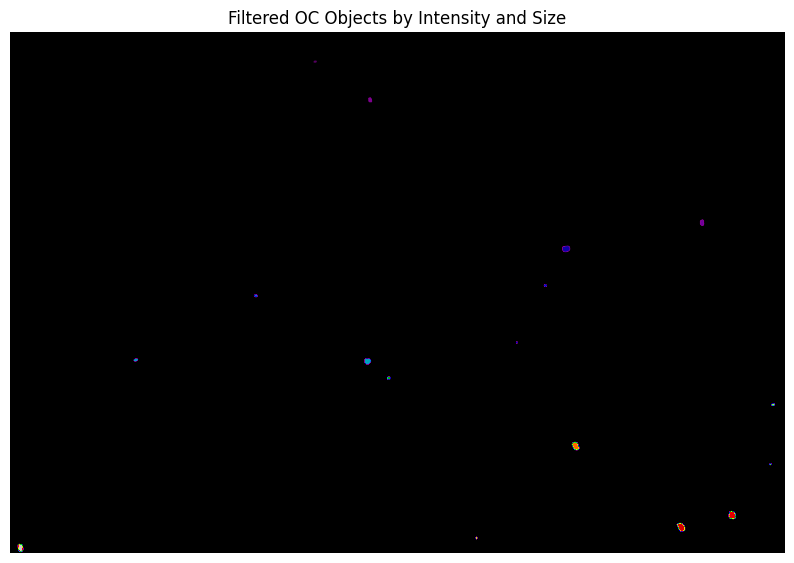

C_2_M04_OC_20x_C_2_M04_OC_SSCTX_080124_20x - C_2_M04_OC_20x.lif__M04_max.tiff


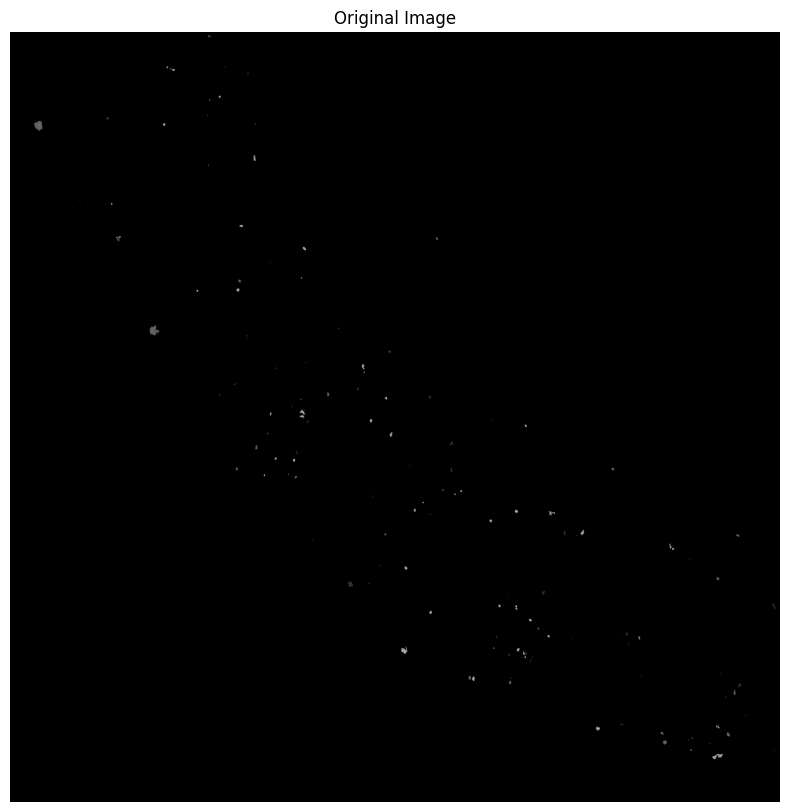

51 circular objects found


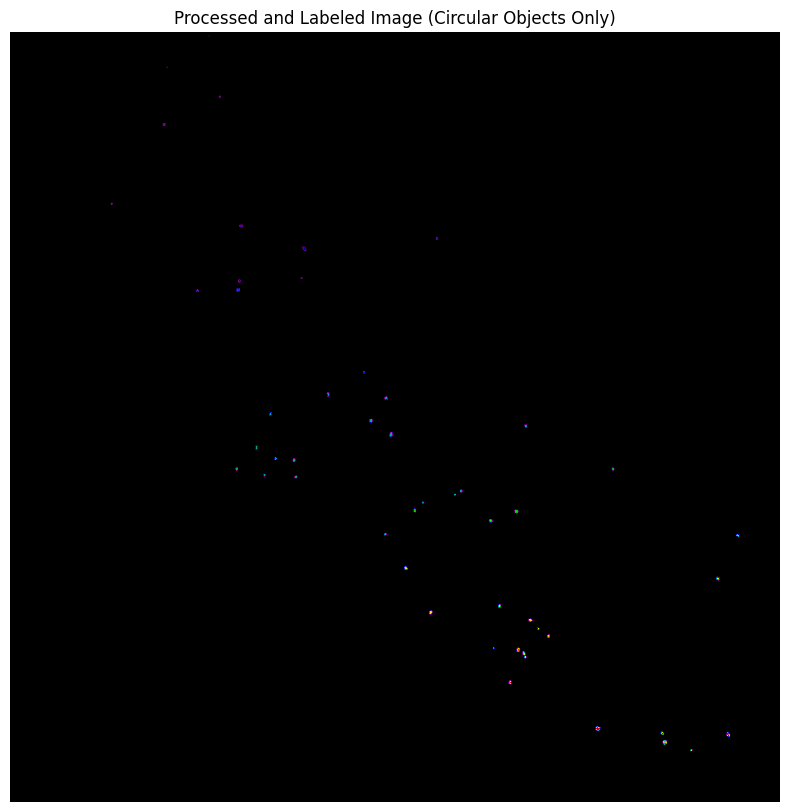

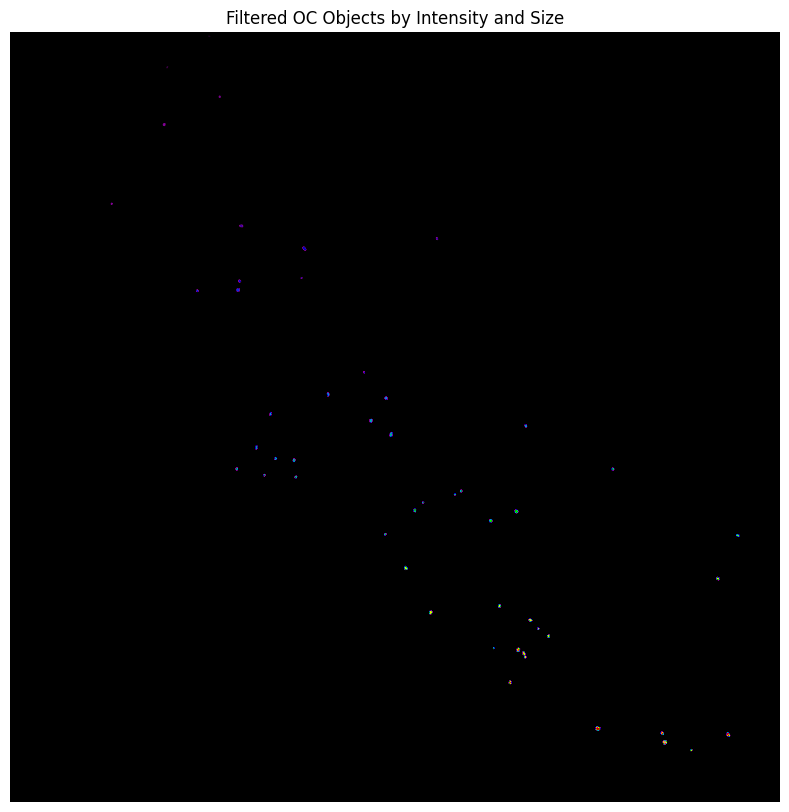

B_4_M04_OC_20x_B_4_M04_OC_SSCTX_230224_20x - B_4_M04_OC_20x.lif__M04_max.tiff


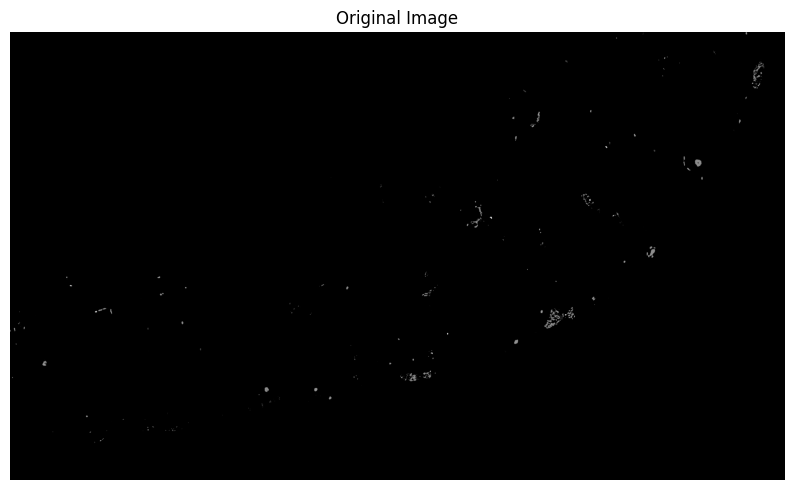

68 circular objects found


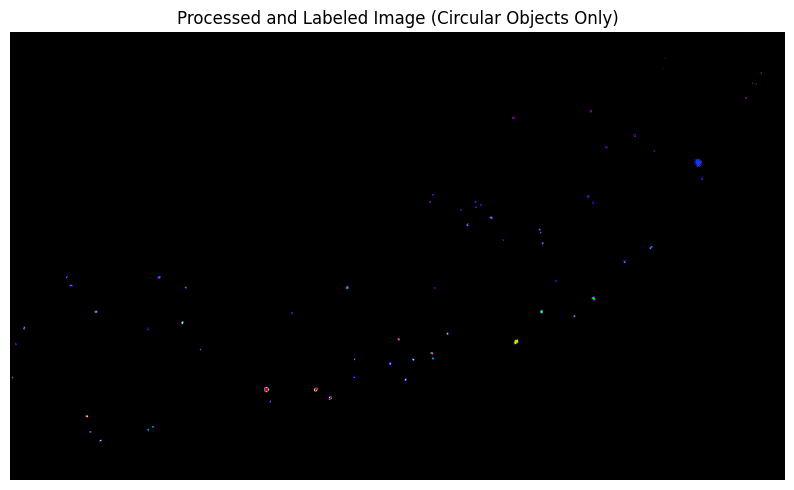

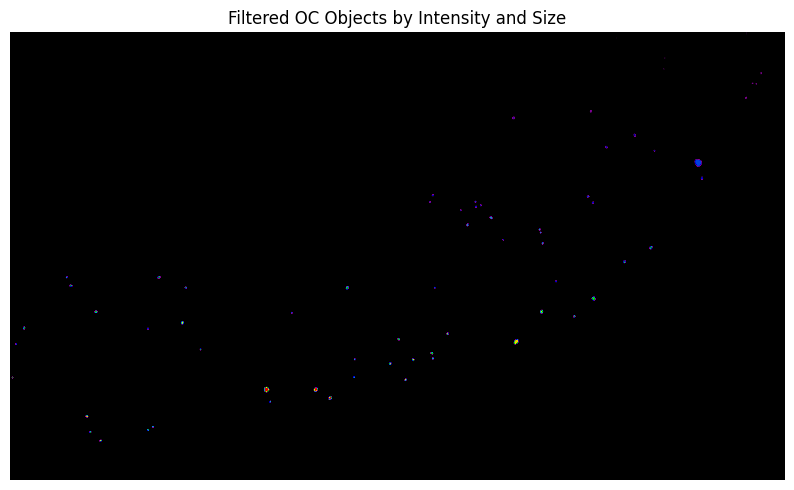

B_4_M04_OC_20x (2)_B_4_M04_OC_SSCTX_230224_20x - B_4_M04_OC_20x.lif__OC_max.tiff


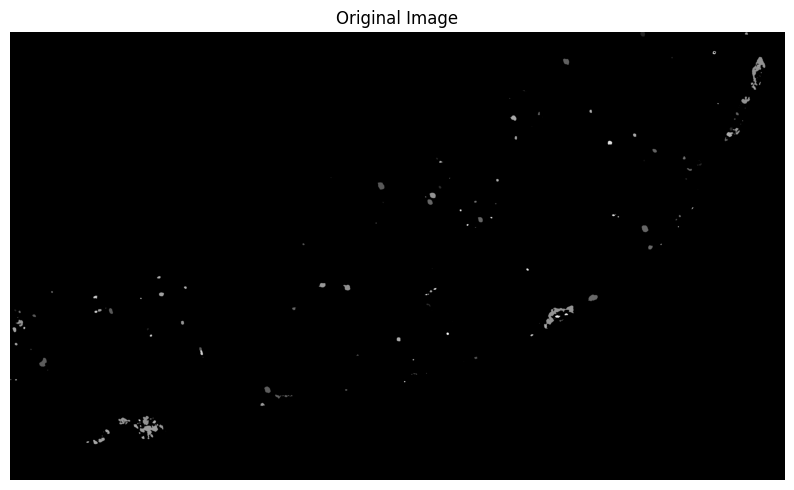

80 circular objects found


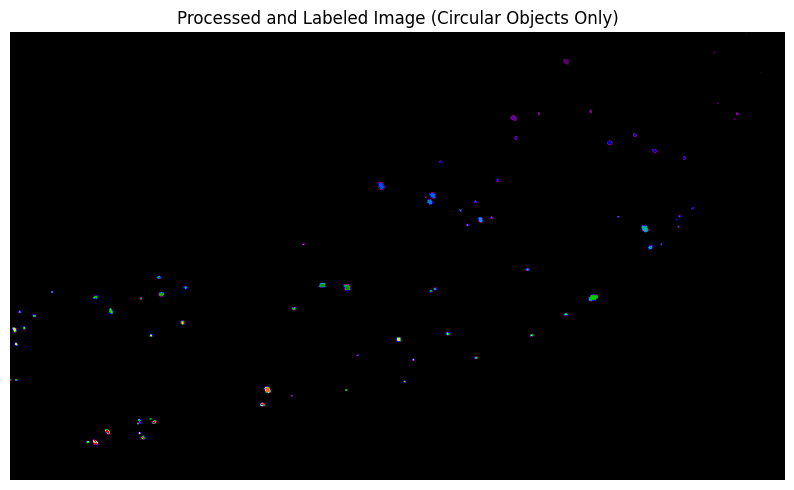

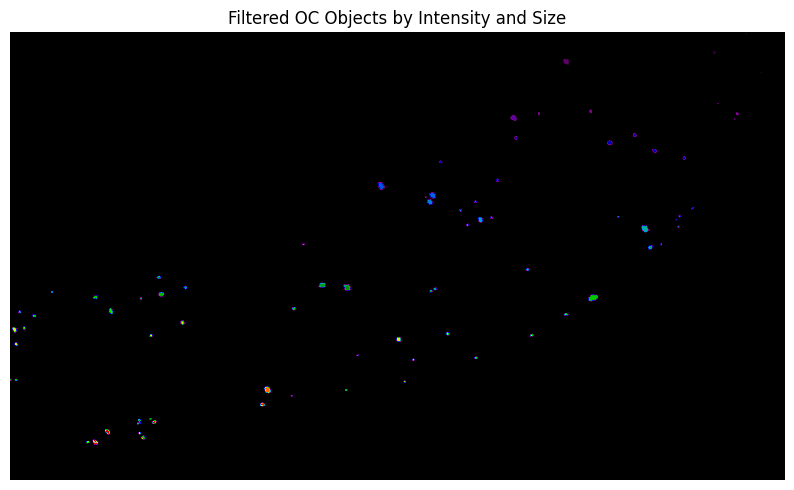

H_1_M04_OC_20x_H_1_M04_OC_HI_220224_20x - H_1_M04_OC_20x.lif__M04_max.tiff


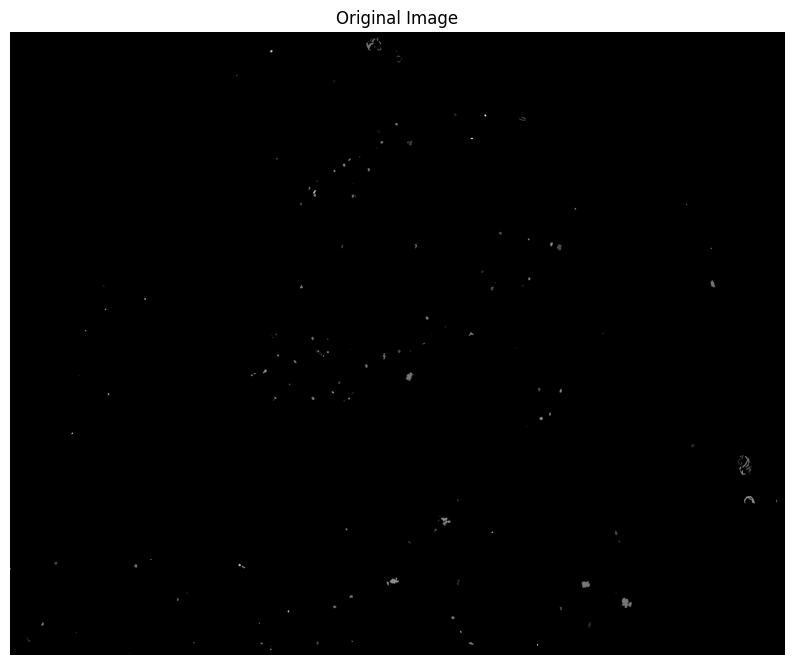

68 circular objects found


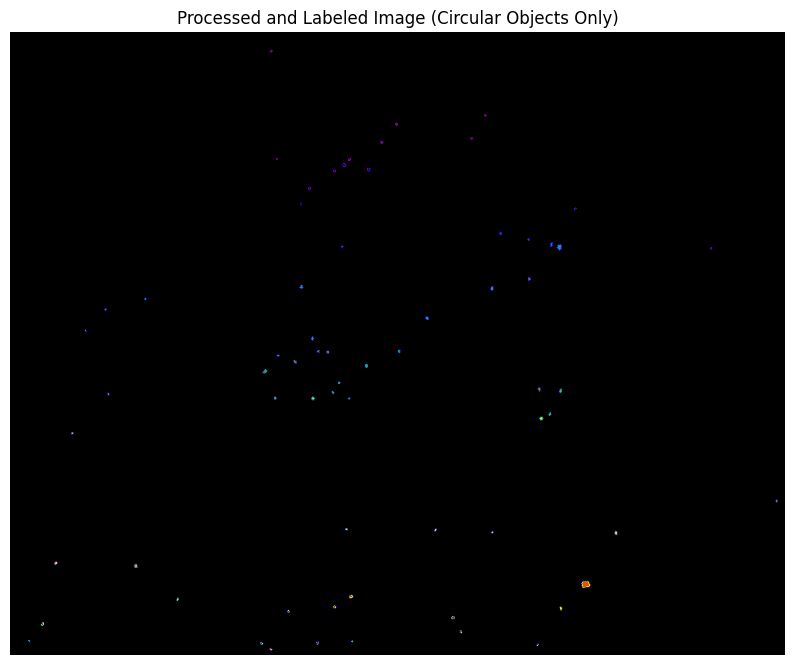

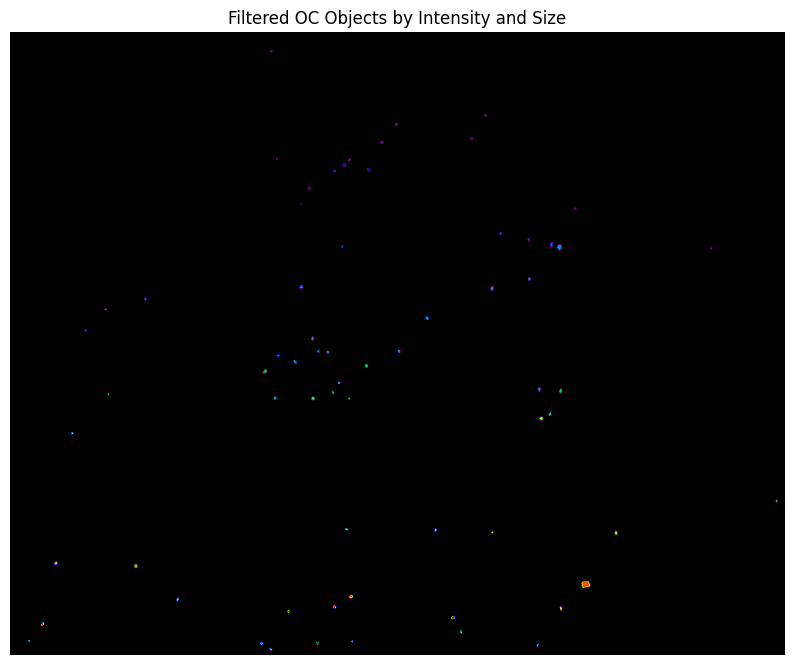

B_4_M04_OC_20x_B_4_M04_OC_HI_230224_20x - B_4_M04_OC_20x.lif (default)__M04_max.tiff


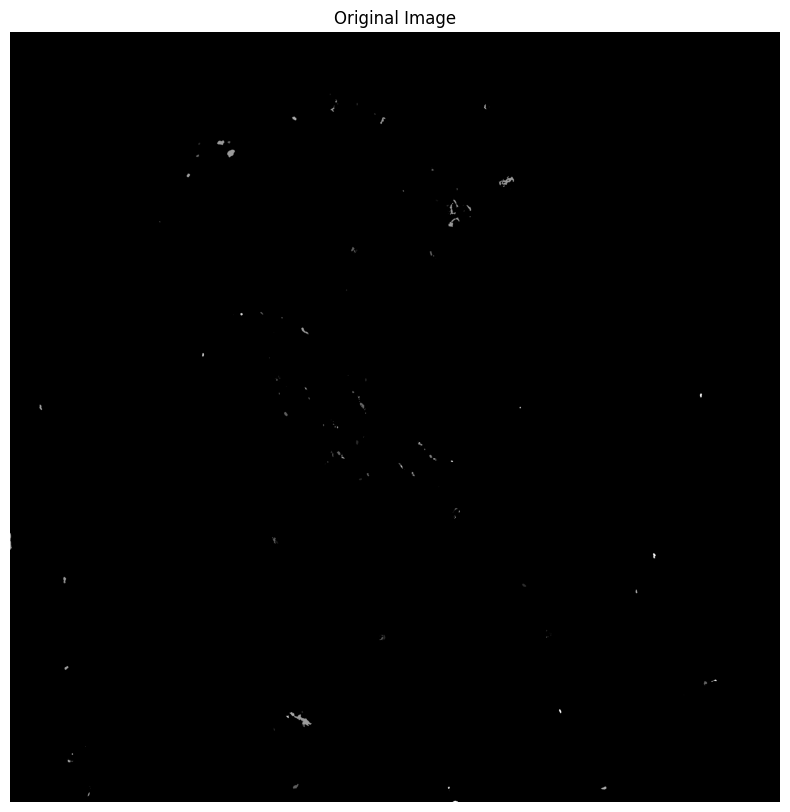

28 circular objects found


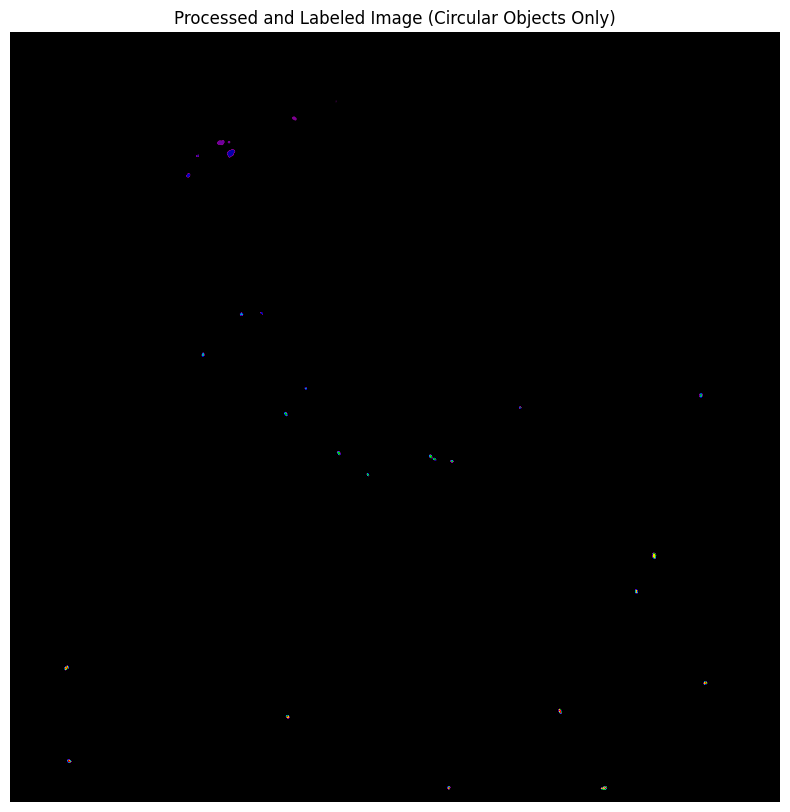

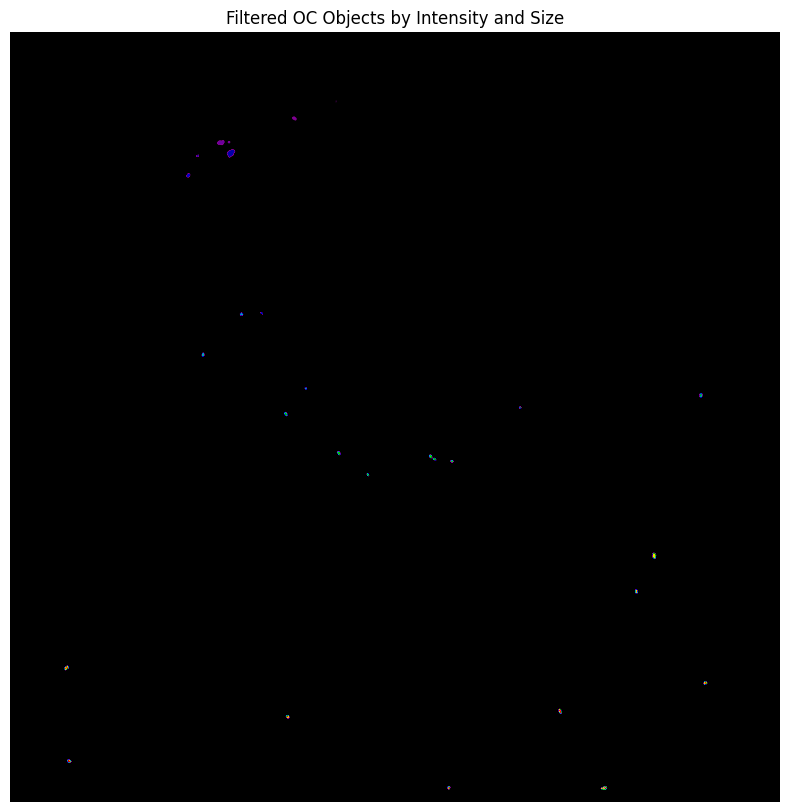

A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A_4_M04_OC_20x.lif (default)__OC_max.tiff


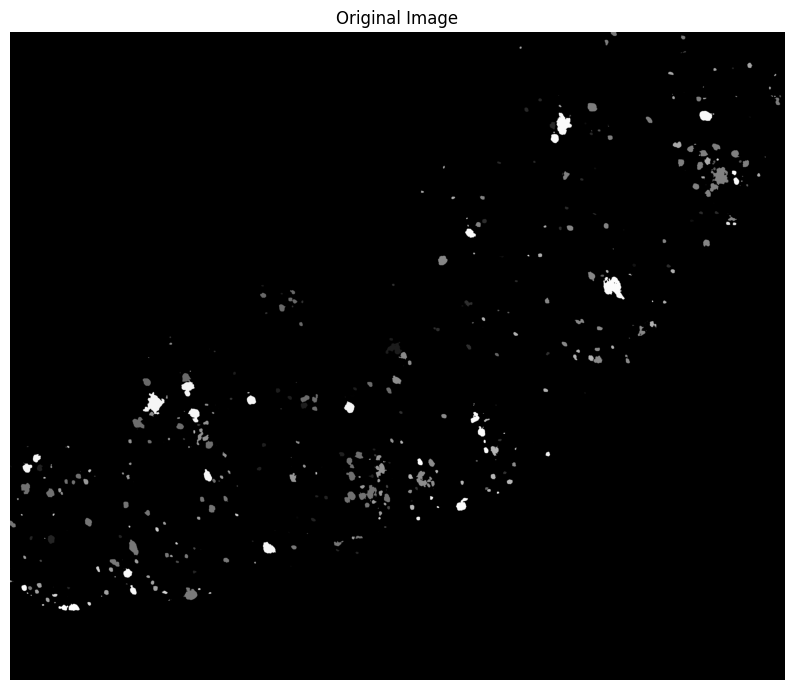

192 circular objects found


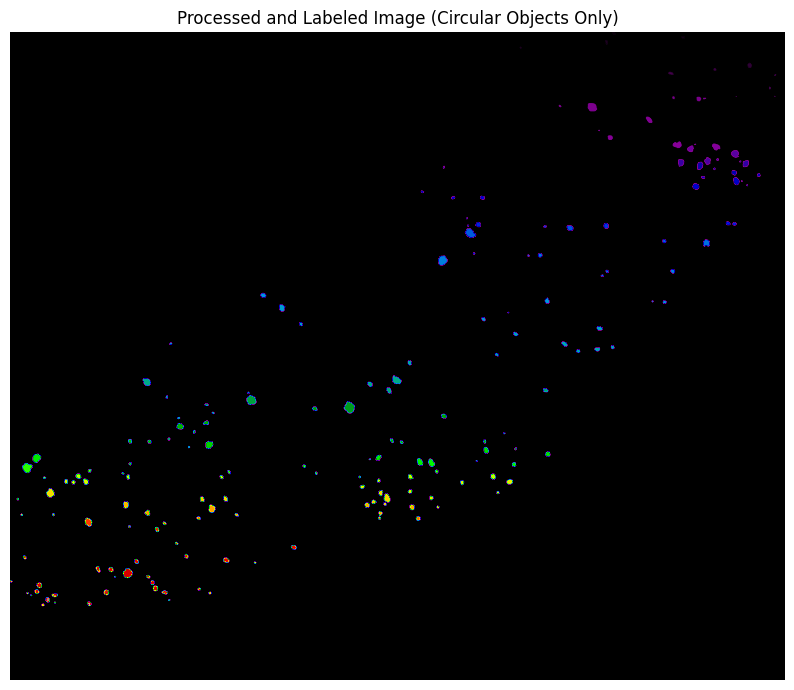

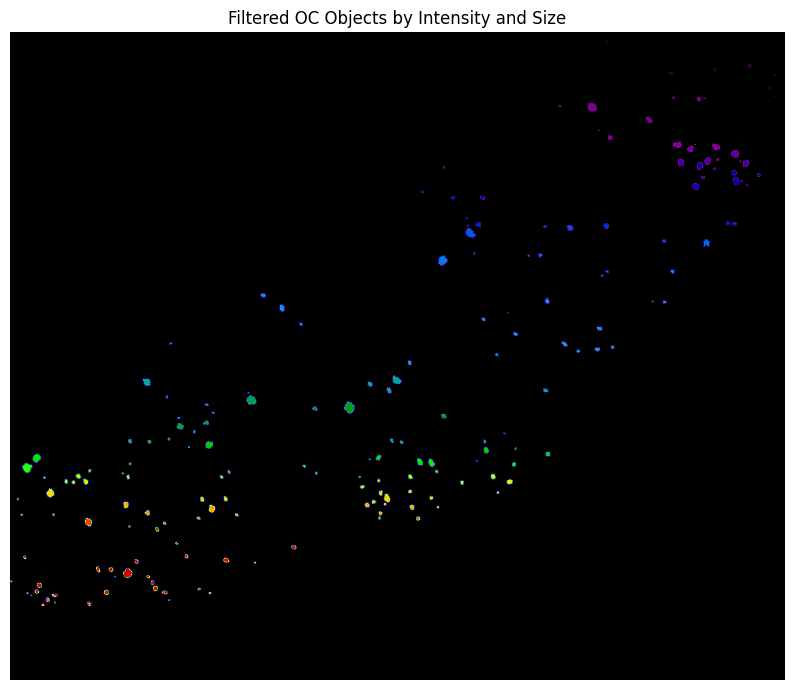

H_3_M04_OC_20x_H_3_M04_OC_SSCTX_210224_20x - H_3_M04_OC_20x.lif__M04_max.tiff


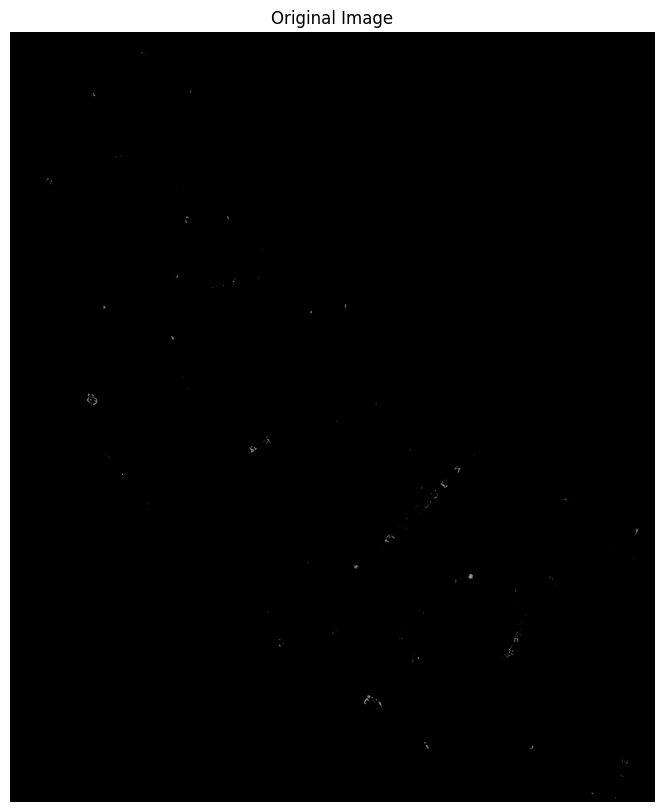

19 circular objects found


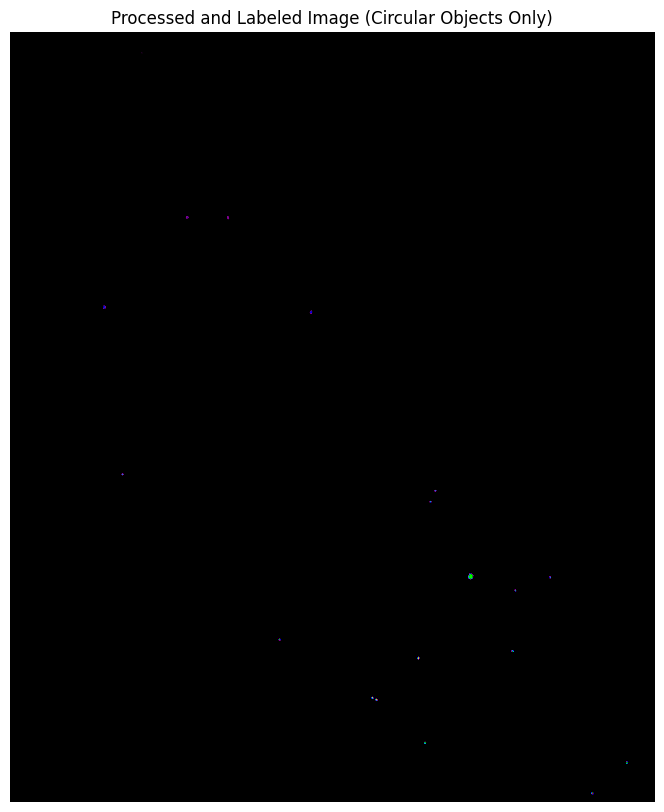

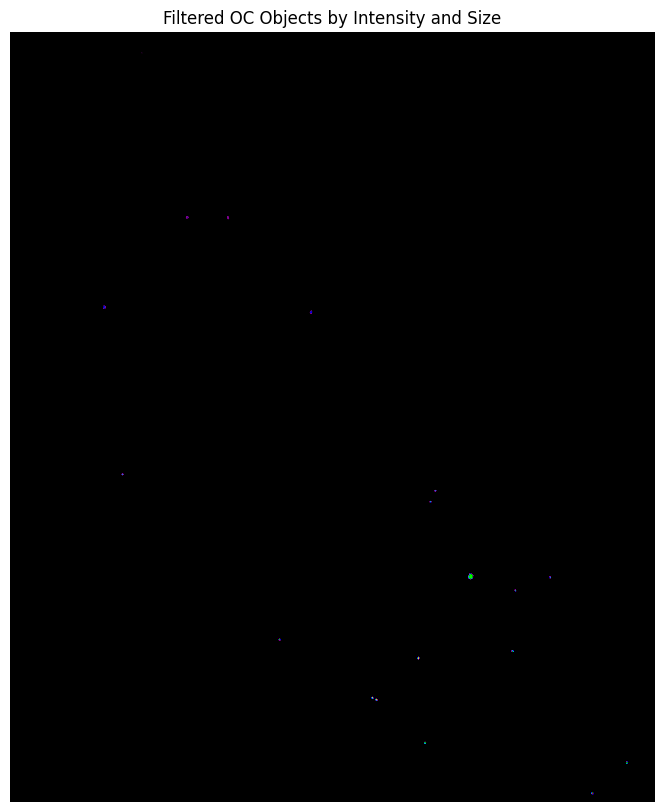

In [1]:
from skimage import io, filters, exposure, measure, color, morphology, util
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tf
from skimage.morphology import remove_small_objects, dilation, erosion, square


def process_image(image_path, circularity_threshold=0.75): 
    # Load the image
    image = io.imread(image_path)

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()

    # Convert to grayscale and apply Gaussian blur
    image_gray = color.rgb2gray(image) if image.ndim == 3 else image
    image_blurred = filters.gaussian(image_gray, sigma=2)

    # Enhance contrast and apply morphological closing
    image_contrast_enhanced = exposure.rescale_intensity(image_blurred, out_range=(0, 256))
    image_closed = morphology.closing(image_contrast_enhanced, morphology.disk(5))
    
    # Threshold image to binary
    thresh = image_closed > filters.threshold_otsu(image_closed)
    clean_image = remove_small_objects(thresh, min_size=50)

    # Merge nearby/overlapping objects
    dilated_image = dilation(clean_image, square(5))
    merged_objects = erosion(dilated_image, square(5))

    # Label the objects
    labels = measure.label(merged_objects, background=0, connectivity=2)

    # Iterate through objects and filter based on circularity
    filtered_labels = np.zeros_like(labels)
    for region in measure.regionprops(labels):
        if region.area > 0:
            perimeter = region.perimeter
            area = region.area
            circularity = 4 * np.pi * area / (perimeter ** 2)
            if circularity >= circularity_threshold:
                filtered_labels[labels == region.label] = region.label

    num_objects = len(np.unique(filtered_labels)) - 1  # Excluding the background
    print(f'{num_objects} circular objects found')

    plt.figure(figsize=(10, 10))
    plt.imshow(filtered_labels, cmap='nipy_spectral')
    plt.title('Processed and Labeled Image (Circular Objects Only)')
    plt.axis('off')
    plt.show()

    return filtered_labels


# Directory containing the images
images_dir = '/Users/katherineridley/Projects/PlaqueDist/Masks'
image_files = os.listdir(images_dir)


# Process each OC_avg image and find corresponding M04_max image
for image_file in image_files:
    
    if '_max.tiff' in image_file:
        print(image_file)
        oc_image_path = os.path.join(images_dir, image_file)
        oc_labels = process_image(oc_image_path)

        #convert to 8-bit
        oc_labels = oc_labels.astype(np.uint16)

        #save labels as mask
        tf.imwrite(os.path.join(images_dir, f'{image_file[:-9]}_mask.tiff'), oc_labels)

        plt.figure(figsize=(10, 10))
        plt.imshow(oc_labels, cmap='nipy_spectral')
        plt.title('Filtered OC Objects by Intensity and Size')
        plt.axis('off')
        plt.show()
        # Construct M04_max filename and path
        '''m04_image_file = image_file.replace('OC_max', 'M04_max')

        m04_image_path = os.path.join(images_dir, m04_image_file)
        if os.path.exists(m04_image_path):
            # Load and process the M04_max image

            m04image = io.imread(m04_image_path)
            m04image_gray = color.rgb2gray(m04image) if m04image.ndim == 3 else m04image

            # Apply Gaussian blur
            m04image_blurred = filters.gaussian(m04image_gray, sigma=2)

            # Enhance contrast by rescaling the intensity of the image
            m04image_contrast_enhanced = exposure.rescale_intensity(m04image_blurred, out_range=(0, 256))

            


        image_stack = io.imread(m04_image_path)
            if image_stack.ndim == 3 and image_stack.shape[-1] in [3, 4]:  # RGB or RGBA
                image = rgb2gray(image_stack)
            elif image_stack.ndim == 3:  # 3D stack
                image = np.max(image_stack, axis=0)
            else:  # Already 2D
                image = image_stack


            #increase size of objects
            image = morphology.dilation(image, morphology.disk(2))

            thresh = image > 25
            labeled_image, num_features = measure.label(thresh, return_num=True, connectivity=2)

            # Label the objects
            

            plt.figure(figsize=(10, 10))
            plt.imshow(labeled_image)
            plt.title('M04 Labels')
            plt.axis('off')
            plt.show()

            # Create a boolean mask where the OC_avg labels overlap with M04_max labels
                        # Initialize a mask to store the final OC labels that have sufficient overlap with M04 labels
            final_oc_labels_mask = np.zeros_like(oc_labels, dtype=bool)

            # Loop through each unique label in M04
            for m04_label in np.unique(labeled_image):
                if m04_label == 0:
                    continue  # Skip background
                
                # Create a mask for the current M04 label
                m04_label_mask = (labeled_image == m04_label)
                
                # Find the OC label(s) that intersect with the current M04 label
                intersecting_oc_labels = np.unique(oc_labels[m04_label_mask])
                
                for oc_label in intersecting_oc_labels:
                    if oc_label == 0:
                        continue  # Skip background

                    # Create a mask for the current OC label
                    oc_label_mask = (oc_labels == oc_label)

                    # Calculate the overlap as the intersection over the M04 label size
                    overlap = np.sum(oc_label_mask & m04_label_mask) / np.sum(m04_label_mask)

                    # If there's at least 50% overlap, add the OC label to our final mask
                    if overlap >= 0.5:
                        final_oc_labels_mask[oc_label_mask] = True

            # Label the final regions
            final_labels = measure.label(final_oc_labels_mask)

            #save labels as mask
            tf.imwrite(os.path.join(images_dir, f'{image_file[:-11]}_combined_mask.tiff'), final_labels)

            # Display the final labels
            plt.figure(figsize=(10, 10))
            plt.imshow(color.label2rgb(final_labels, bg_label=0, alpha=0.3))
            plt.title(f'OC Labels with >= 50% Overlap with M04 Labels for {image_file}')
            plt.axis('off')
            plt.show()

            #find oc and methoxy double positive objects'''





In [2]:
from skimage import io, measure
import numpy as np
import os
import pandas as pd
from scipy.stats import ttest_ind
from skimage.measure import label

def calculate_overlap(oc_mask, m04_mask):
    # Label both masks
    oc_labels = label(oc_mask)
    m04_labels = label(m04_mask)

    # Prepare a mask to hold the overlaps
    overlap_mask = np.zeros_like(oc_mask, dtype=bool)

    # Iterate over all unique labels in the OC mask
    for oc_label in np.unique(oc_labels):
        if oc_label == 0:  # Skip background
            continue

        # Prepare an empty mask for the current OC object
        oc_object_mask = (oc_labels == oc_label)

        # Find M04 objects that intersect with the current OC object
        intersecting_m04_labels = np.unique(m04_labels[oc_object_mask])

        for m04_label in intersecting_m04_labels:
            if m04_label == 0:  # Skip background
                continue

            # Directly use the M04 object mask since we're assuming M04 is inside OC
            m04_object_mask = (m04_labels == m04_label)

            # If there's any intersection, consider the M04 label as valid
            if np.any(np.logical_and(oc_object_mask, m04_object_mask)):
                # Instead of calculating IoU, directly add the M04 label to the overlap mask
                overlap_mask[m04_object_mask] = True

    return overlap_mask

def find_and_save_overlapping_areas(images_dir, oc_image_file, m04_image_file, prefix):
    """
    Load the given OC and M04 masks, find overlapping areas, and save a new mask
    with those areas.
    """
    oc_mask_path = os.path.join(images_dir, oc_image_file)
    m04_mask_path = os.path.join(images_dir, m04_image_file)

    oc_mask = io.imread(oc_mask_path) > 0  # Assuming masks are binary; adjust as necessary
    m04_mask = io.imread(m04_mask_path) > 0

    overlap_mask = calculate_overlap(oc_mask, m04_mask)

    # Convert the overlap mask to an integer label mask
    overlap_labels = label(overlap_mask)

    # Save the new mask
    new_mask_path = os.path.join(images_dir, f"{prefix}__overlap_mask.tiff")
    io.imsave(new_mask_path, overlap_labels.astype(np.uint16))


# Directory containing the images
images_dir = '/Users/katherineridley/Projects/PlaqueDist/Masks'

# Load the genotype key
genotype_key = pd.read_csv('/Users/katherineridley/Projects/PlaqueDist/genotypekey.csv')

def calculate_metrics(image_path):
    
    labels = io.imread(image_path)
    props = measure.regionprops(labels)
    areas = np.array([prop.area for prop in props])

    # Handle case where areas array is empty
    if areas.size == 0:
        print(f"No objects found in image: {image_path}")
        return 0, 0, 0, 0  # Return zeroes for density, mean area, std area, and object count

    # Normalize areas
    normalized_areas = (areas - np.min(areas)) / (np.max(areas) - np.min(areas))

    # Remove outliers
    lower_bound, upper_bound = np.percentile(normalized_areas, [10, 90])
    filtered_areas = normalized_areas[(normalized_areas > lower_bound) & (normalized_areas < upper_bound)]
    
    # Calculate density, mean, and std of the filtered areas
    density = len(filtered_areas) / labels.size * 100
    mean_area = np.mean(filtered_areas)
    std_area = np.std(filtered_areas)
    
    return density, mean_area, std_area, len(filtered_areas)

def find_and_save_overlapping_areas_with_metrics(images_dir, oc_image_file, m04_image_file, prefix):
    oc_mask_path = os.path.join(images_dir, oc_image_file)
    m04_mask_path = os.path.join(images_dir, m04_image_file)

    oc_mask = io.imread(oc_mask_path) > 0  # Binary check
    m04_mask = io.imread(m04_mask_path) > 0

    overlap_mask = calculate_overlap(oc_mask, m04_mask)

    # Convert the overlap mask to an integer label mask for saving
    overlap_labels = label(overlap_mask)
    new_mask_path = os.path.join(images_dir, f"{prefix}__overlap_mask.tiff")
    io.imsave(new_mask_path, overlap_labels.astype(np.uint16))
    
    # Calculate metrics for the overlap mask
    combined_density, combined_mean_area, combined_std_area, combined_objects = calculate_metrics(new_mask_path)
    
    return {
        "combined_density": combined_density, 
        "combined_mean_area": combined_mean_area, 
        "combined_std_area": combined_std_area, 
        "combined_objects": combined_objects
    }

density_data = []

# List and preprocess image files
image_files = os.listdir(images_dir)
prefixes = set(file.split('__')[0] for file in image_files if 'OC_mask.tiff' in file or 'M04_mask.tiff' in file)

# Process each unique image set
for prefix in prefixes:
    oc_image_file = next((file for file in image_files if file.startswith(prefix) and 'OC_mask.tiff' in file), None)
    m04_image_file = next((file for file in image_files if file.startswith(prefix) and 'M04_mask.tiff' in file), None)
    
    if oc_image_file and m04_image_file:
        oc_density, oc_mean_area, oc_std_area, oc_objects = calculate_metrics(os.path.join(images_dir, oc_image_file))
        m04_density, m04_mean_area, m04_std_area, m04_objects = calculate_metrics(os.path.join(images_dir, m04_image_file))
        
        # Calculate the combined metrics
        combined_metrics = find_and_save_overlapping_areas_with_metrics(images_dir, oc_image_file, m04_image_file, prefix)

        section = prefix.split('_')[0]
        genotype_info = genotype_key[genotype_key['image_name'].str.contains(section, regex=False)]
        genotype = genotype_info['Genotype'].iloc[0] if not genotype_info.empty else "Unknown"
        
        # Extend density_data with combined metrics
        density_data.append({
            'prefix': prefix,
            'genotype': genotype,
            'oc_density': oc_density,
            'm04_density': m04_density,
            'oc_mean_area': oc_mean_area,
            'm04_mean_area': m04_mean_area,
            'oc_std_area': oc_std_area,
            'm04_std_area': m04_std_area,
            'oc_objects': oc_objects,
            'm04_objects': m04_objects,
            # Include combined metrics
            'combined_density': combined_metrics['combined_density'],
            'combined_mean_area': combined_metrics['combined_mean_area'],
            'combined_std_area': combined_metrics['combined_std_area'],
            'combined_objects': combined_metrics['combined_objects']
        })


density_df = pd.DataFrame(density_data)
density_df.to_csv('/Users/katherineridley/Projects/PlaqueDist/density_metrics_w_overlap.csv', index=False)

from scipy.stats import ttest_ind
import pandas as pd
import numpy as np



for column in ['oc_density', 'm04_density', 'oc_mean_area', 'm04_mean_area', 'oc_std_area', 'm04_std_area', 'oc_objects', 'm04_objects', 'combined_density', 'combined_mean_area', 'combined_std_area', 'combined_objects']:
    for genotype in ['APPPS1', 'APPPS1xFIRE']:
        genotype_values = density_df[density_df['genotype'] == genotype][column]
        if genotype_values.isnull().any():
            # Fill NaN values with the mean of the non-NaN values
            density_df.loc[density_df['genotype'] == genotype, column] = genotype_values.fillna(genotype_values.mean())
t_test_results = {}
# Perform t-tests for each metric with nan_policy='omit' to safely ignore NaN values
metrics = ['density', 'mean_area', 'std_area', 'objects']
for metric in metrics:
    for stain in ['oc', 'm04', 'combined']:
        ttest_result = ttest_ind(
            density_df[density_df['genotype'] == 'APPPS1'][f'{stain}_{metric}'],
            density_df[density_df['genotype'] == 'APPPS1xFIRE'][f'{stain}_{metric}'],
            nan_policy='omit'  # This tells the t-test to ignore NaN values
        )
        t_test_results[f'{stain}_{metric}'] = ttest_result
        print(f'{stain.upper()} {metric} t-test result between APPPS1 and APPPS1xFIRE: {ttest_result}')

        #mann whitney u test
        from scipy.stats import mannwhitneyu
mwu_results = {}
for metric in metrics:
    for stain in ['oc', 'm04', 'combined']:
        mwu_result = mannwhitneyu(
            density_df[density_df['genotype'] == 'APPPS1'][f'{stain}_{metric}'],
            density_df[density_df['genotype'] == 'APPPS1xFIRE'][f'{stain}_{metric}'],
            alternative='two-sided'
        )
        mwu_results[f'{stain}_{metric}'] = mwu_result
        print(f'{stain.upper()} {metric} Mann-Whitney U test result between APPPS1 and APPPS1xFIRE: {mwu_result}')

        # Save the t-test results to a CSV file







/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_9449/2174036490.py:105: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/A_4_M04_OC_20x_A_4_M04_OC_SSCTX_220224_20x - A_4_M04_OC_20x.lif (default)__overlap_mask.tiff is a low contrast image
  io.imsave(new_mask_path, overlap_labels.astype(np.uint16))
/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_9449/2174036490.py:105: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/C_2_M04_OC_20x_C_2_M04_OC_HI_080124_20x - C_2_M04_OC_20x.lif (default)__overlap_mask.tiff is a low contrast image
  io.imsave(new_mask_path, overlap_labels.astype(np.uint16))
/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_9449/2174036490.py:105: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/D_3_M04_OC_20x_D_3_M04_OC_HI_080124_20x - D_3_M04_OC_20x.lif (default)__overlap_mask.tiff is a low contrast image
  io.imsave(new_mask_path, overlap_labels.astype(np.uint16))
/var/folders/c7/rvxz8xg96pxfhyt34649y

OC density t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=2.269674518262695, pvalue=0.03444046630359701, df=20.0)
M04 density t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=1.9731544188554364, pvalue=0.06245849869231168, df=20.0)
COMBINED density t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=1.8414829473954961, pvalue=0.08043233602405132, df=20.0)
OC mean_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=-1.4718477581511158, pvalue=0.15662358627660355, df=20.0)
M04 mean_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=0.24619915148801955, pvalue=0.8080372036992706, df=20.0)
COMBINED mean_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=-0.022748060684463157, pvalue=0.9820766705893985, df=20.0)
OC std_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=-1.7344789374684828, pvalue=0.09822027255886645, df=20.0)
M04 std_area t-test resu

/var/folders/c7/rvxz8xg96pxfhyt34649yfqh0000gn/T/ipykernel_9449/2174036490.py:105: UserWarning: /Users/katherineridley/Projects/PlaqueDist/Masks/H_1_M04_OC_20x_H_1_M04_OC_HI_220224_20x - H_1_M04_OC_20x.lif__overlap_mask.tiff is a low contrast image
  io.imsave(new_mask_path, overlap_labels.astype(np.uint16))


In [10]:
density_df = pd.read_csv('/Users/katherineridley/Projects/PlaqueDist/density_metrics_w_overlap.csv')

from scipy.stats import ttest_ind
import pandas as pd
import numpy as np



for column in ['oc_density', 'm04_density', 'oc_mean_area', 'm04_mean_area', 'oc_std_area', 'm04_std_area', 'oc_objects', 'm04_objects', 'combined_density', 'combined_mean_area', 'combined_std_area', 'combined_objects']:
    for genotype in ['APPPS1', 'APPPS1xFIRE']:
        genotype_values = density_df[density_df['genotype'] == genotype][column]
        if genotype_values.isnull().any():
            # Fill NaN values with the mean of the non-NaN values
            density_df.loc[density_df['genotype'] == genotype, column] = genotype_values.fillna(genotype_values.mean())
            #test for outliers
            from scipy.stats import zscore
            z_scores = zscore(genotype_values)
            abs_z_scores = np.abs(z_scores)
            outliers = (abs_z_scores > 3)
            print(f'Outliers for {genotype} {column}: {genotype_values[outliers]}')

t_test_results = {}
# Perform t-tests for each metric with nan_policy='omit' to safely ignore NaN values
metrics = ['density', 'mean_area', 'std_area', 'objects']
for metric in metrics:
    for stain in ['oc', 'm04', 'combined']:
        ttest_result = ttest_ind(
            density_df[density_df['genotype'] == 'APPPS1'][f'{stain}_{metric}'],
            density_df[density_df['genotype'] == 'APPPS1xFIRE'][f'{stain}_{metric}'],
            nan_policy='omit'  # This tells the t-test to ignore NaN values
        )
        t_test_results[f'{stain}_{metric}'] = ttest_result
        print(f'{stain.upper()} {metric} t-test result between APPPS1 and APPPS1xFIRE: {ttest_result}')

        #mann whitney u test
        from scipy.stats import mannwhitneyu
'''mwu_results = {}
for metric in metrics:
    for stain in ['oc', 'm04', 'combined']:
        mwu_result = mannwhitneyu(
            density_df[density_df['genotype'] == 'APPPS1'][f'{stain}_{metric}'],
            density_df[density_df['genotype'] == 'APPPS1xFIRE'][f'{stain}_{metric}'],
            alternative='two-sided'
        )
        mwu_results[f'{stain}_{metric}'] = mwu_result
        print(f'{stain.upper()} {metric} Mann-Whitney U test result between APPPS1 and APPPS1xFIRE: {mwu_result}')'''

Outliers for APPPS1xFIRE combined_mean_area: Series([], Name: combined_mean_area, dtype: float64)
Outliers for APPPS1xFIRE combined_std_area: Series([], Name: combined_std_area, dtype: float64)
OC density t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=2.269674518262494, pvalue=0.03444046630361129, df=20.0)
M04 density t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=1.973154418855529, pvalue=0.062458498692300427, df=20.0)
COMBINED density t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=1.8414829473956884, pvalue=0.08043233602402206, df=20.0)
OC mean_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=-1.471847758151115, pvalue=0.15662358627660375, df=20.0)
M04 mean_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=0.2461991514880195, pvalue=0.8080372036992707, df=20.0)
COMBINED mean_area t-test result between APPPS1 and APPPS1xFIRE: TtestResult(statistic=-0.022748060684464028, pvalue

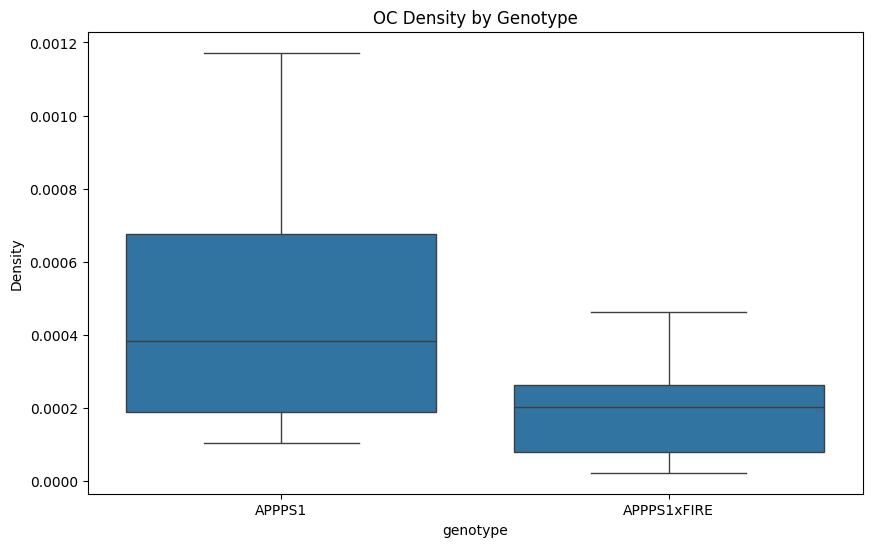

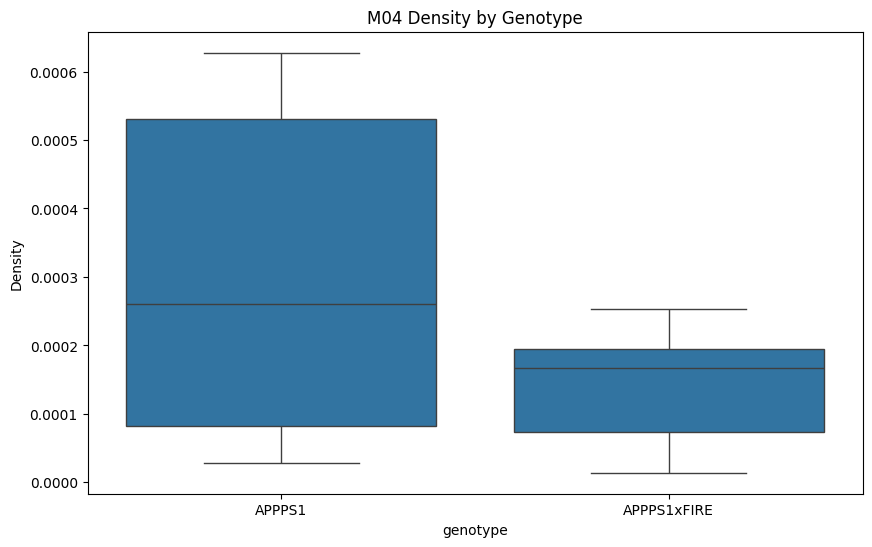

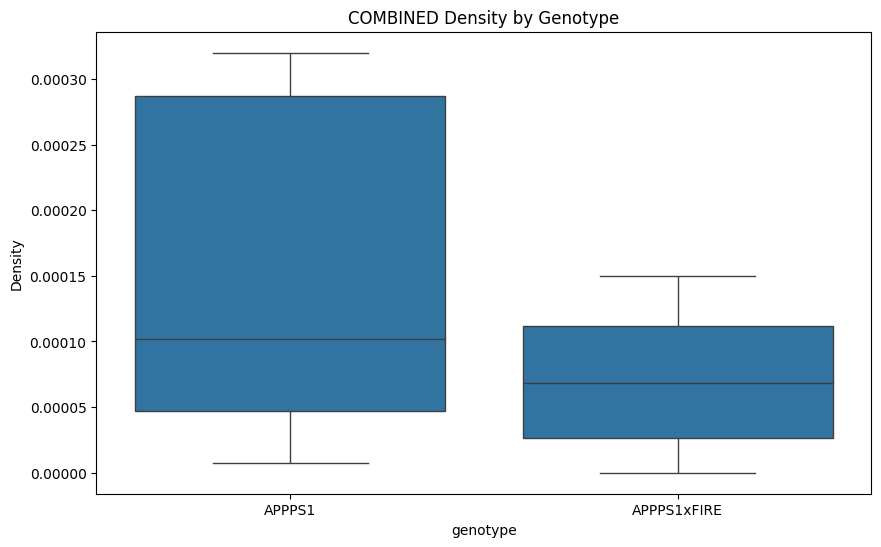

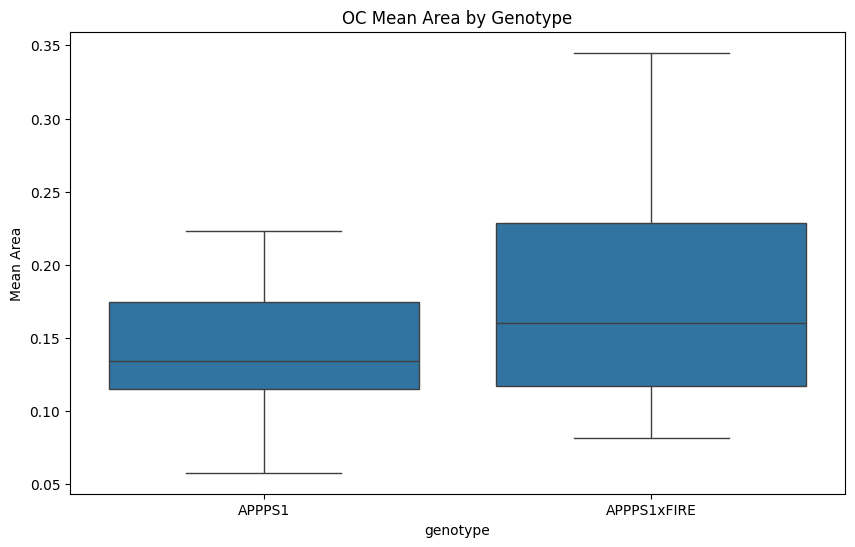

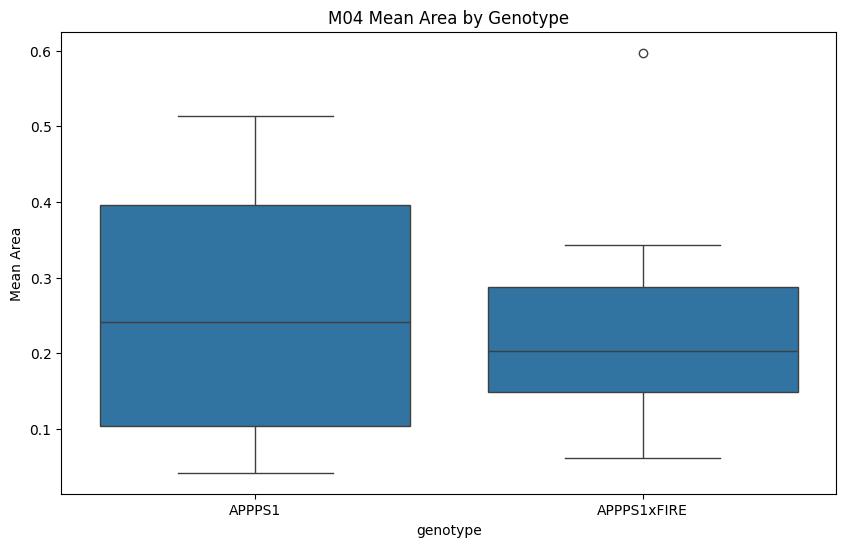

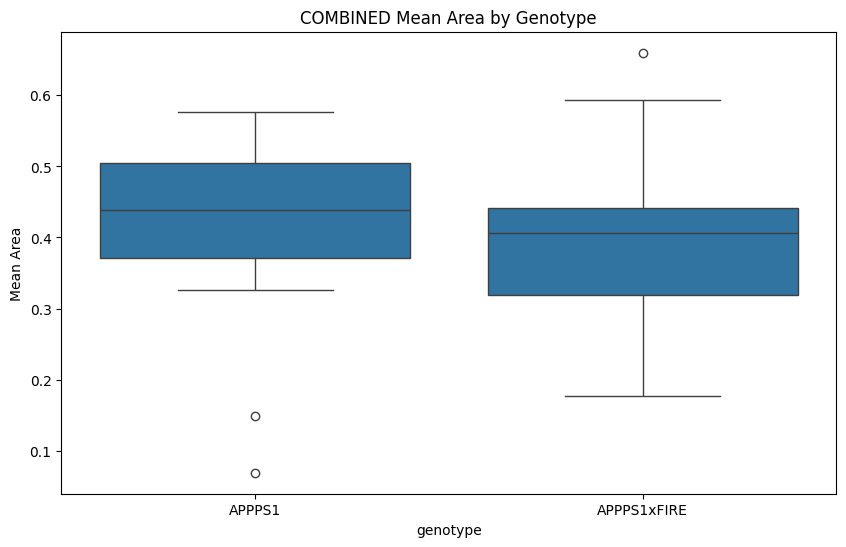

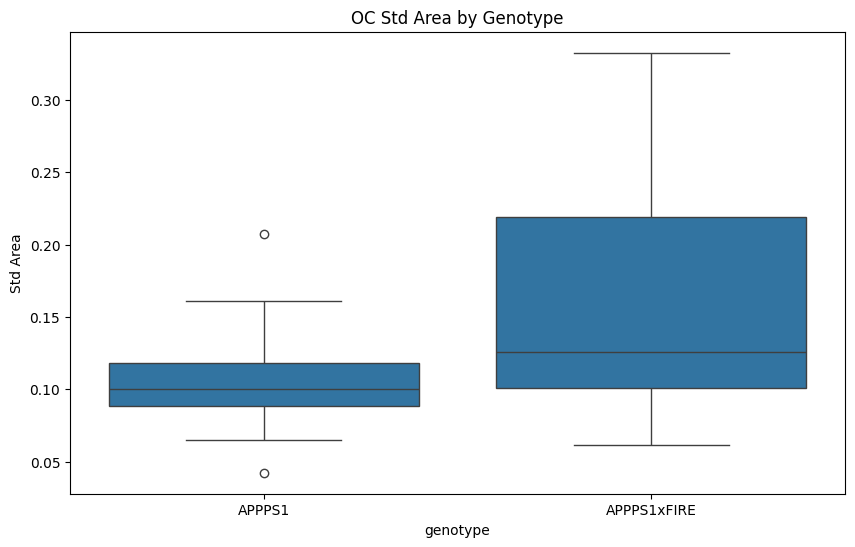

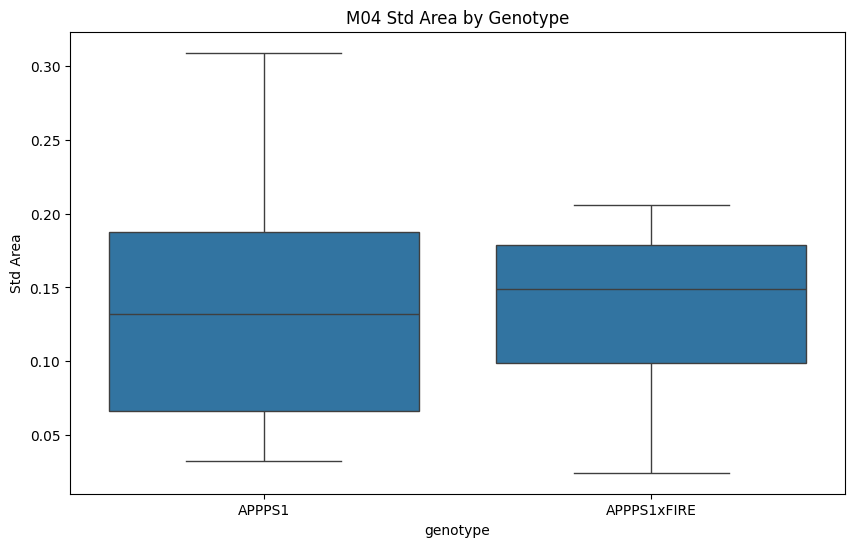

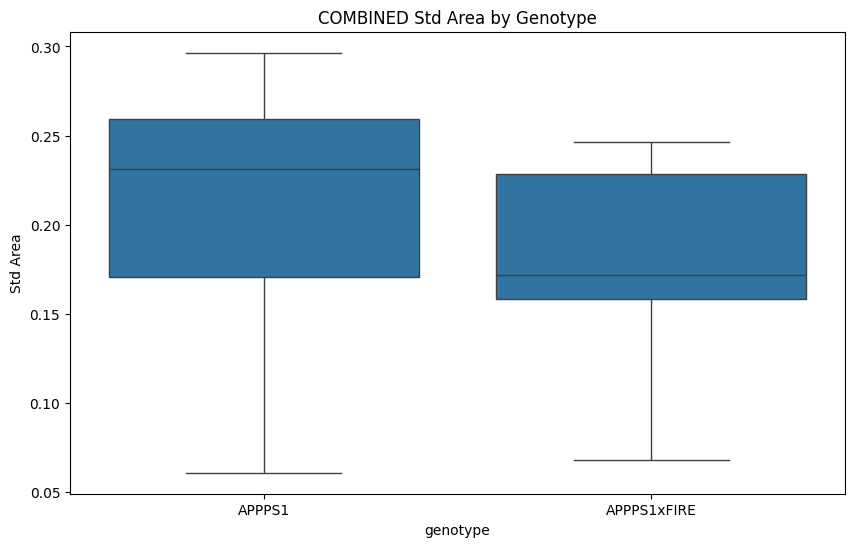

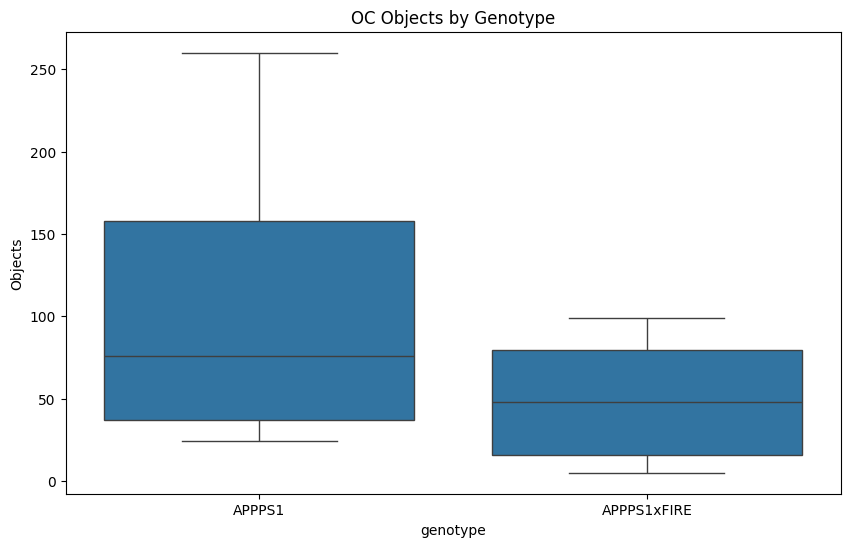

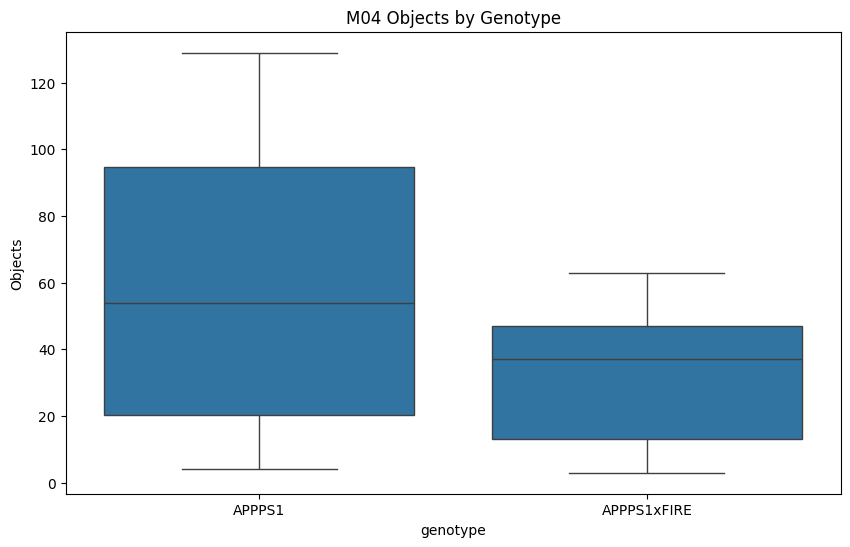

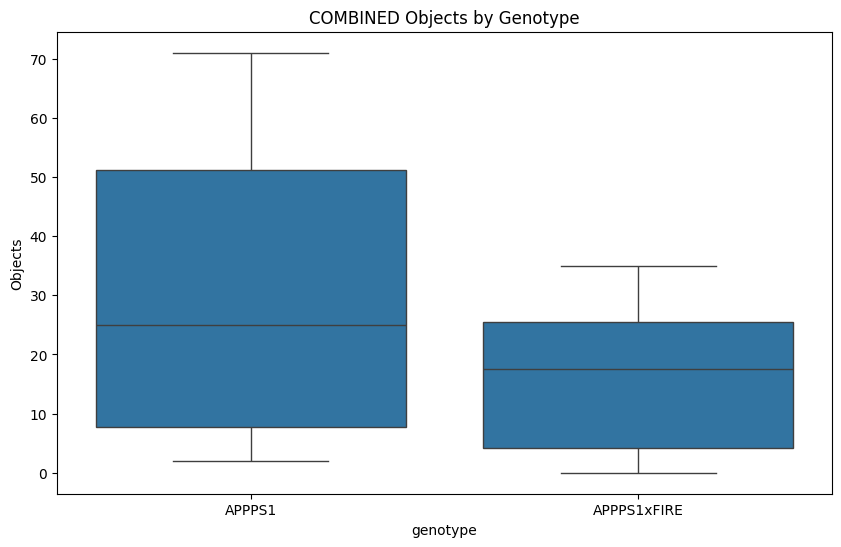

In [7]:
#plot density metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Load the density metrics
density_metrics = pd.read_csv('/Users/katherineridley/Projects/PlaqueDist/density_metrics_w_overlap.csv')

for metric in ['density', 'mean_area', 'std_area', 'objects']:
    for stain in ['oc', 'm04', 'combined']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='genotype', y=f'{stain}_{metric}', data=density_metrics)
        plt.title(f'{stain.upper()} {metric.replace("_", " ").title()} by Genotype')
        plt.ylabel(metric.replace("_", " ").title())
        plt.show()






In [4]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
